# Assignment #2 -- MicroService System Troubleshooting

<b>Questions to Address:</b>

In this assignment, we are required to give explanations for the 5 failures stated in failures.json, where their information can be found in the test_data.

A failure example found in failures.json:
```json
[
2220,  # failure time, Seconds past 00:00
 [
     ["os_021", "Sent_queue"] 
 ] # 2 root causes: [cmdb_id, key_name]
]
```

In the above, there is something wrong within the system at 00:37. We need to figure out in the system the specific performance that can indicate the failure and the corresponding root causes. For instance, we can give our answer from the following respects:
1. How the ESB data behave abnormally?
2. How the root causes affects the related Trace and Host KPIs?

Beware of the components in a trace, as they may influence each other through their call relationships.

## Import libraries and dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
import glob
import datetime

import gc
from typing import Tuple, List

from src.utils import *
from src.plots import *
from src.compute_actual_time import *

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

## Data Exploration

In [4]:
# Comment this code out and uncomment the next cell after executing this cell 1 time
test_trace = read_trace("test_data", "*", verbose=False, test_data=True)
train_trace = read_trace("train_data/2020_05_04", "*", verbose=False, test_data=False)

# test_trace.to_feather("data/test_data/trace/test_trace.feather")
# train_trace.to_feather("data/train_data/2020_05_04/trace/train_trace.feather")

In [5]:
# test_trace = pd.read_feather("data/test_data/trace/test_trace.feather")
# train_trace = pd.read_feather("data/train_data/2020_05_04/trace/train_trace.feather")

#### Point #1: The processes can be deeply nested

Example:

`cb48b17261295c467617` (37bd717261295c467616) <br>
-> `8073017261295c527619` (37bd717261295c467616) <br>
-> `62e7817261295c589816` (37bd717261295c467616) <br>
-> ... (19 IDs) <br>
-> ... (etc...)

<b>Tip: Follow the `traceId` to obtain a group of related service calls</b>

In [6]:
# test_trace_node = test_trace[test_trace.id == 'cb48b17261295c467617'] # Row: 17687689
# test_trace_node = test_trace[test_trace.pid == 'cb48b17261295c467617'] # Row: 0
# test_trace_node = test_trace[test_trace.pid == '8073017261295c527619'] # Row: 18033277
# test_trace_node = test_trace[test_trace.pid == '62e7817261295c589816'] # Row: 4, 10, 12, 16, 1706877, 10886669, 10886670, 10886671, 10886674, 10886677, 10886679, 10886684, 10886690, 10886702, 10886705, 10886707, 10886709, 10886711, 10886713
test_trace[test_trace.traceId == "37bd717261295c467616"]

callType                        startTime  \
0                   CSF 2020-05-30 00:00:00.082000+08:00   
4                   CSF 2020-05-30 00:00:00.103000+08:00   
10                  CSF 2020-05-30 00:00:00.268000+08:00   
12                  CSF 2020-05-30 00:00:00.441000+08:00   
16                  CSF 2020-05-30 00:00:00.561000+08:00   
1706877       FlyRemote 2020-05-30 00:00:00.094000+08:00   
2050698            JDBC 2020-05-30 00:00:00.183000+08:00   
2050700            JDBC 2020-05-30 00:00:00.192000+08:00   
2050706            JDBC 2020-05-30 00:00:00.281000+08:00   
2050710            JDBC 2020-05-30 00:00:00.291000+08:00   
2050714            JDBC 2020-05-30 00:00:00.387000+08:00   
2050718            JDBC 2020-05-30 00:00:00.448000+08:00   
2050721            JDBC 2020-05-30 00:00:00.456000+08:00   
2050726            JDBC 2020-05-30 00:00:00.529000+08:00   
2050730            JDBC 2020-05-30 00:00:00.574000+08:00   
2050734            JDBC 2020-05-30 00:00:00.584000+08:00   
2050738            JDBC 2020-05-30 00:00:00.615000+08:00   
2050739            JDBC 2020-05-30 00:00:00.616000+08:00   
2050740            JDBC 2020-05-30 00:00:00.619000+08:00   
2050743            JDBC 2020-05-30 00:00:00.622000+08:00   
2050746            JDBC 2020-05-30 00:00:00.624000+08:00   
2050747            JDBC 2020-05-30 00:00:00.626000+08:00   
2050753            JDBC 2020-05-30 00:00:00.630000+08:00   
2050759            JDBC 2020-05-30 00:00:00.633000+08:00   
2050771            JDBC 2020-05-30 00:00:00.651000+08:00   
2050774            JDBC 2020-05-30 00:00:00.655000+08:00   
2050775            JDBC 2020-05-30 00:00:00.658000+08:00   
2050777            JDBC 2020-05-30 00:00:00.660000+08:00   
2050780            JDBC 2020-05-30 00:00:00.664000+08:00   
2050782            JDBC 2020-05-30 00:00:00.666000+08:00   
2050784            JDBC 2020-05-30 00:00:00.667000+08:00   
2050787            JDBC 2020-05-30 00:00:00.671000+08:00   
10886645          LOCAL 2020-05-30 00:00:00.182000+08:00   
10886649          LOCAL 2020-05-30 00:00:00.281000+08:00   
10886653          LOCAL 2020-05-30 00:00:00.386000+08:00   
10886657          LOCAL 2020-05-30 00:00:00.448000+08:00   
10886661          LOCAL 2020-05-30 00:00:00.527000+08:00   
10886665          LOCAL 2020-05-30 00:00:00.574000+08:00   
10886669          LOCAL 2020-05-30 00:00:00.615000+08:00   
10886670          LOCAL 2020-05-30 00:00:00.617000+08:00   
10886671          LOCAL 2020-05-30 00:00:00.620000+08:00   
10886674          LOCAL 2020-05-30 00:00:00.623000+08:00   
10886677          LOCAL 2020-05-30 00:00:00.625000+08:00   
10886679          LOCAL 2020-05-30 00:00:00.627000+08:00   
10886684          LOCAL 2020-05-30 00:00:00.631000+08:00   
10886690          LOCAL 2020-05-30 00:00:00.634000+08:00   
10886702          LOCAL 2020-05-30 00:00:00.653000+08:00   
10886705          LOCAL 2020-05-30 00:00:00.656000+08:00   
10886707          LOCAL 2020-05-30 00:00:00.659000+08:00   
10886709          LOCAL 2020-05-30 00:00:00.662000+08:00   
10886711          LOCAL 2020-05-30 00:00:00.664000+08:00   
10886713          LOCAL 2020-05-30 00:00:00.667000+08:00   
17687689            OSB 2020-05-30 00:00:00.070000+08:00   
18033277  RemoteProcess 2020-05-30 00:00:00.088000+08:00   
18033281  RemoteProcess 2020-05-30 00:00:00.155000+08:00   
18033288  RemoteProcess 2020-05-30 00:00:00.274000+08:00   
18033289  RemoteProcess 2020-05-30 00:00:00.443000+08:00   
18033293  RemoteProcess 2020-05-30 00:00:00.564000+08:00   

                                  msgTime  elapsedTime  success  \
0        2020-05-30 00:00:00.968000+08:00          886     True   
4        2020-05-30 00:00:00.264000+08:00          160     True   
10       2020-05-30 00:00:00.440000+08:00          171     True   
12       2020-05-30 00:00:00.559000+08:00          118     True   
16       2020-05-30 00:00:00.614000+08:00           53     True   
1706877  2020-05-30 00:00:00.102000+08:00            8     True   
20506

#### Point #2: There are only 10 different `cmdb_id`

- `docker_001` to `docker_008`
- `os_021` to `os_022`

Therefore, for this assignment we will, as much as possible, associate to these `cmdb_id`s

In [7]:
# Obtain the count of each cmdb_id
test_trace.cmdb_id.value_counts().to_frame().rename(columns={"cmdb_id": "count"})

count
docker_002  3065368
docker_003  3061799
docker_004  3060144
docker_001  3058418
docker_005  1703686
docker_007  1701104
docker_008  1700397
docker_006  1699433
os_022       344828
os_021       344788

#### Point #3: Different `cmdb_id` have difference `callType`

- `docker_001` to `docker_004` contain: `JDBC`, `LOCAL`, `CSF`, `FlyRemote`, `RemoteProcess`
- `docker_005` to `docker_008` contain: `JDBC`, `LOCAL`, `RemoteProcess`
- `os_021` to `os_022` contain: `OSB`, `CSF`

Note that this merely means that these are the services (callType) under the host

It does not mean that the `cmdb_id` will not call other `cmdb_id` (Refer to example in Point #1: where processes apart from `os_021` are called too)

In [8]:
# For each cmdb_id, find the number of callType
test_trace.groupby('cmdb_id').callType.value_counts().to_frame().rename(columns={'callType': 'count'})

count
cmdb_id    callType              
docker_001 JDBC           1357451
           LOCAL          1188712
           CSF             340455
           FlyRemote        85900
           RemoteProcess    85900
docker_002 JDBC           1361103
           LOCAL          1191050
           CSF             341129
           FlyRemote        86043
           RemoteProcess    86043
docker_003 JDBC           1359637
           LOCAL          1189566
           CSF             340687
           RemoteProcess    85964
           FlyRemote        85945
docker_004 JDBC           1358624
           LOCAL          1189076
           CSF             340578
           FlyRemote        85933
           RemoteProcess    85933
docker_005 JDBC            851049
           LOCAL           511518
           RemoteProcess   341119
docker_006 JDBC            848925
           LOCAL           510043
           RemoteProcess   340465
docker_007 JDBC            849753
           LOCAL           510719
           RemoteProcess   340632
docker_008 JDBC            849405
           LOCAL           510360
           RemoteProcess   340632
os_021     OSB             172798
           CSF             171990
os_022     OSB             172790
           CSF             172038

#### Point #4: Observing the ratio of `callType` for difference processes

- `docker_001` to `docker_004` ratio:
    1. `JDBC` = 44%
    2. `LOCAL` = 38%
    3. `CSF` = 11%
    4. `FlyRemote` = 2%
    5. `RemoteProcess` = 2%
- `docker_005` to `docker_008` ratio:
    1. `JDBC` = 50%
    2. `LOCAL` = 30%
    3. `RemoteProcess` = 20%
- `os_021` to `os_022` ratio:
    1. `OSB` = 50%
    2. `CSF` = 50%

These could suggest a certain mapping amongst each service call. For example, we suspect that `OSB` and `CSF` is closely related in a 1-to-1 mapping

In [9]:
# Calculate the ratio of each callType for each cmdb_id
test_trace.groupby('cmdb_id').callType.value_counts(normalize=True).to_frame().rename(columns={'callType': 'ratio'}).multiply(100).round(2).astype(str) + '%'

ratio
cmdb_id    callType             
docker_001 JDBC           44.38%
           LOCAL          38.87%
           CSF            11.13%
           FlyRemote       2.81%
           RemoteProcess   2.81%
docker_002 JDBC            44.4%
           LOCAL          38.86%
           CSF            11.13%
           FlyRemote       2.81%
           RemoteProcess   2.81%
docker_003 JDBC           44.41%
           LOCAL          38.85%
           CSF            11.13%
           RemoteProcess   2.81%
           FlyRemote       2.81%
docker_004 JDBC            44.4%
           LOCAL          38.86%
           CSF            11.13%
           FlyRemote       2.81%
           RemoteProcess   2.81%
docker_005 JDBC           49.95%
           LOCAL          30.02%
           RemoteProcess  20.02%
docker_006 JDBC           49.95%
           LOCAL          30.01%
           RemoteProcess  20.03%
docker_007 JDBC           49.95%
           LOCAL          30.02%
           RemoteProcess  20.02%
docker_008 JDBC           49.95%
           LOCAL          30.01%
           RemoteProcess  20.03%
os_021     OSB            50.12%
           CSF            49.88%
os_022     OSB            50.11%
           CSF            49.89%

#### Point #5: Visualising the different `serviceName`

Note the difference service names available for each `callType` and each `cmdb_id`

For `docker_001` to `docker_004`:
- `JDBC` -> No serviceName
- `LOCAL` -> local_method_001 to local_method_010
- `CSF` -> csf_002 to csf_005
- `FlyRemote` -> fly_remmote_001
- `RemoteProcess` -> csf_001

For `docker_005` to `docker_008`:
- `JDBC` -> No serviceName
- `LOCAL` -> local_method_011, local_method_013 to local_method_017
- `RemoteProcess` -> csf_002 to csf_005

For `docker_001` to `docker_004`:
- `CSF` -> csf_001
- `OSB` -> osb_001

In [10]:
pd.set_option('display.max_rows', None)

# For each cmdb_id, find the number of callType
test_trace.groupby(['cmdb_id', 'callType']).serviceName.value_counts().to_frame().rename(columns={'serviceName': 'count'})

count
cmdb_id    callType      serviceName             
docker_001 CSF           csf_002            85724
                         csf_003            84913
                         csf_004            84910
                         csf_005            84908
           FlyRemote     fly_remote_001     85900
           LOCAL         local_method_004  339632
                         local_method_002  169816
                         local_method_006  169816
                         local_method_001   84908
                         local_method_003   84908
                         local_method_005   84908
                         local_method_007   84908
                         local_method_009   84908
                         local_method_010   84908
           RemoteProcess csf_001            85900
docker_002 CSF           csf_002            85893
                         csf_003            85081
                         csf_004            85078
                         csf_005            85077
           FlyRemote     fly_remote_001     86043
           LOCAL         local_method_004  340300
                         local_method_002  170150
                         local_method_006  170150
                         local_method_001   85075
                         local_method_003   85075
                         local_method_005   85075
                         local_method_007   85075
                         local_method_009   85075
                         local_method_010   85075
           RemoteProcess csf_001            86043
docker_003 CSF           csf_002            85770
                         csf_003            84974
                         csf_004            84972
                         csf_005            84971
           FlyRemote     fly_remote_001     85945
           LOCAL         local_method_004  339876
                         local_method_002  169938
                         local_method_006  169938
                         local_method_001   84969
                         local_method_003   84969
                         local_method_005   84969
                         local_method_007   84969
                         local_method_009   84969
                         local_method_010   84969
           RemoteProcess csf_001            85964
docker_004 CSF           csf_002            85768
                         csf_003            84939
                         csf_004            84937
                         csf_005            84934
           FlyRemote     fly_remote_001     85933
           LOCAL         local_method_004  339736
                         local_method_002  169868
                         local_method_006  169868
                         local_method_001   84934
                         local_method_003   84934
                         local_method_005   84934
                         local_method_007   84934
                         local_method_009   84934
                         local_method_010   84934
           RemoteProcess csf_001            85933
docker_005 LOCAL         local_method_011   85891
                         local_method_015   85369
                         local_method_016   85368
                         local_method_013   85031
                         local_method_014   85031
                         local_method_017   84828
           RemoteProcess csf_002            85891
                         csf_004            85369
                         csf_003            85031
                         csf_005            84828
docker_006 LOCAL         local_method_011   85726
                         local_method_017   85157
                         local_method_013   84963
                         local_method_014   84960
                         local_method_015   84619
                         local_method_016   84618
           RemoteProcess csf_002            85726
                         csf_005            85157
                         csf_003            

In [11]:
pd.reset_option('display.max_rows')

#### Point #6: All traceId start with a root that is either `os_021` or `os_022`

In [12]:
train_trace[train_trace.pid == "None"].cmdb_id.value_counts()

os_021    365022
os_022    365019
Name: cmdb_id, dtype: int64

In [13]:
test_trace[test_trace.pid == "None"].cmdb_id.value_counts()

os_021    172798
os_022    172790
Name: cmdb_id, dtype: int64

## Report Analysis

Goal: To figure out the specific performance that can indicate the failure and the corresponding root causes, giving the answer from the following respects:
1. How the ESB data behave abnormally?
2. How the root causes affects the related Trace and Host KPIs?

Ultimately, the goal is to understand how each failure can be identified (through which metrics) in the given data. This mimics a real-world machine learning project, where we first have to understand the data and obtain the relevant domain knowledge to perform feature selection.

In this case, Assignment 2 is a lead up to the course project, where we will carefully choose the algorithms to apply based on our findings in Assignment 2.

<b>This report analysis will be structured as follow:</b>
1. How did the failure affect ESB (Observe the ESB indicators)
2. How did the failure affect host data (Observe the Host indicators)
3. How did the failure affect trace data (Observe the Trace indicators)


<b>For ESB Indicators</b>

We will plot a comparison graph between test (with failure) and train (no failure) data, and across a period of 1 hour (since ESB indicators are recorded in 1 min intervals) to observe the impact of the failure on the business-side metrics. These are the metrics that impact and of primary concern for end users (business POV).


<b>For Host Indicators</b>

We will plot a comparison graph between test (with failure) and train (no failure) data, and across specified periods (since host indicators are recorded in different intervals) to observe the impact of the failure on the host machine metrics. These provide the high-level view of metrics indicating failure and are of primary concern for infrastructure engineers. 


<b>For Trace Indicators</b>

We will plot a comparison graph between test (with failure) and train (no failure) data to observe the impact of the failure on the service request metrics. These may serve to both explain the cause for the failure (developer POV) and for us to identify similar failures in the future (site reliability engineer POV), depending on the perspective.

However, this is more complicated and the general steps is summarised as follow:
1. Combine all trace files into 1 dataframe
2. Filter based on time (dynamic approach - refer to code for explanation)
3. Filter for the parent process (to find traceId and track the parent process statistics)
4. Compute the trace length for the traceId found above
5. Visualise Step 4
6. Depending on the scenario, we will further visualise the elapsedTime of the parent process (e.g. further split by `cmdb_id`)
7. Depending on the scenario, we will analyse the root cause (e.g. Failure 1 - why did the parent process take more time)
8. Based on 5, 6 and 7, our analysis will differ for each failure to explain their cause and how to identify similar failures

### Breaking Down Failure #1

Failure #1 Details:
```json
[
    2220, 
    [[
        "os_021", 
        "Sent_queue"
    ]]
]
```

#### ESB Indicators

<b>Analysis:</b>
From the 4 line charts, we observe that although the success rate did not change (subplot #4 remained constant at 1), the average time taken to process each service call increased sharply and the number of services requests handled decreased by half around the failure time period. This unusual behaviour can be noted by comparing against itself across 1 hour, as well as comparing against the train data (normal data with no failures) across the same time period. This indicates that failure #1 does not result in a failure of a service call, but could lead to other side effects such as longer call times and fewer services requests handled. This phenomenon could potentially be due to the app's error handling or simply due to poorer load balancing effects.

Given that `os_021` is the cause and since `os_021` is a virtual machine hosting the app services, we suspect that the failure of `os_021` meant that there are fewer machines processing the service requests. This is aligned with the `num` which decreased to half of its original level (because 1 out of 2 os is down). With a higher load across fewer available machines, this would lead to a higher average time taken to process each service request and fewer service requests processed in the same amount of time.

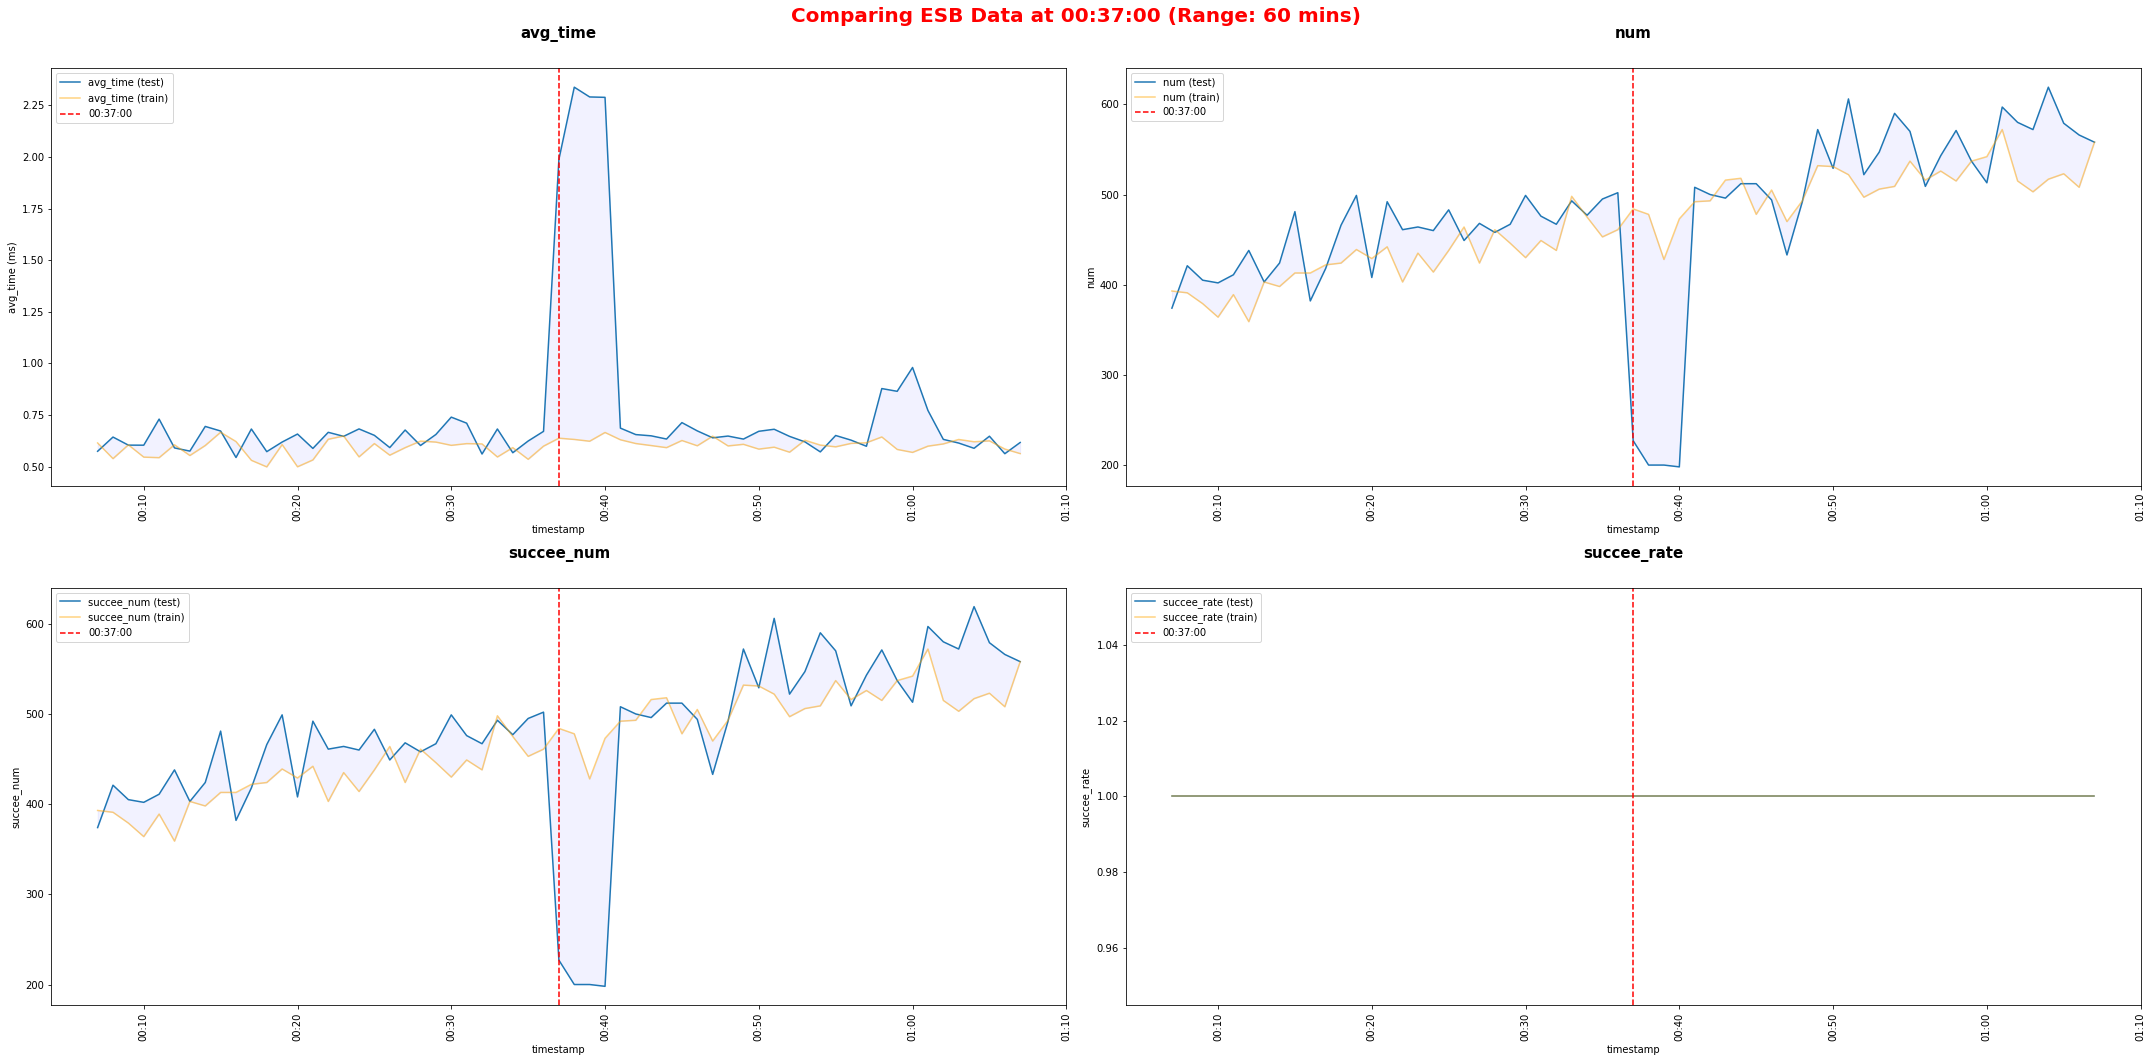

In [14]:
seconds_past = 2220
a, b = compare_esb(seconds_past, interval=60)

In [15]:
del a, b
gc.collect()

14317

#### Host Indicators

<b>Analysis:</b>
Given that `Sent_queue` is a host KPI to observe for failure #1, we plot the following graph - comparing `Sent_queue` values across 70 mins (corresponding to 14 data points) and against the train data for the same time period.

We observe that the `Sent_queue` value peaked right after the failure time (00:37:00), before returning back to normal after some time. `Sent_queue` represents the number of service requests being queued for processing. Combining this observation with our previous speculation (in `ESB Indicators`), we can confirm that the failure involves a virtual machine that hosts the app services in the distributed system network. Therefore, the failure of `os_021` affected load balancing, causing service requests to take longer time to process and thus, fewer service requests handled in the same time period.

However, from the graph, we noticed that the accumulated requests dropped back to 0 soon after. This could mean that either the failure machine `os_021` is fixed soon after, or the remaining serviceable machines managed to process the queue. It is a possibility that the load balancing algorithm adjusted itself, or the remaining machines scaled up vertically (to handle more requests in 1 machine) or horizontally (by spinning up another temporary machine to aid). The reason for this is not part of our analysis in Assignment 2.

In conclusion, we note that a possible failure could involve the virtual machine hosting the services. Such failures, although would not affect the service's success rate, would affect its latency and lead to slower execution. To identify these problems during production, we can observe for any drastic / abnormal increase in the operating system's `Sent_queue` metrics.

In [16]:
test_host = read_host("test_data", "os_linux", verbose=False)
train_host = read_host("train_data/2020_05_04", "os_linux", verbose=False)

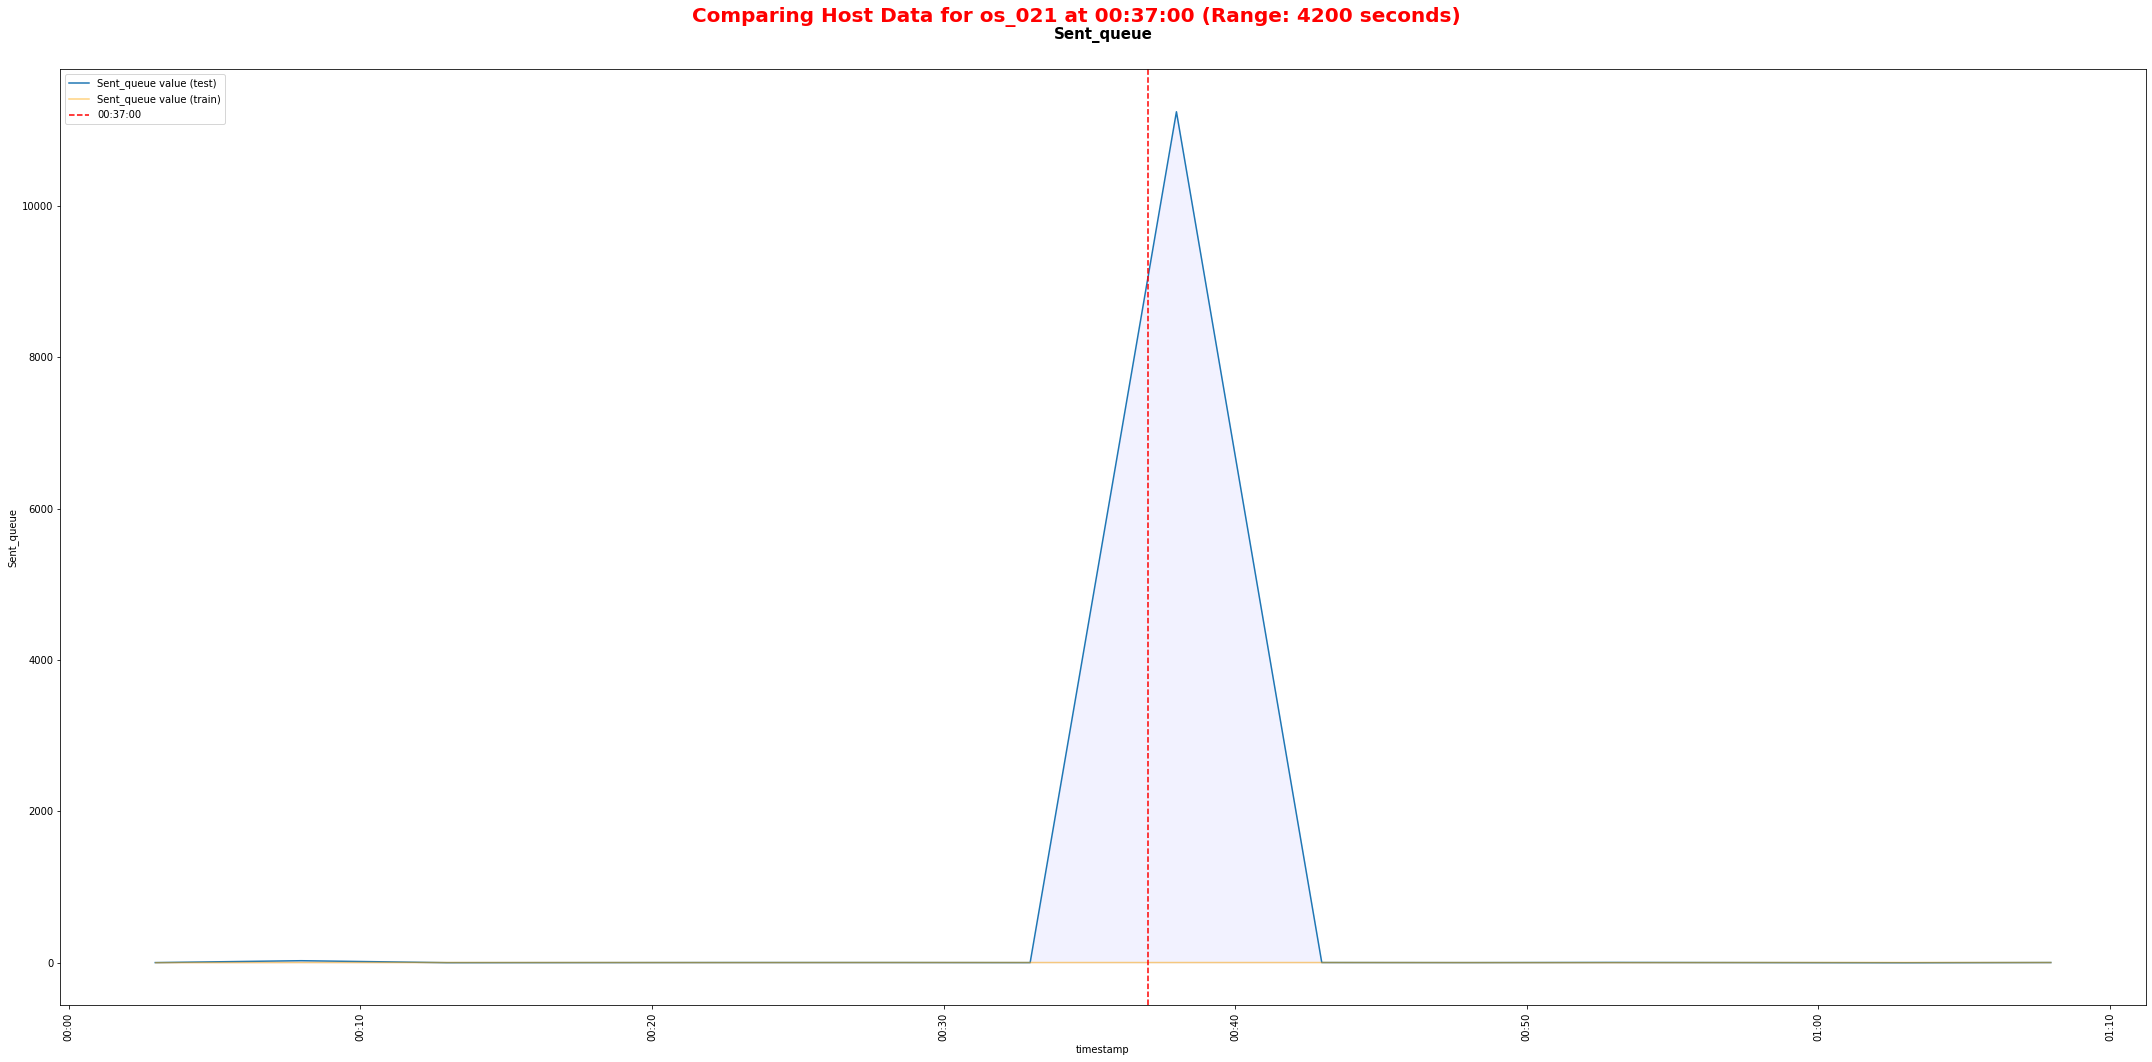

In [17]:
# From data analysis, we know that Sent_queue for os_021 is recorded in 5 mins interval
# Therefore, we select interval = 2 * 7 * 5 mins for 14 data points
test_host_compared, train_host_compared = compare_host(test_host=test_host,
                                                        train_host=train_host,
                                                        seconds_past=seconds_past,
                                                        cmdb_id='os_021',
                                                        name='Sent_queue',
                                                        interval=2*7*5*60)

In [18]:
del test_host_compared, train_host_compared
del test_host, train_host
gc.collect()

3807

#### Trace Indicators

<b>Analysis:</b>
Since we know that `os_021` has a failure, we will plot the following graphs - (1) comparing the length of trace data, (2) comparing the elapsed time of the parent processes for `os_021`, (3) comparing the elapsed time of the parent processes for `os_022`

These graphs' time period are carefully chosen to ensure that long-elapse-time functions are shown and there are ample data before & after to ascertain the trend.

From the graphs, we can tell that:
1. Number of trace invocations (trace length) remained roughly the same despite failure
2. `os_021` experienced a distinct increase in elapsed time as compared to train_data and `os_022` (for the same time period)
3. `os_022` did not exeperience any change in elapsed time

Finding 1: `osb_001` is the parent of `csf_001` (thus, `osb_001` is always larger than `csf_001`)
However, given that `osb` is the inside span while `csf` is the outside span, this meant that `osb - csf` will give us the actual time for `osb`. This prompts us to write a code to generate the actual time for each trace. 

The logic of the code lies in that every trace will start with the inner span followed by 1 or more outer span childrens. Therefore, the actual time should be interpreted as:
1. For inner spans: time taken to run the code inside the services
2. For outer spans: time taken to for the code to "perform context switch" to the service (or maybe push data to stack)

Subsequently, we sampled for 100 traceIDs (since 100 is a large sample size for approximation) from both the train and test data to:
1. Calculate actual time taken for each process ID, combining them through a unique identifier (in the format of `cmdb_id:serviceName:dsName`)
2. Find out the average time taken across all 100 traceIDs for their respective 
3. Merge the train and test dataframe to compute their differences (where possible)

From the output of the above step, we notice that:
1. `os_021:osb_001:nan`	has the largest difference of 2953.70 (vary due to `sample`)
2. `os_021:csf_001:nan`	has the 2nd largest difference of 1189.69 (vary due to `sample`)

Therefore, we can conclude that the failure of `os_021` can be attributed to the large increase in time taken to execute the `osb_001` code. Additionally, since `csf_001` is the outer span and child of `osb_001`, we can conclude that there is a large increase in time to pass control to other microservices called by `osb_001`.

<b>What this means to the developer:</b>
Code review should be performed on `osb_001` to understand the cause for the increase in time taken to execute the code and call other microservices. Relating this back to the Host Indicators, we can suspect that the code cannot handle an increase in requests (i.e. `Sent_queue` increased sharply) well. 

<b>What this means to site reliability engineer / ML engineer:</b>
We can potentially detect virtual machine failure by observing the `osb_001` and `csf_001` metrics, for large increase in execution time.

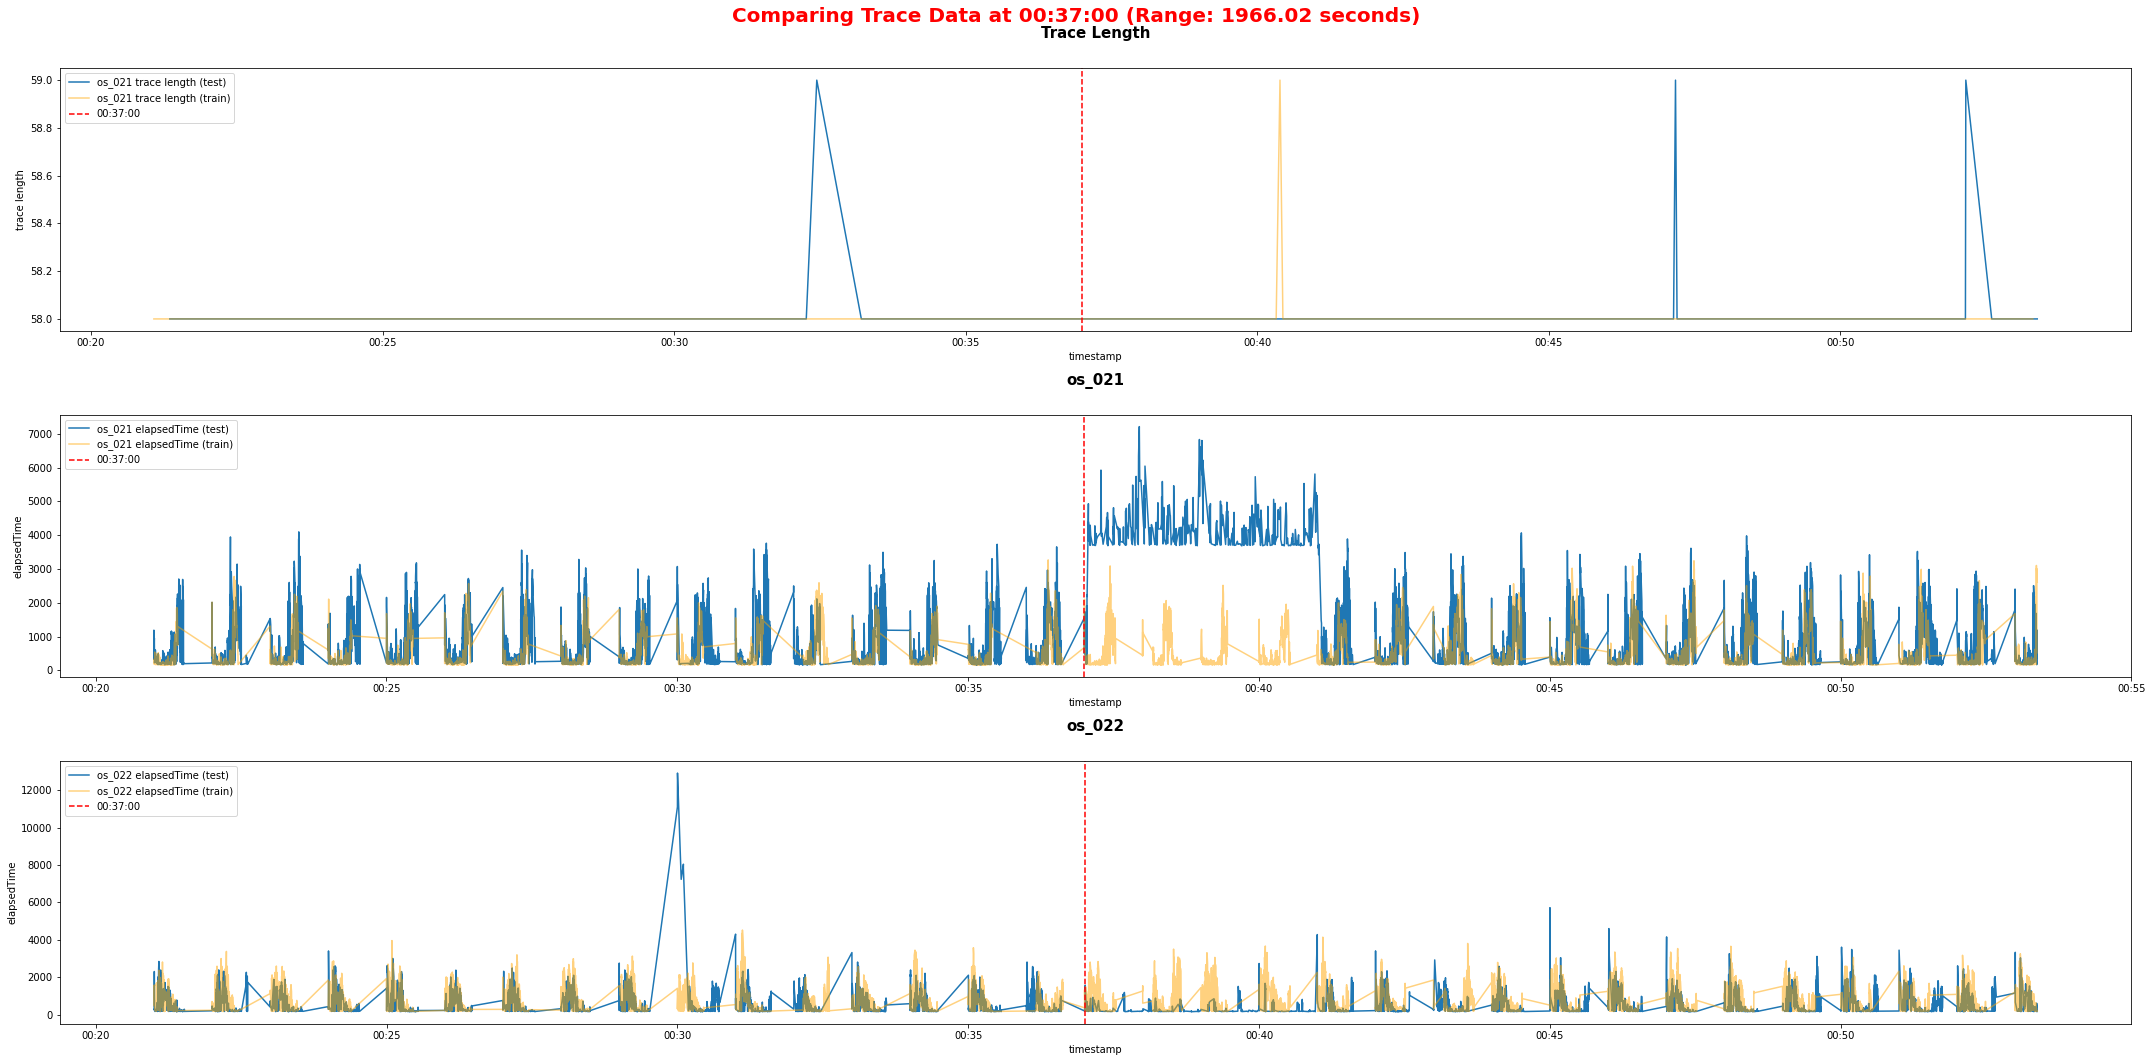

In [19]:
test_trace_filtered, train_trace_filtered, \
test_trace_length_list, train_trace_length_list, \
test_trace_filtered_parent_os_021, train_trace_filtered_parent_os_021, \
test_trace_filtered_parent_os_022, train_trace_filtered_parent_os_022 = \
compare_trace_for_failure(test_trace, train_trace, seconds_past=seconds_past)

<b>Finding the root cause for the slower processing speed</b>

In [20]:
cumulative = compare_trace_childrens_failure1(test_trace_filtered, train_trace_filtered, test_trace_filtered_parent_os_021, train_trace_filtered_parent_os_021)
pd.set_option('display.max_rows', None)
cumulative

unique_identifier  train_actual_time  test_actual_time  \
46                 os_021:osb_001:None              15.92           2957.62   
45                 os_021:csf_001:None               8.09           1229.55   
2              docker_003:csf_001:None              18.27             80.27   
19             docker_004:csf_001:None              19.07             48.37   
1               docker_003:None:db_009               7.30             19.74   
5              docker_003:csf_004:None               4.19             15.41   
9   docker_003:local_method_002:db_009               2.97             13.74   
6              docker_003:csf_005:None               2.69             12.99   
4              docker_003:csf_003:None               2.34             12.44   
11  docker_003:local_method_004:db_009               5.85             15.11   
3              docker_003:csf_002:None               6.45             14.43   
33  docker_004:local_method_010:db_007               2.70              8.50   
18              docker_004:None:db_009               8.38             13.62   
8   docker_003:local_method_001:db_009               0.43              5.44   
7       docker_003:fly_remote_001:None               3.09              7.94   
20             docker_004:csf_002:None               3.17              7.44   
13  docker_003:local_method_006:db_009               1.74              5.96   
10  docker_003:local_method_003:db_009               0.82              4.64   
0               docker_003:None:db_007               2.79              6.35   
22             docker_004:csf_004:None               2.85              6.22   
17              docker_004:None:db_007               4.01              7.19   
16  docker_003:local_method_010:db_007               0.87              3.84   
26  docker_004:local_method_002:db_009               2.71              5.33   
21             docker_004:csf_003:None               4.14              6.53   
25  docker_004:local_method_001:db_009               0.39              2.71   
23             docker_004:csf_005:None               3.53              5.74   
28  docker_004:local_method_004:db_009               3.20              5.35   
32  docker_004:local_method_009:db_009               1.32              3.12   
30  docker_004:local_method_006:db_009               2.21              3.87   
12  docker_003:local_method_005:db_009               0.90              2.53   
24      docker_004:fly_remote_001:None               2.58              4.11   
15  docker_003:local_method_009:db_009               1.66              3.15   
31  docker_004:local_method_007:db_009               0.46              0.95   
14  docker_003:local_method_007:db_009               0.51              0.76   
27  docker_004:local_method_003:db_009               0.63              0.50   
29  docker_004:local_method_005:db_009               1.70              1.54   
34              docker_006:None:db_003              24.79               NaN   
35             docker_006:csf_002:None              27.51               NaN   
36             docker_006:csf_003:None              14.48               NaN   
37             docker_006:csf_004:None              13.29               NaN   
38             docker_006:csf_005:None              12.27               NaN   
39  docker_006:local_method_011:db_003               3.10               NaN   
40  docker_006:local_method_013:db_003               2.59               NaN   
41  docker_006:local_method_014:db_003               2.24               NaN   
42  docker_006:local_method_015:db_003               3.13               NaN   
43  docker_006:local_method_016:db_003               1.52               NaN   
44  docker_006:local_method_017:db_003               2.53               NaN   
47              docker_007:None:db_003                NaN             13.49   
48             docker_007:csf_002:None                NaN             14.25   
49             docker_007:csf_003:None                NaN              

In [21]:
pd.reset_option('display.max_rows')

del test_trace_filtered, train_trace_filtered, \
    test_trace_filtered_parent_os_021, train_trace_filtered_parent_os_021, \
    test_trace_filtered_parent_os_022, train_trace_filtered_parent_os_022

del cumulative

gc.collect()

11084

### Breaking Down Failure #2

Failure #2 Details:
```json
[
    6960, 
    [[
        "docker_007", 
        null
    ]]
]
```

#### ESB Indicators

<b>Analysis:</b>
From the 4 line charts, we observe that soon after the failure time (01:56:00) the success rate dipped a bit before drastically dropping. This trend is confirmed by the `num` chart and `succee_num` chart, which show the values dipping slightly (from 01:58:00 to 01:59:00) before experiencing a sharp decline (from 02:02:00 to 02:03:00). Finally, the average time taken to process the service requests also increased slightly before a sharp increment later.

From these indicators, we cannot really deduce what is the problem. However, this could be indicative of a failure that propagated to the other microservices and caused them to malfunction. In this assumption, the small dip in success rate could be due to the initial failure, that was soon fixed. However, the failure could have propagated to other microservices, leading to a domino effect and causing a large number of service requests to fail.

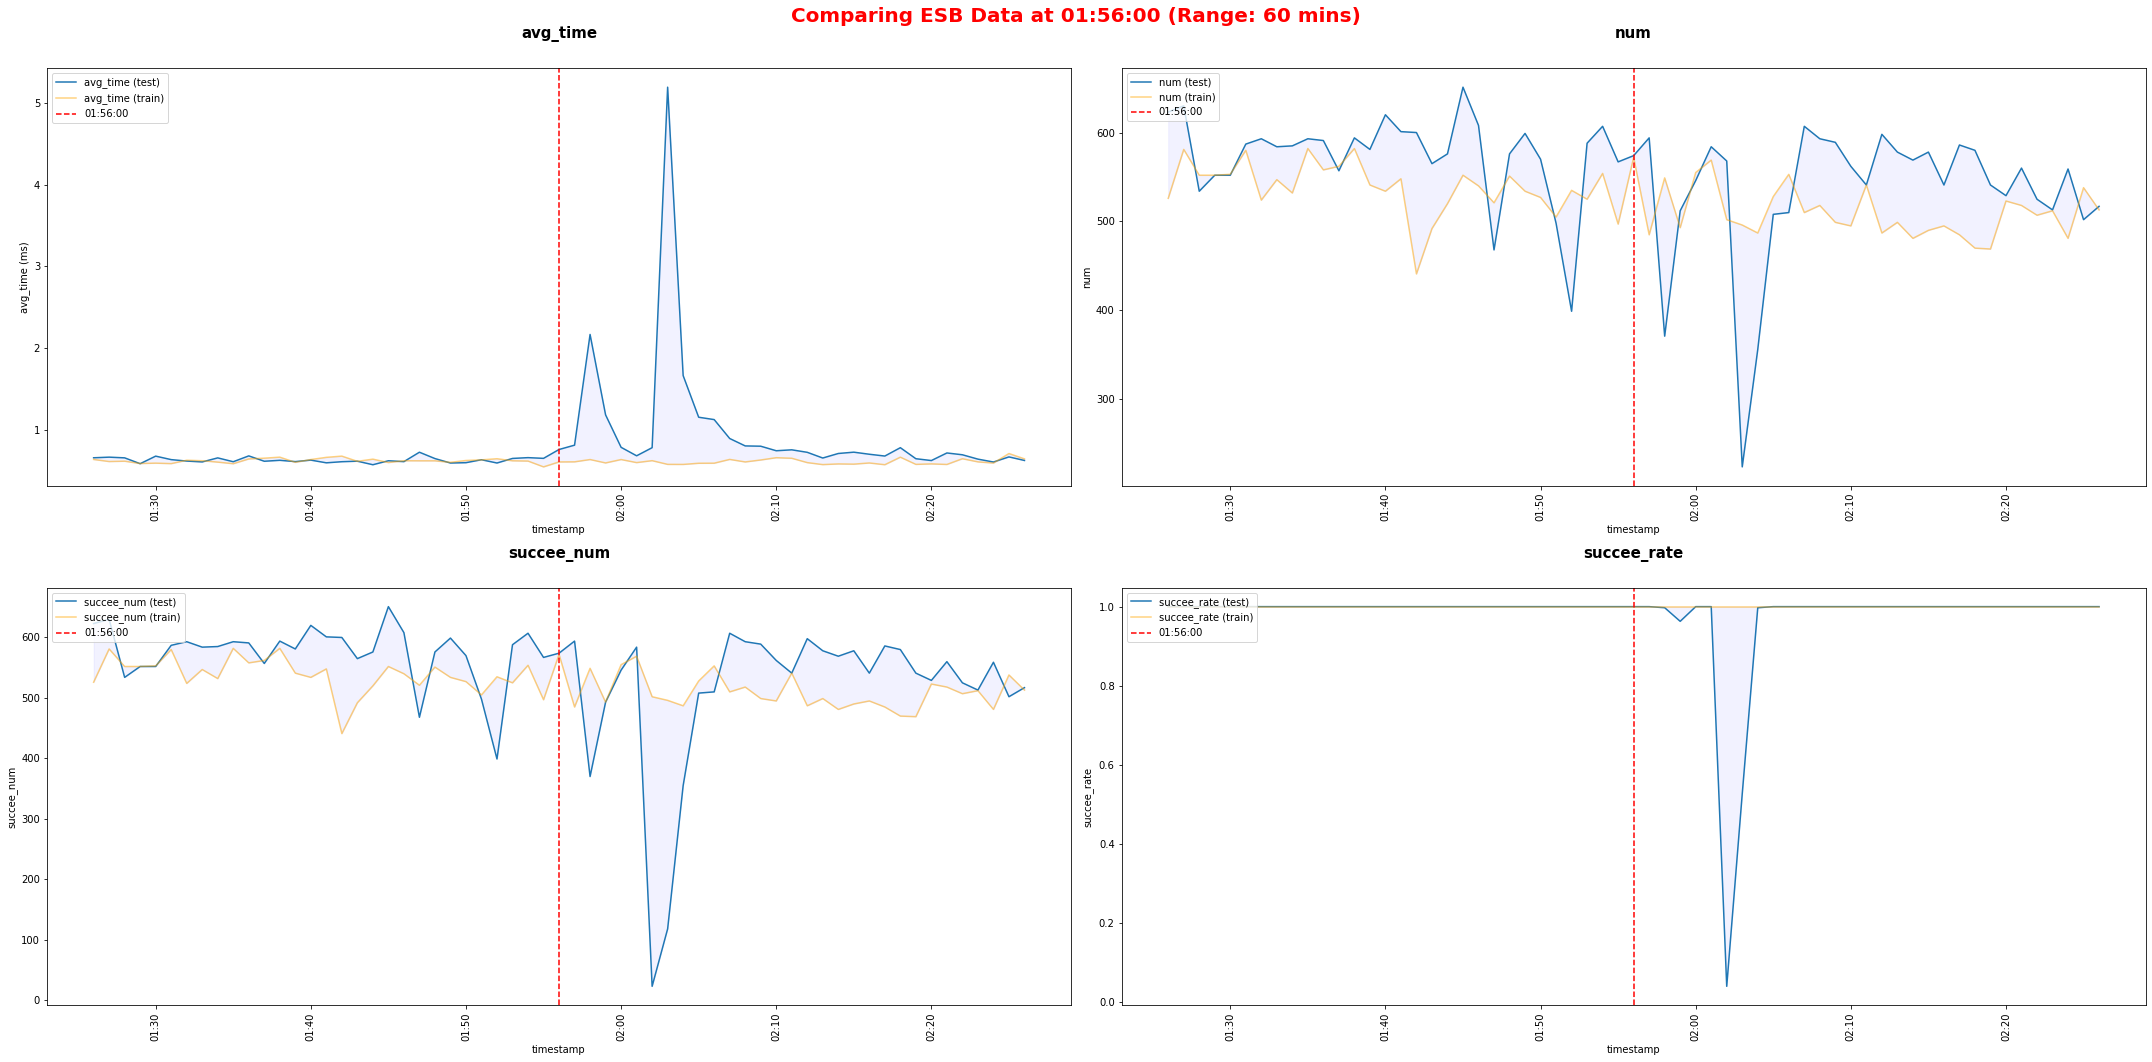

In [22]:
seconds_past = 6960
a, b = compare_esb(seconds_past, interval=60)

In [23]:
a[a.succee_rate < 1]

serviceName startTime  avg_time  num  succee_num  succee_rate
118     osb_001  01:58:00    2.1664  371         370       0.9973
119     osb_001  01:59:00    1.1802  512         493       0.9629
122     osb_001  02:02:00    0.7779  568          23       0.0405
123     osb_001  02:03:00    5.1987  224         118       0.5268
124     osb_001  02:04:00    1.6619  356         355       0.9972

In [24]:
del a, b
gc.collect()

13944

#### Host Indicators

FYI: From `cmdb.xlsx`, `docker_007` is also mapped to `os_019`. However, we will only check the host data in `dcos_docker.csv`

<b>Analysis:</b>
Trying out all possible `name` for `docker_007`, we note the following observations:
1. `container_cpu_used` -> Although there are fluctuations compared to train data, they do not appear anomalous when compared other dockers (i.e. `docker_006`) in test data
2. `container_mem_used` -> Although there are fluctuations compared to train data, they do not appear anomalous when compared other dockers (i.e. `docker_006`) in test data
3. `container_fgc` -> All values are 0
4. `container_fgct` -> All values are 0
5. `container_session_used` -> All values are 0
6. `container_thread_idle` -> All values are 0
7. `container_thread_running` -> All values are 0
8. `container_thread_total` -> All values are 0
9. `container_thread_used_pct` -> All values are 0

The major dips in the values were mostly observered around 02:06:00. Comparing the graphs against the ESB Indicators, we observe that these large decrease in values happen slightly after the drastic decrease in success rate. Therefore, we would suspect that they could be inter-related.

In [25]:
test_host = read_host("test_data", "dcos_docker", verbose=False)
train_host = read_host("train_data/2020_05_04", "dcos_docker", verbose=False)

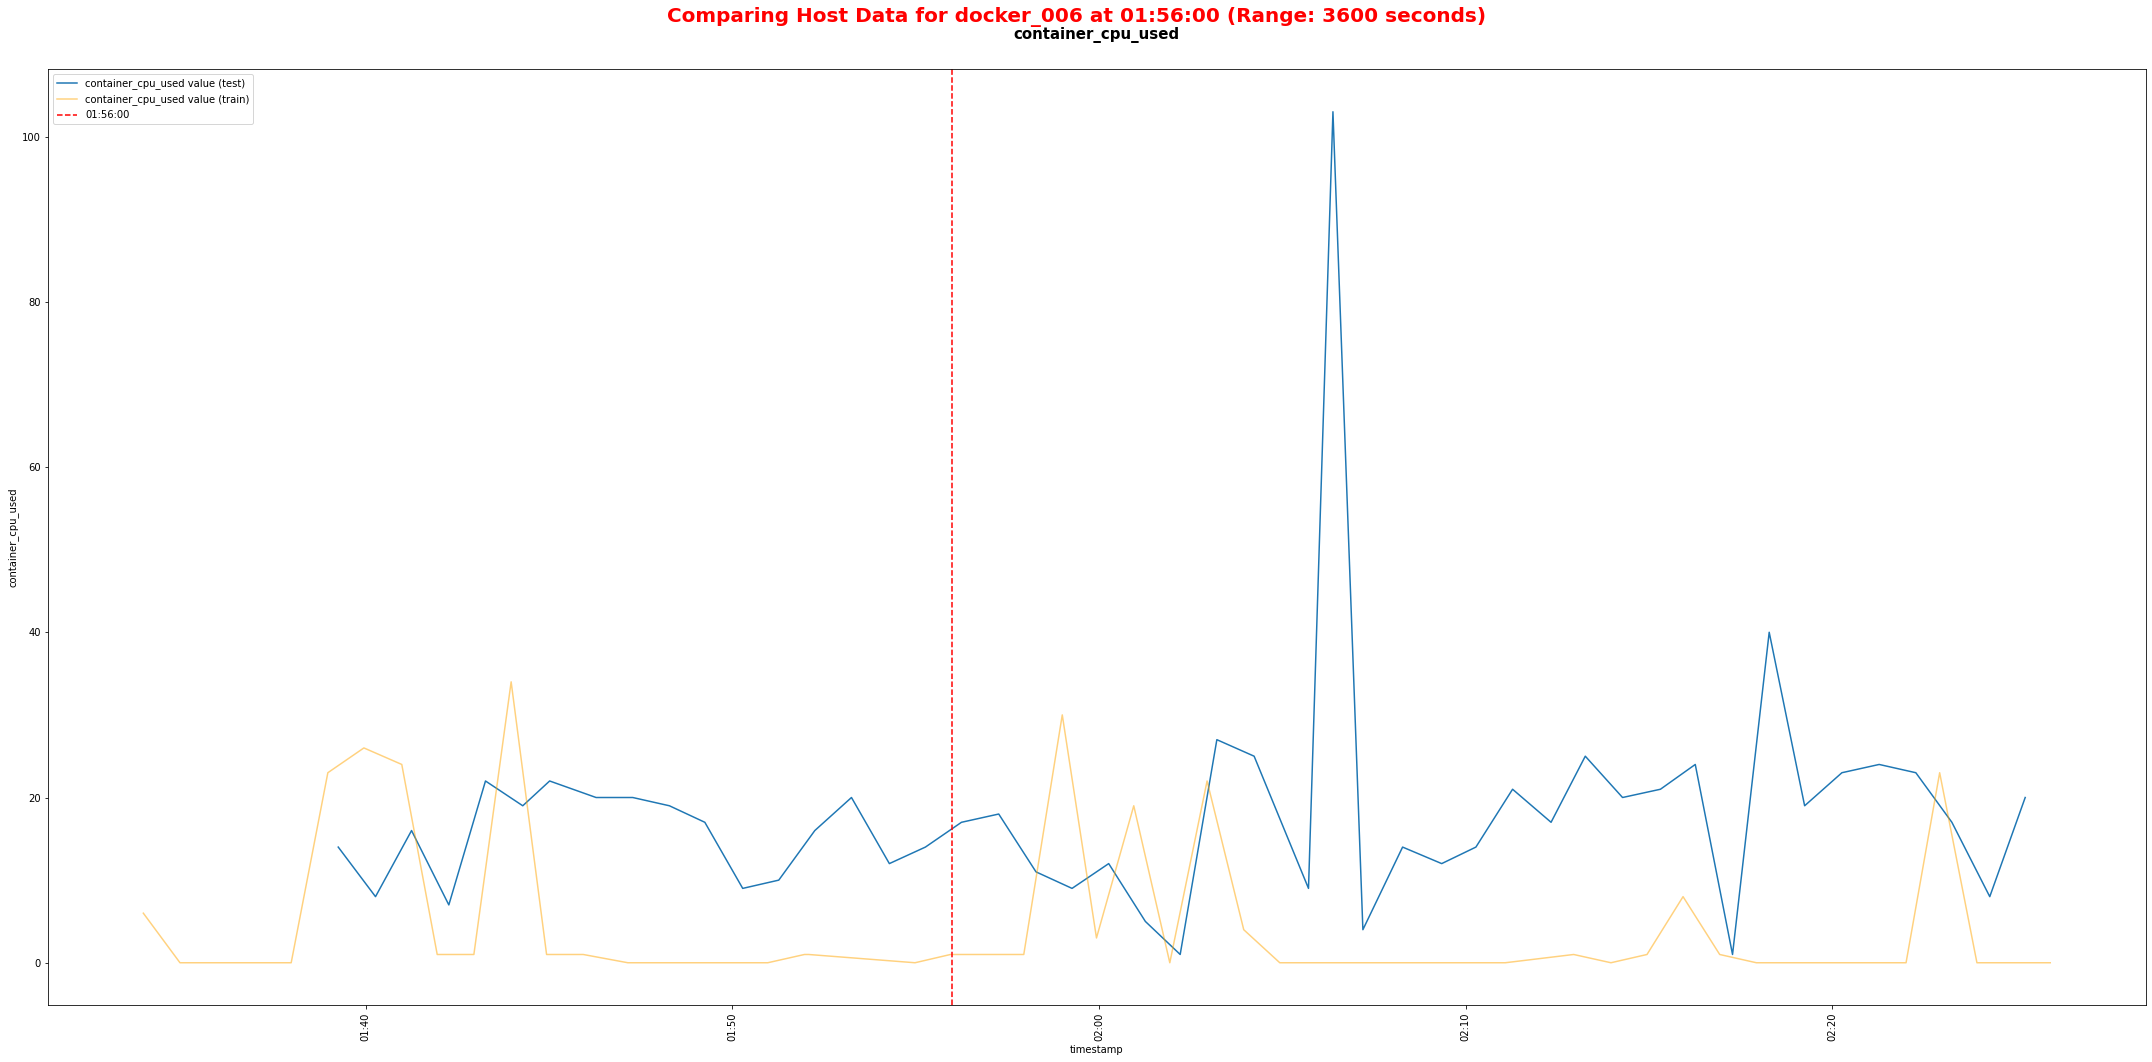

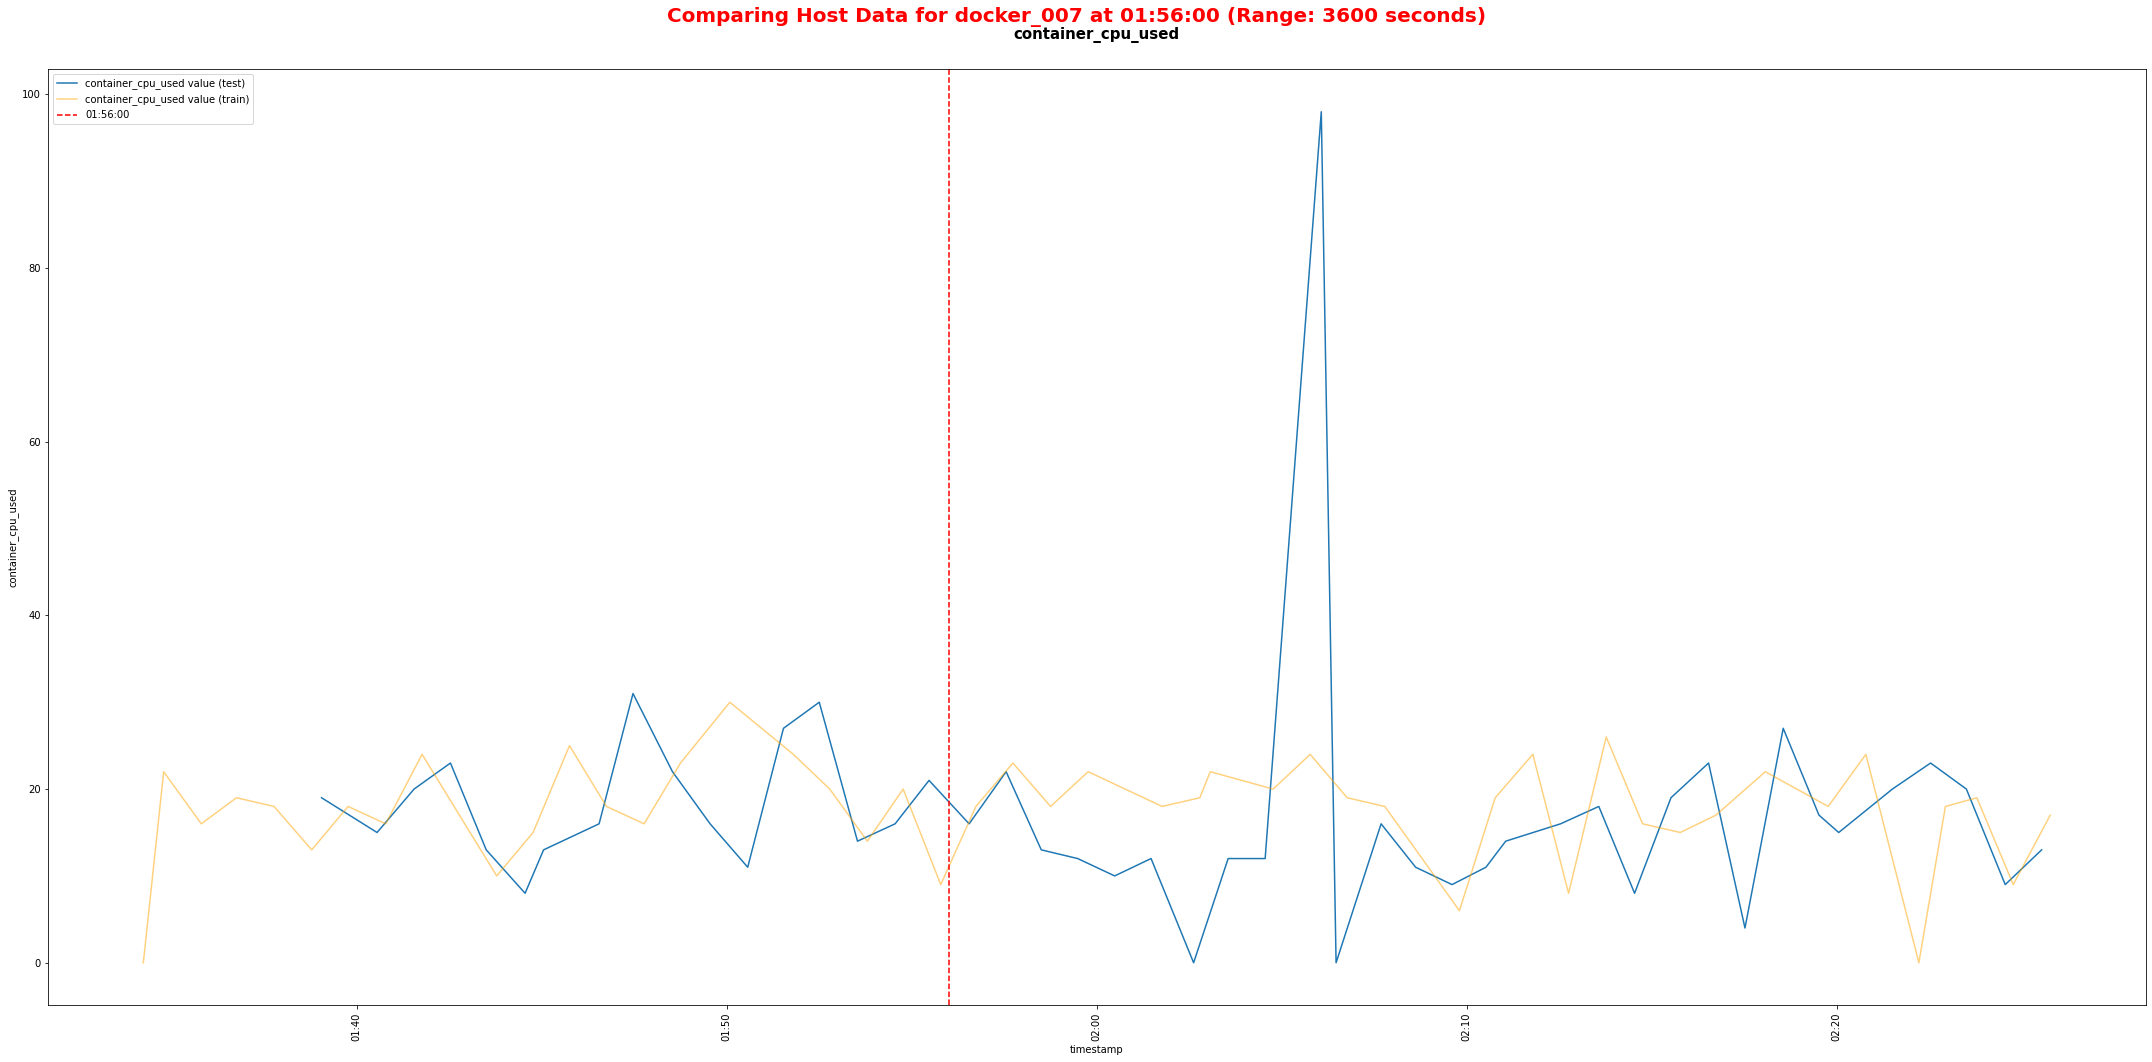

In [26]:
# In the ESB Indicator, we used 1 hour as the range. Therefore, we will use 1 hour as the interval for this case
# This allows us to visually overlap the graphs to identify any patterns

# Plot for docker_006 and docker_007
test_host_compared, train_host_compared = compare_host(test_host=test_host,
                                                        train_host=train_host,
                                                        seconds_past=seconds_past,
                                                        cmdb_id='docker_006',
                                                        name='container_cpu_used',
                                                        interval=60*60)

test_host_compared, train_host_compared = compare_host(test_host=test_host,
                                                        train_host=train_host,
                                                        seconds_past=seconds_past,
                                                        cmdb_id='docker_007',
                                                        name='container_cpu_used',
                                                        interval=60*60)

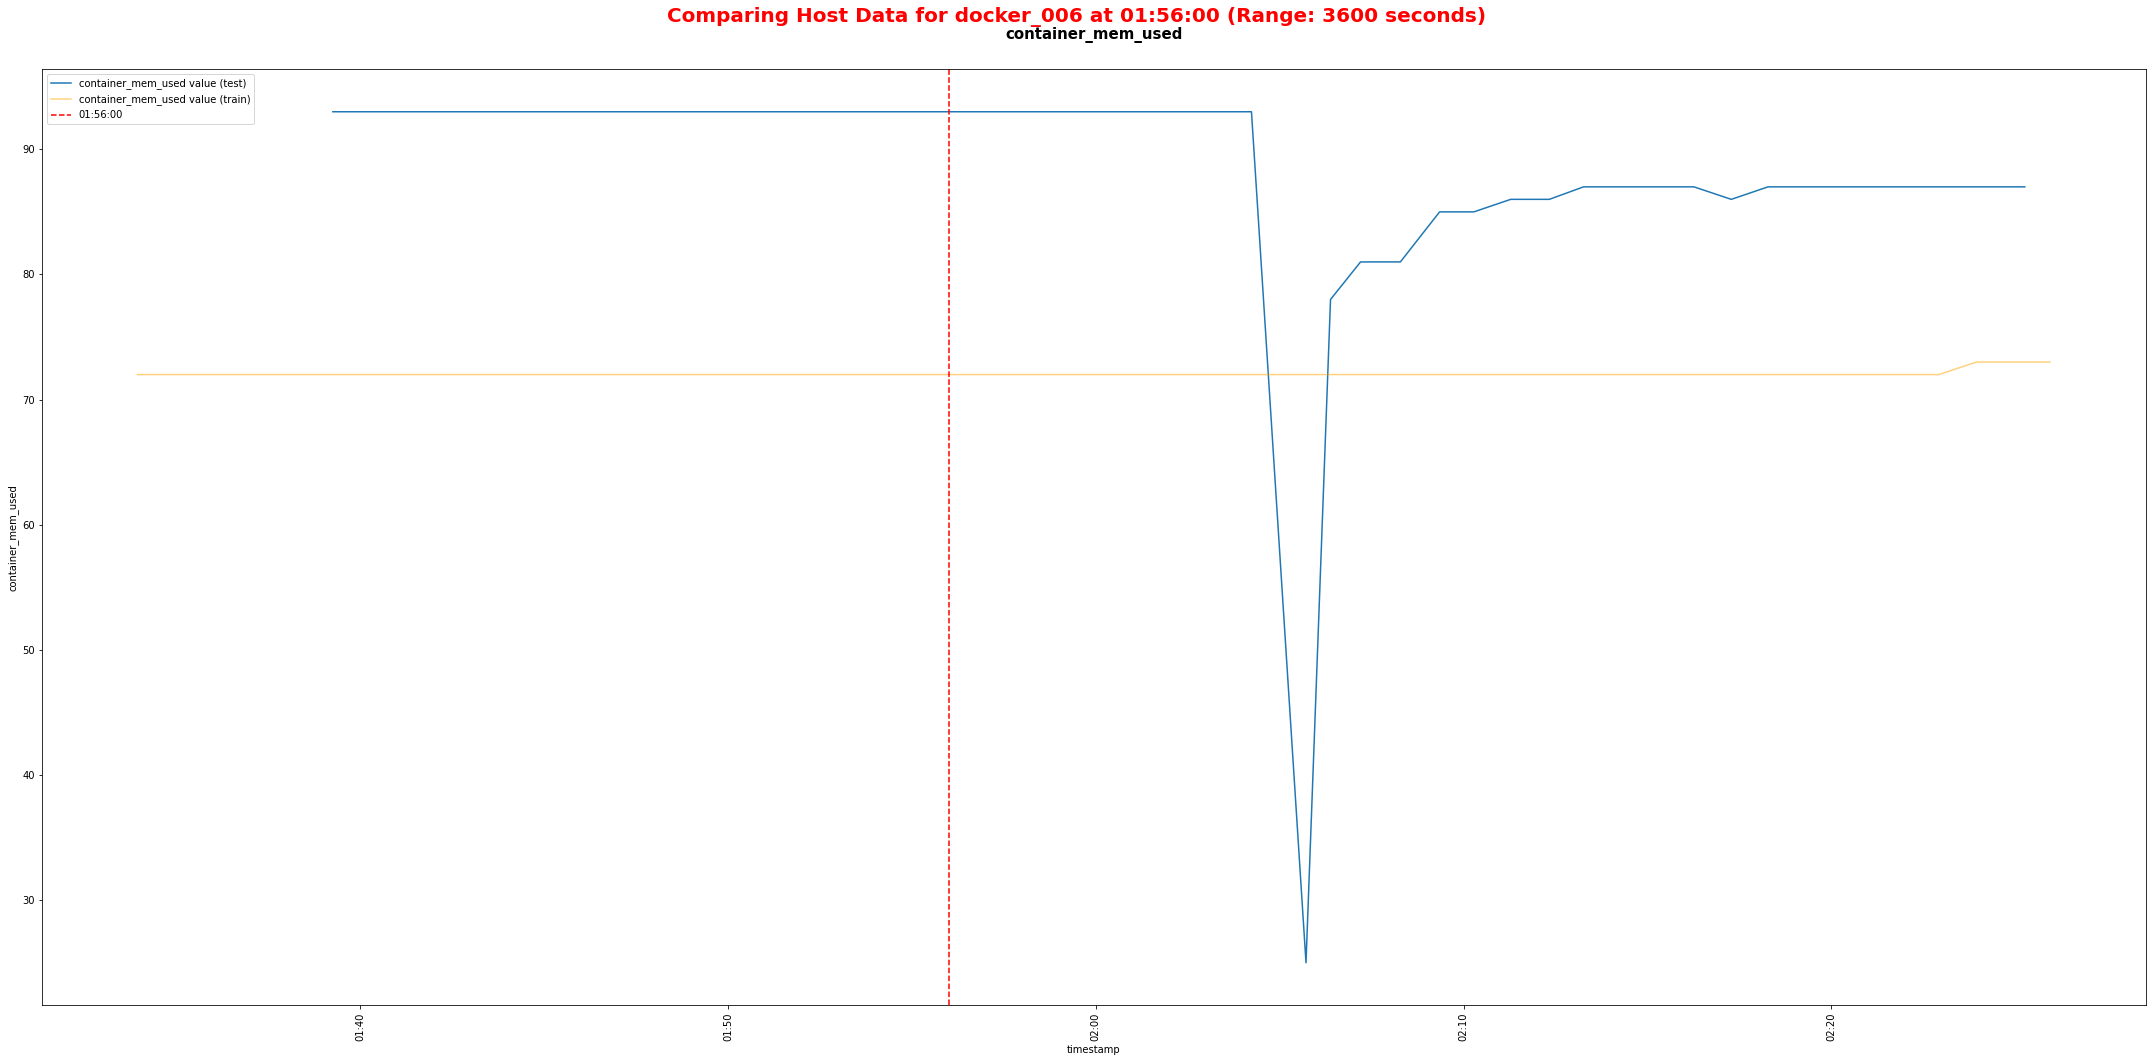

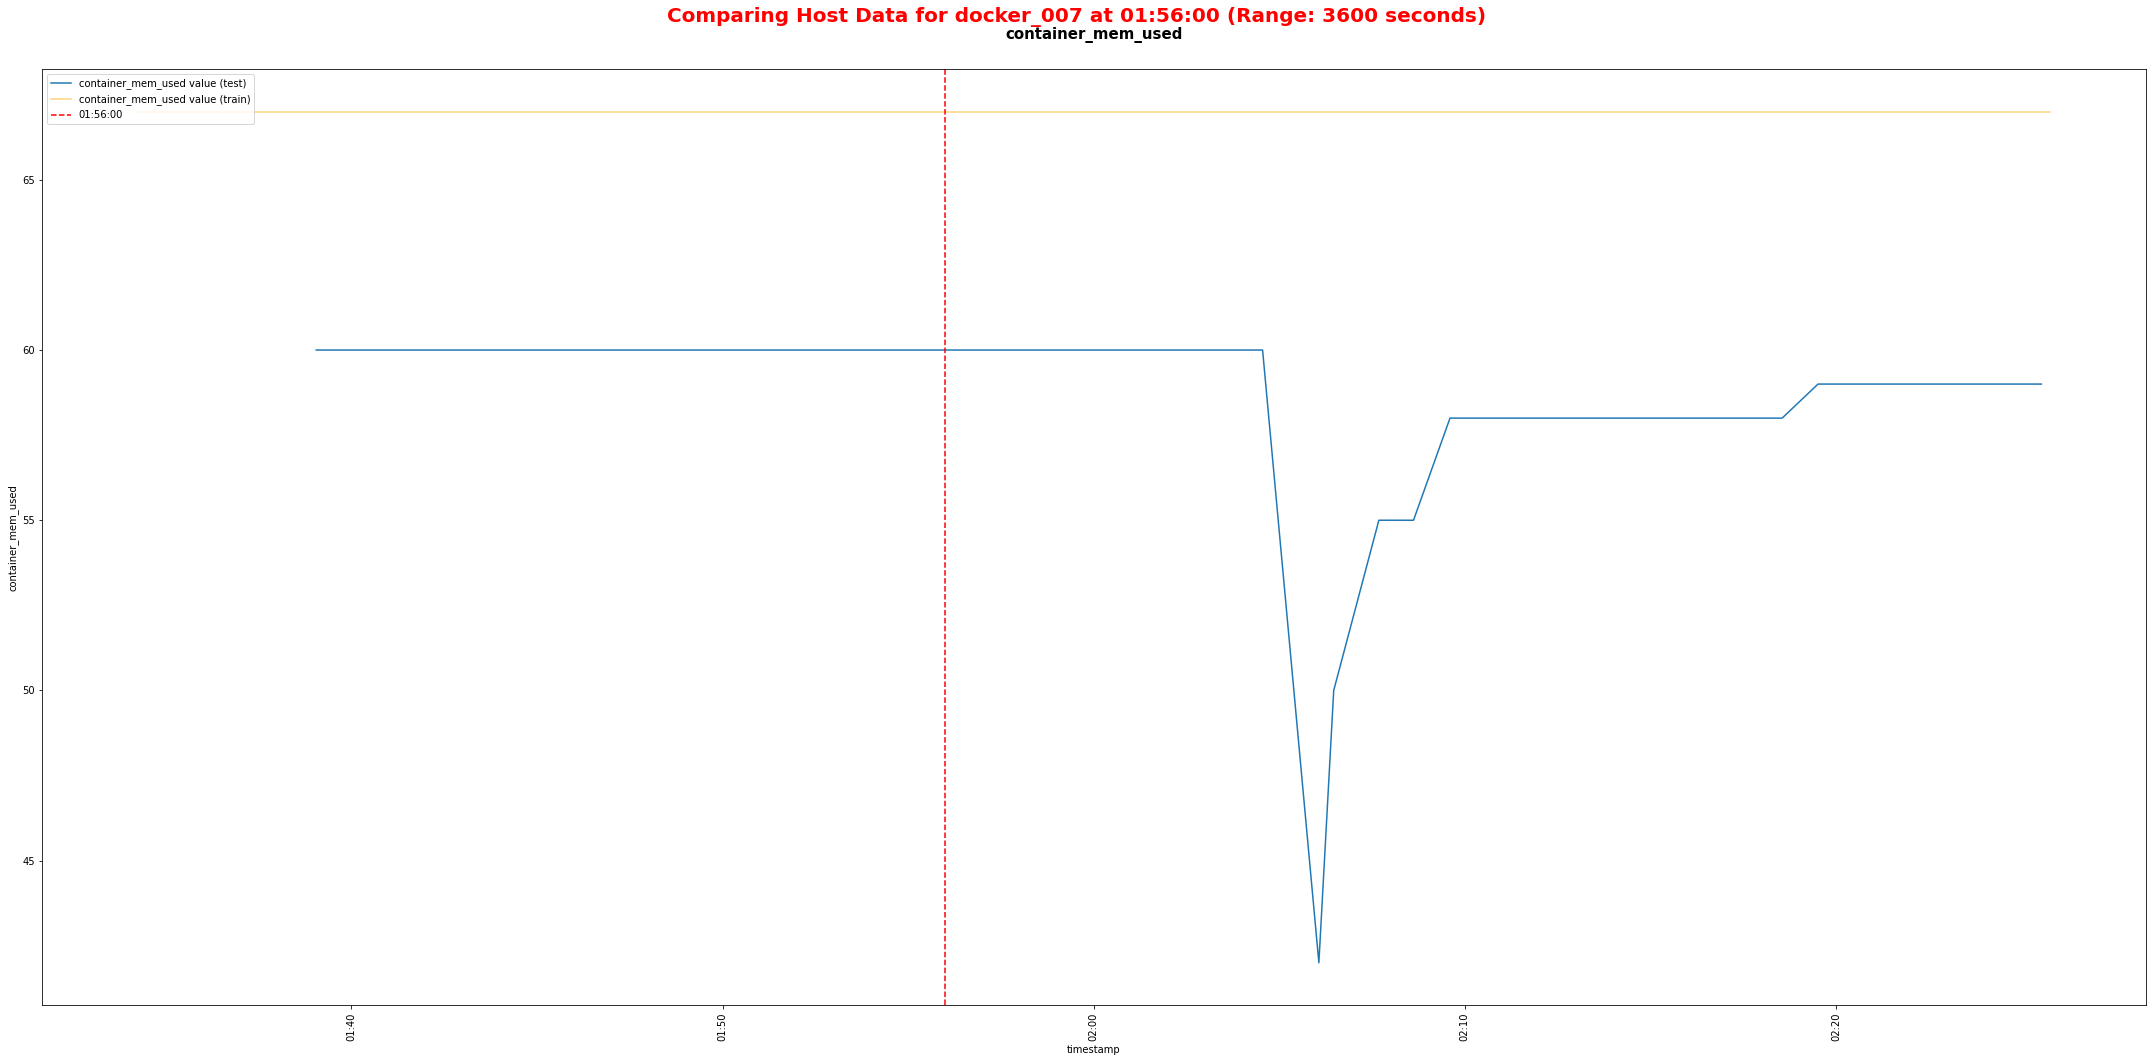

In [27]:
# In the ESB Indicator, we used 1 hour as the range. Therefore, we will use 1 hour as the interval for this case
# This allows us to visually overlap the graphs to identify any patterns

# Plot for docker_006 and docker_007
test_host_compared, train_host_compared = compare_host(test_host=test_host,
                                                        train_host=train_host,
                                                        seconds_past=seconds_past,
                                                        cmdb_id='docker_006',
                                                        name='container_mem_used',
                                                        interval=60*60)

test_host_compared, train_host_compared = compare_host(test_host=test_host,
                                                        train_host=train_host,
                                                        seconds_past=seconds_past,
                                                        cmdb_id='docker_007',
                                                        name='container_mem_used',
                                                        interval=60*60)

In [28]:
test_host_compared[test_host_compared.value < 58]

itemid                name     bomc_id timestamp  value  \
8108  999999996381307  container_mem_used  ZJ-004-060  02:06:04   42.0   
8135  999999996381307  container_mem_used  ZJ-004-060  02:06:28   50.0   
8216  999999996381307  container_mem_used  ZJ-004-060  02:07:41   55.0   
8279  999999996381307  container_mem_used  ZJ-004-060  02:08:37   55.0   

         cmdb_id  
8108  docker_007  
8135  docker_007  
8216  docker_007  
8279  docker_007

In [29]:
del test_host_compared, train_host_compared
del test_host, train_host
gc.collect()

14308

#### Trace Indicators

<b>Analysis:</b>
Since we know that `docker_007` has a failure and that all traceId begin from a root process that must start from either `os_021` or `os_022` (refer to Data Exploration's Finding #6), we will plot the following graphs - (1) comparing the length of trace data, (2) comparing the elapsed time of the parent processes for `os_021`, (3) comparing the elapsed time of the parent processes for `os_022`

These graphs' time period are carefully chosen to ensure that long-elapse-time functions are shown and there are ample data before & after to ascertain the trend.

From the graphs, we can tell that:
1. Number of trace invocations (trace length) remained roughly the same, except from 02:02:00 to 02:03:00 (time may change due to sampling)
2. `os_021` experienced (1) a distinct fluctuation in elapsed time (even going negative) as compared to train_data and `os_022` (for the same time period), (2) higher elapsed time around 01:59:00 and 02:03:00
3. `os_022` experienced (1) lower call frequency around 01:59:00 and 02:02:00, (2) higher elapsed time around 02:00:00 and 02:03:00

<b>Finding 1: Most traceIds contain traces from different dockers e.g. `docker_003`, `docker_004`, `docker_006`, etc</b>

However, `docker_007` is more similar to `docker_005` to `docker_008` than `docker_001` to `docker_004`. Therefore, this will shape the logic subsequently, when we compared the docker metrics across to detect anomalies.

Subsequently, we sampled for 100 traceIDs (since 100 is a large sample size for approximation) from both the train and test data to:
1. Calculate actual time taken for each process ID, combining them through a unique identifier (in the format of `cmdb_id:serviceName:dsName`)
2. Find out the average time taken across all 100 traceIDs for their respective 
3. Merge the train and test dataframe to compute their differences (where possible)
4. Filter for `docker_006`, `docker_007`, `docker_008` in the `uniquer_identifier` (since they share similar metrics and trace calls)
5. Plot and compare their values to observe for anomalies

From the output graph of the above step, we notice that:
1. `csf_002:None` has the largest difference (vary due to `sample`)

Therefore, since `csf_002` is the outer span, we can conclude that the failure of `docker_007` can be attributed to the large increase in time to pass control to other microservices called by `csf_002`.

<b>What this means to the developer:</b>
Code review should be performed on `docker_007:csf_002:None` to understand the cause for the increase in time taken to call other microservices.

<b>What this means to site reliability engineer / ML engineer:</b>
We can potentially detect docker failure (for `docker_005` to `docker_008`) by observing the `csf_002:None` metrics, for large increase in actual time. Alternatively, we can try using trace invocation length as an additional indicator.

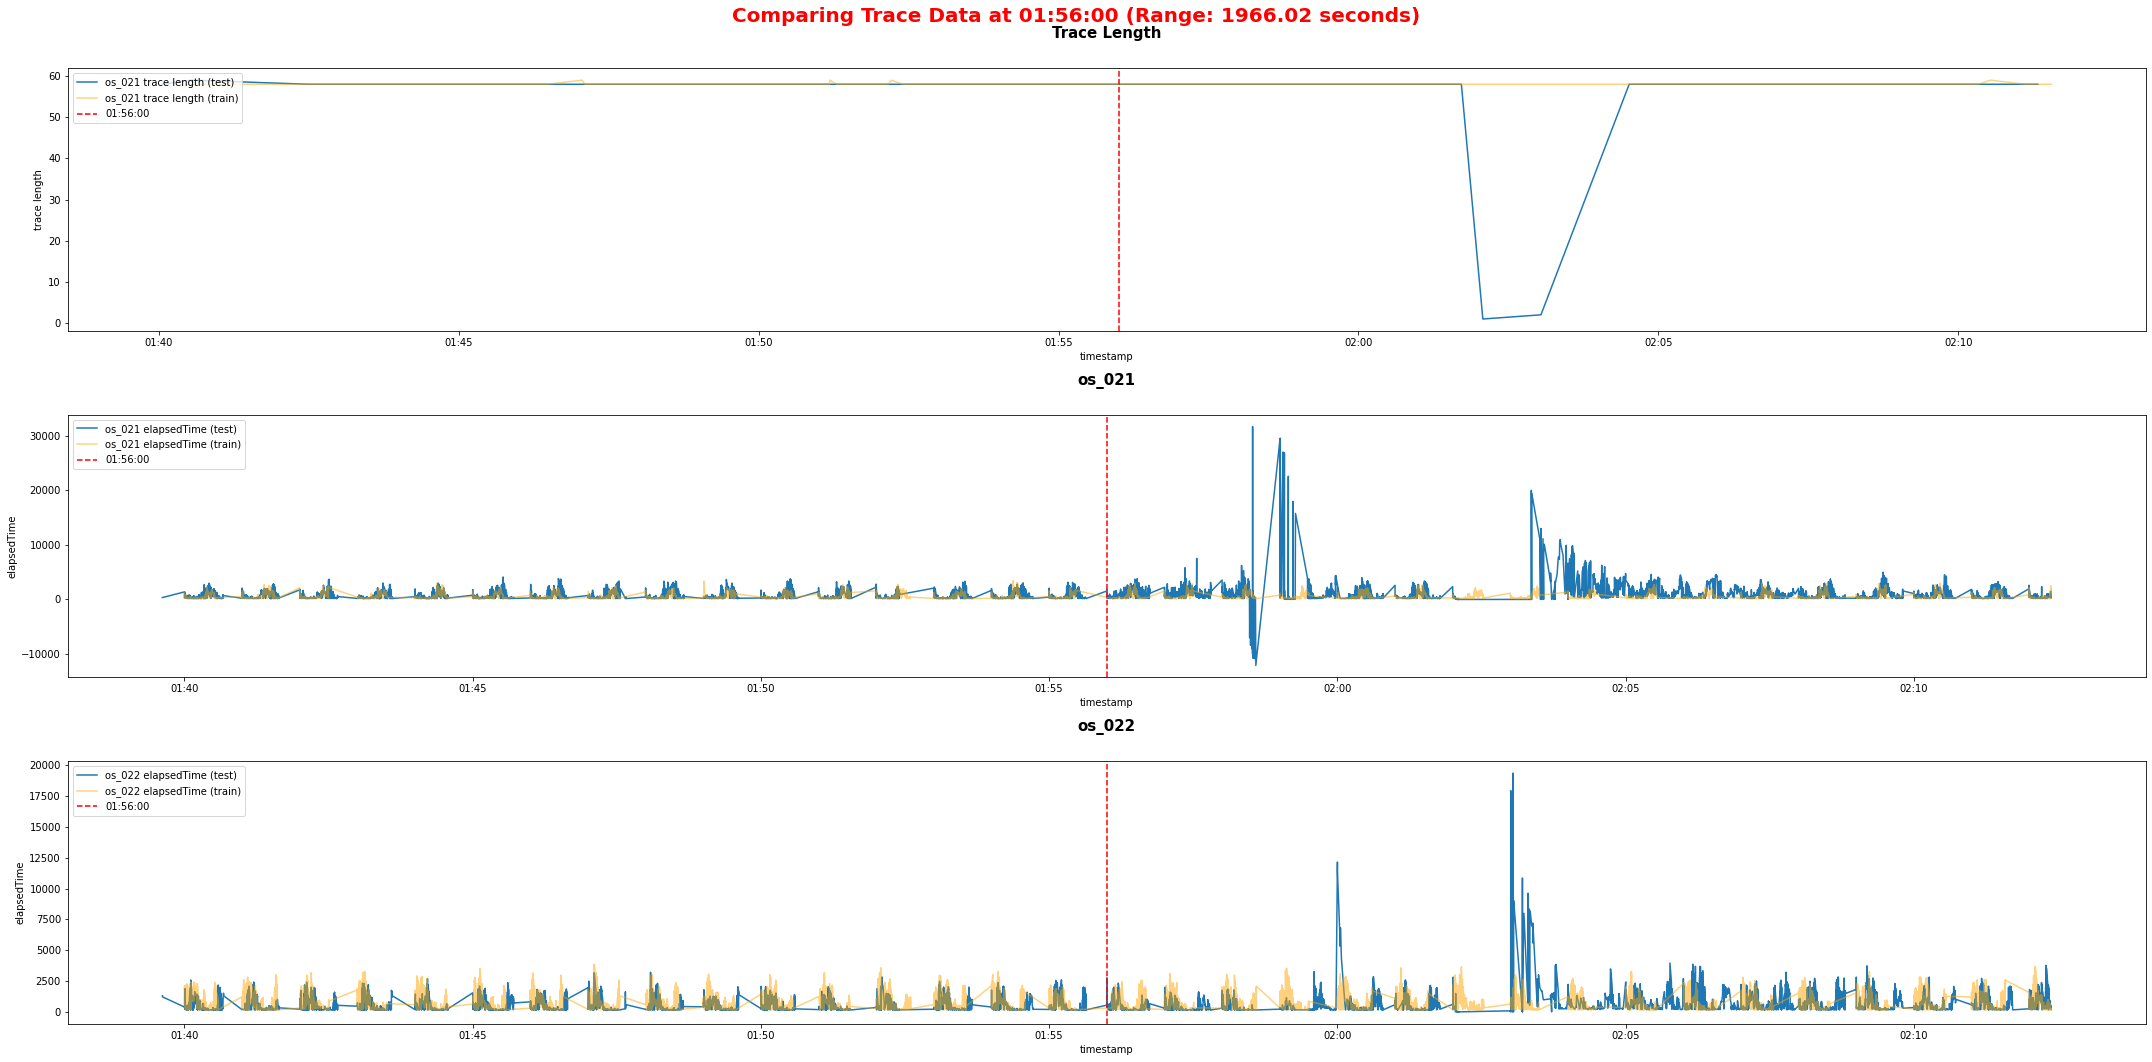

In [30]:
test_trace_filtered, train_trace_filtered, \
test_trace_length_list, train_trace_length_list, \
test_trace_filtered_parent_os_021, train_trace_filtered_parent_os_021, \
test_trace_filtered_parent_os_022, train_trace_filtered_parent_os_022 = \
compare_trace_for_failure(test_trace, train_trace, seconds_past=seconds_past)

<b>Finding the root cause for the slower processing speed</b>

In [31]:
cumulative = compare_trace_childrens_failure2(test_trace_filtered, train_trace_filtered, test_trace_filtered_parent_os_021, train_trace_filtered_parent_os_021)
pd.set_option('display.max_rows', None)
cumulative

unique_identifier  train_actual_time  test_actual_time  \
2              docker_003:csf_001:None              13.51           2288.90   
19             docker_004:csf_001:None              23.18           1501.98   
45                 os_021:csf_001:None               5.20            511.10   
6              docker_003:csf_005:None               2.04            344.64   
28  docker_004:local_method_004:db_009               7.35            213.85   
3              docker_003:csf_002:None               2.89            207.17   
11  docker_003:local_method_004:db_009               4.41            178.37   
20             docker_004:csf_002:None               5.25            177.19   
26  docker_004:local_method_002:db_009               5.33            146.87   
1               docker_003:None:db_009               5.46            121.80   
21             docker_004:csf_003:None               4.91            109.50   
9   docker_003:local_method_002:db_009               2.38            103.13   
18              docker_004:None:db_009               8.42             99.78   
22             docker_004:csf_004:None               2.58             90.28   
30  docker_004:local_method_006:db_009               3.09             90.21   
8   docker_003:local_method_001:db_009               0.28             85.20   
13  docker_003:local_method_006:db_009               1.37             77.75   
4              docker_003:csf_003:None               1.57             72.38   
33  docker_004:local_method_010:db_007               4.56             73.90   
23             docker_004:csf_005:None               2.48             70.92   
16  docker_003:local_method_010:db_007               2.11             60.25   
12  docker_003:local_method_005:db_009               0.39             49.73   
32  docker_004:local_method_009:db_009               2.10             44.76   
29  docker_004:local_method_005:db_009               0.88             43.27   
31  docker_004:local_method_007:db_009               2.61             44.04   
14  docker_003:local_method_007:db_009               0.38             41.48   
5              docker_003:csf_004:None               1.54             40.10   
17              docker_004:None:db_007               7.19             41.82   
10  docker_003:local_method_003:db_009               0.36             34.98   
15  docker_003:local_method_009:db_009               0.95             31.69   
27  docker_004:local_method_003:db_009               0.83             28.37   
25  docker_004:local_method_001:db_009               0.71             28.21   
0               docker_003:None:db_007               1.92             27.85   
24      docker_004:fly_remote_001:None               4.12             28.23   
46                 os_021:osb_001:None              15.22             39.25   
7       docker_003:fly_remote_001:None               1.85             25.67   
34              docker_006:None:db_003              24.14               NaN   
35             docker_006:csf_002:None              26.43               NaN   
36             docker_006:csf_003:None              14.46               NaN   
37             docker_006:csf_004:None              12.68               NaN   
38             docker_006:csf_005:None              11.11               NaN   
39  docker_006:local_method_011:db_003               2.29               NaN   
40  docker_006:local_method_013:db_003               2.62               NaN   
41  docker_006:local_method_014:db_003               1.74               NaN   
42  docker_006:local_method_015:db_003               2.69               NaN   
43  docker_006:local_method_016:db_003               1.76               NaN   
44  docker_006:local_method_017:db_003               2.44               NaN   
47              docker_007:None:db_003                NaN             16.48   
48             docker_007:csf_002:None                NaN             87.59   
49             docker_007:csf_003:None                NaN             2

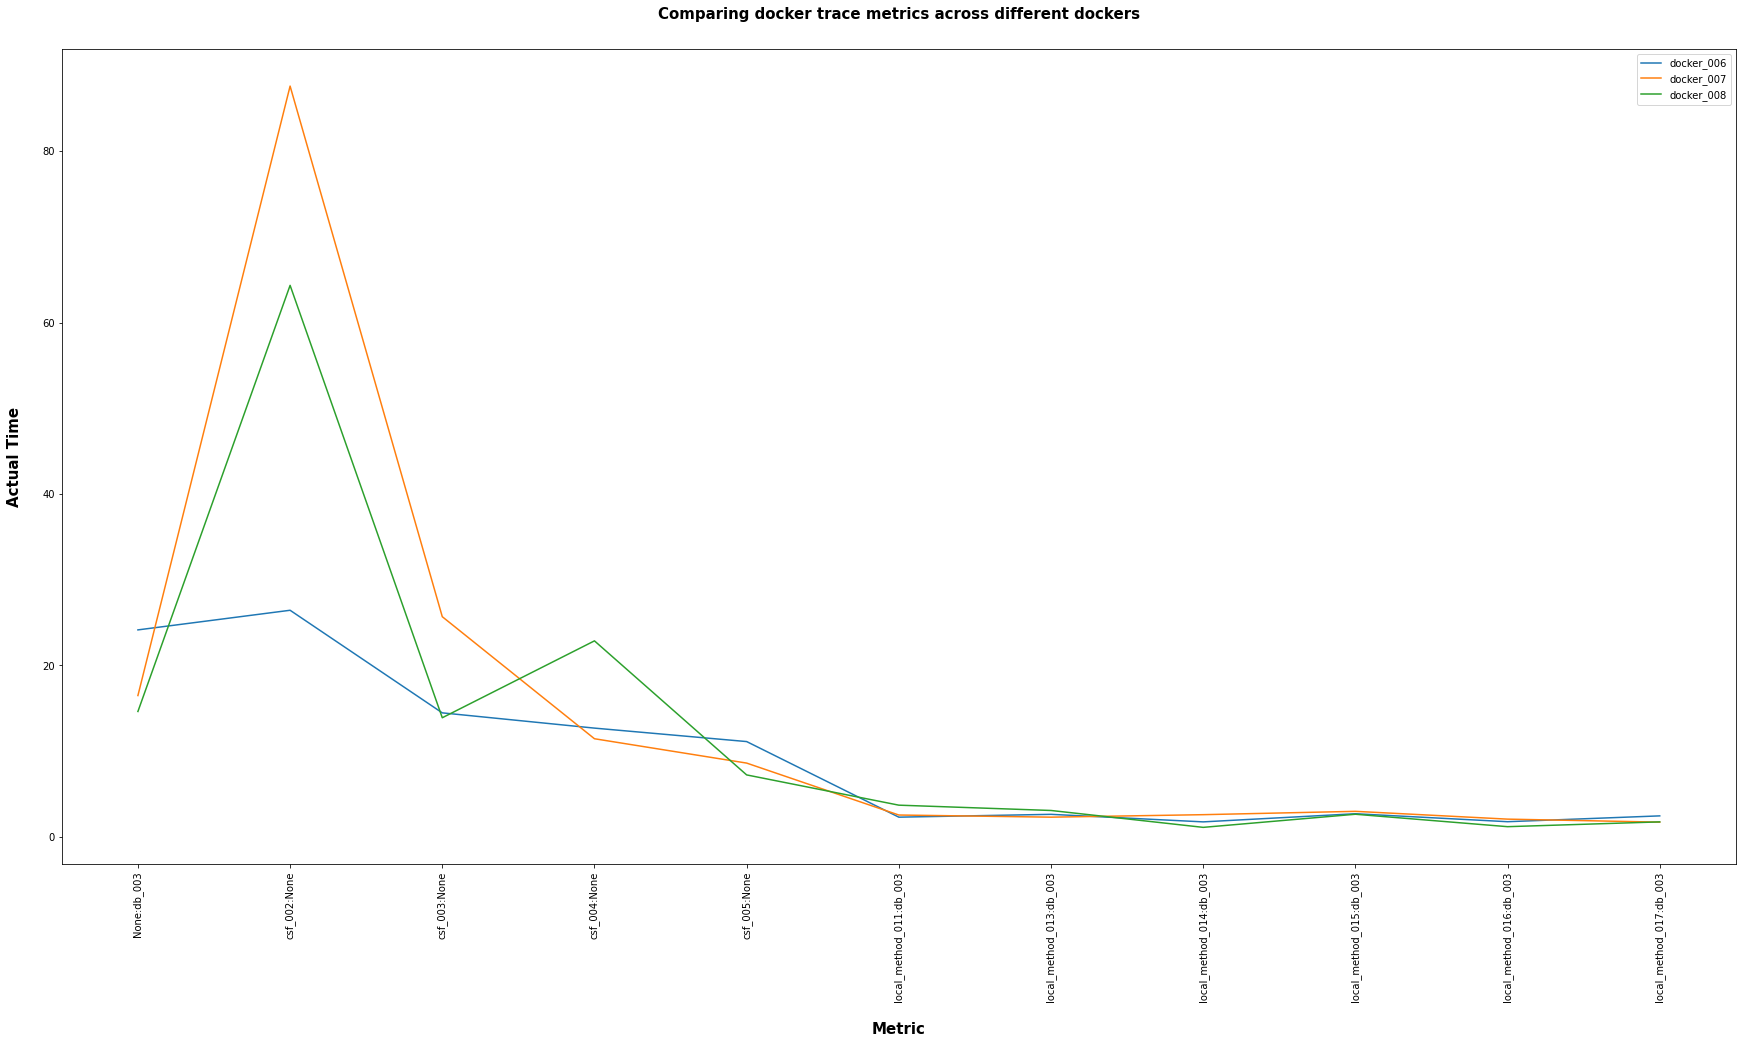

In [32]:
# Compare the metrics with docker_007 against other metrics with docker_006 or docker_008
cumulative_docker_006 = cumulative[cumulative.unique_identifier.str.contains('docker_006')]
cumulative_docker_006.unique_identifier = cumulative_docker_006.unique_identifier.str.replace('docker_006:', '')

cumulative_docker_007 = cumulative[cumulative.unique_identifier.str.contains('docker_007')]
cumulative_docker_007.unique_identifier = cumulative_docker_007.unique_identifier.str.replace('docker_007:', '')

cumulative_docker_008 = cumulative[cumulative.unique_identifier.str.contains('docker_008')]
cumulative_docker_008.unique_identifier = cumulative_docker_008.unique_identifier.str.replace('docker_008:', '')

# Plot cumulative_docker_006, cumulative_docker_007, cumulative_docker_008
fig, ax = plt.subplots(1, 1, figsize=(30, 15))

ax.plot(cumulative_docker_006.unique_identifier, cumulative_docker_006.train_actual_time, label='docker_006')
ax.plot(cumulative_docker_007.unique_identifier, cumulative_docker_007.test_actual_time, label='docker_007')
ax.plot(cumulative_docker_008.unique_identifier, cumulative_docker_008.test_actual_time, label='docker_008')

plt.xticks(rotation=90)
ax.set_title("Comparing docker trace metrics across different dockers", fontsize=15, fontweight='bold', pad=30, color='black', loc='center')
ax.set_xlabel('Metric', fontsize=15, fontweight='bold', color='black', labelpad=20)
ax.set_ylabel('Actual Time', fontsize=15, fontweight='bold', color='black', labelpad=20)
plt.legend()
plt.show()

In [33]:
pd.reset_option('display.max_rows')

del test_trace_filtered, train_trace_filtered, \
    test_trace_filtered_parent_os_021, train_trace_filtered_parent_os_021, \
    test_trace_filtered_parent_os_022, train_trace_filtered_parent_os_022

del cumulative, cumulative_docker_006, cumulative_docker_007, cumulative_docker_008

gc.collect()

11007

### Breaking Down Failure #3

Failure #3 Details:
```json
[
    12480,
    [
      ["os_017", "Recv_total"],
      ["os_017", "Send_total"]
    ]
]
```

#### ESB Indicators

<b>Analysis:</b>
From the 4 line charts, we observe that although the success rate did not change (subplot #4 remained constant at 1), the average time taken to process each service call increased sharply and the number of services requests handled decreased around the failure time period. This unusual behaviour can be noted by comparing against itself across 1 hour, as well as comparing against the train data (normal data with no failures) across the same time period. This indicates that failure #1 does not result in a failure of a service call, but could lead to other side effects such as longer call times and fewer services requests handled. This phenomenon could potentially be due to the app's error handling or simply due to poorer load balancing effects.

Given that `os_017` is the cause and since `os_017` is a virtual machine hosting the app services (2 dockers corresponding to each app), we suspect that the failure of `os_017` meant that there are fewer machines processing the service requests. Interestingly, the `num` decreased to lower than 20% of its original level despite `os_017` only making up 1 of the 4 other OS that hosts both dockers for each app. Therefore, we will need to investigate more to understand this phenomenon.

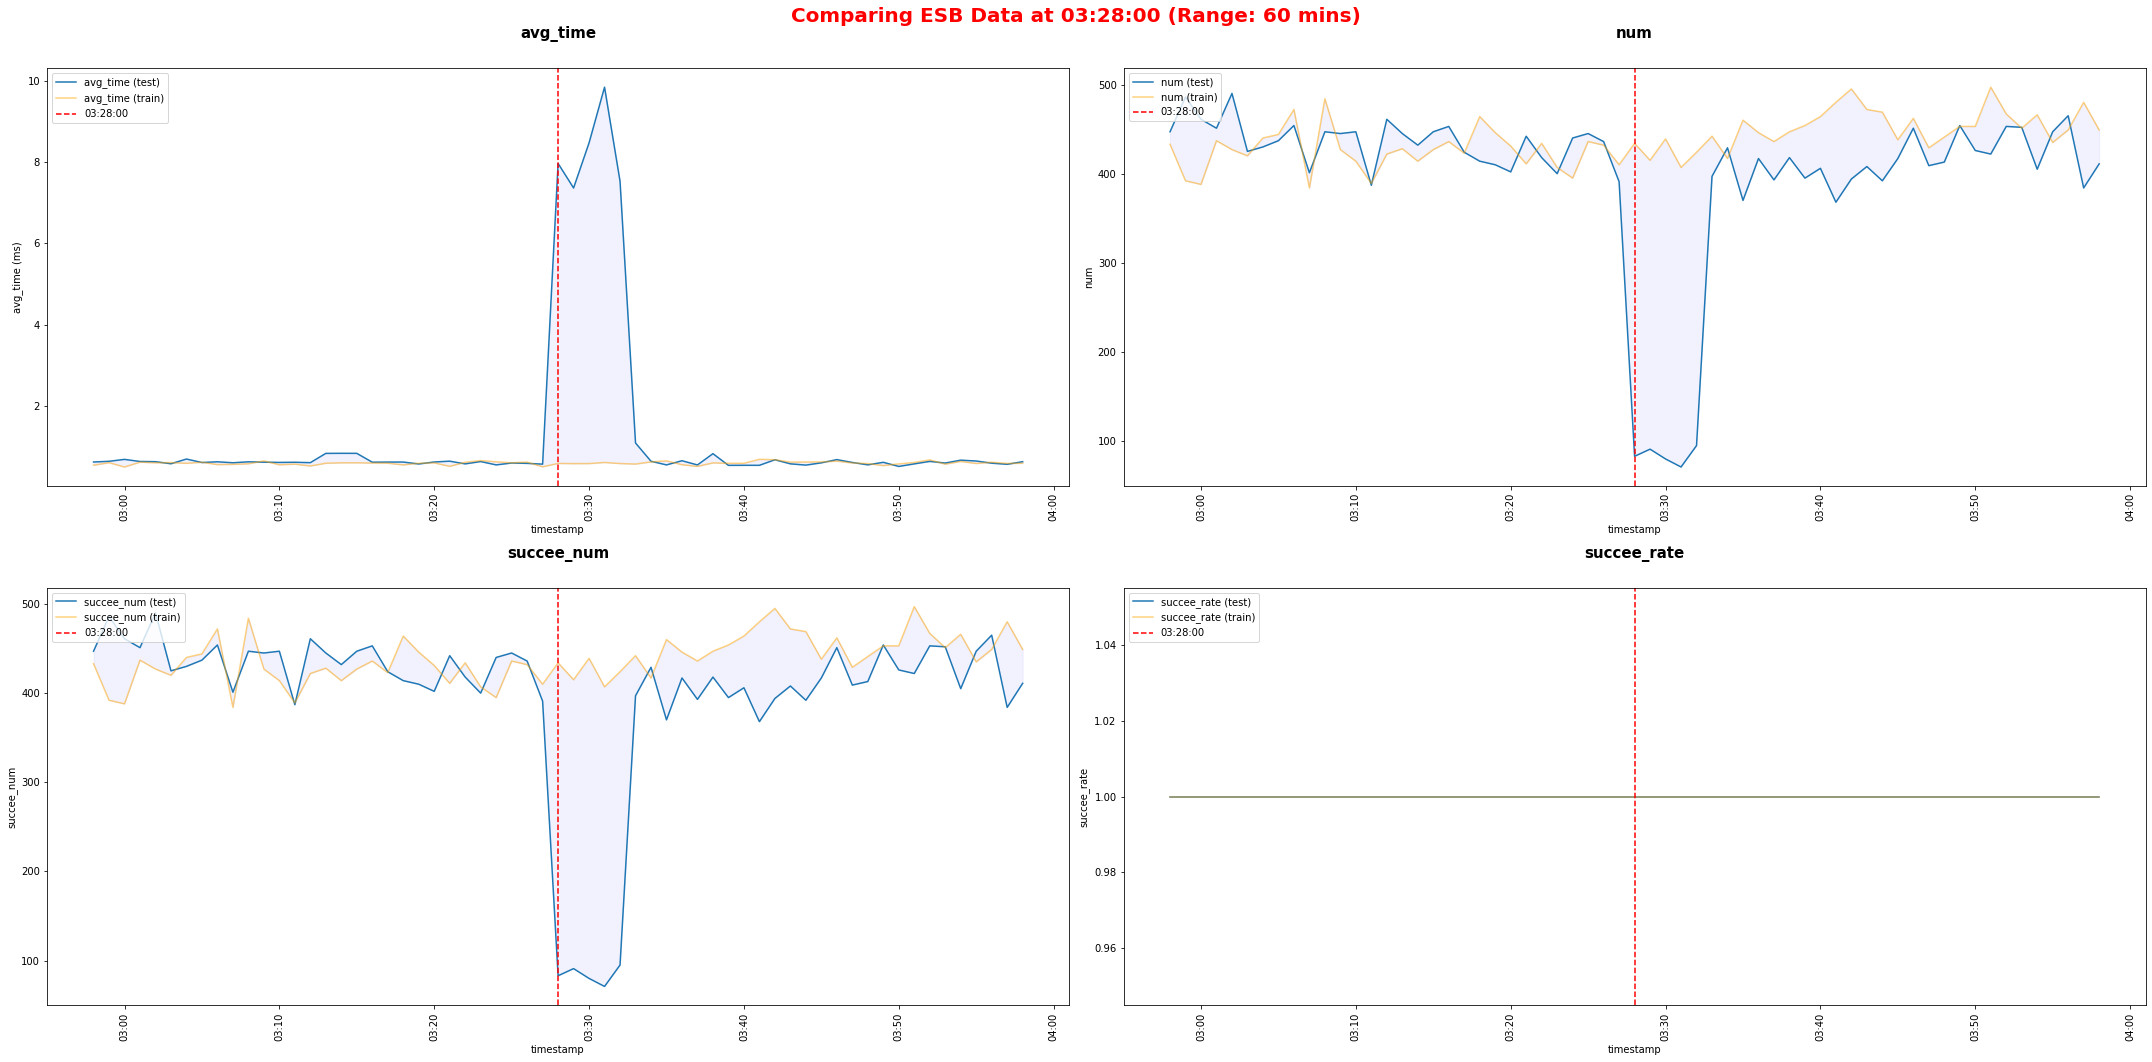

In [34]:
seconds_past = 12480
a, b = compare_esb(seconds_past, interval=60)

In [35]:
del a, b
gc.collect()

14098

#### Host Indicators

<b>Analysis:</b>
Given that `Recv_total` and `Send_total` are host KPIs to observe for failure #3, we plot the following graph - comparing `Recv_total` and `Send_total` values across 60 mins (corresponding to 60 data points) and against the train data for the same time period.

We observe that the both KPI values experienced a drastic decrease after the failure time (03:28:00), before returning back to normal around 03:35:00. `Recv_total` and `Send_total` represent the number of service requests received for processing and sent after processing.

In conclusion, we note that a possible failure could involve the virtual machine hosting the services. Such failures, although would not affect the service's success rate, would affect its latency and lead to slower execution. To identify these problems during production, we can observe for any drastic / abnormal increase in the operating system's `Recv_total` and `Send_total` metrics.

In [36]:
test_host = read_host("test_data", "os_linux", verbose=False)
train_host = read_host("train_data/2020_05_04", "os_linux", verbose=False)

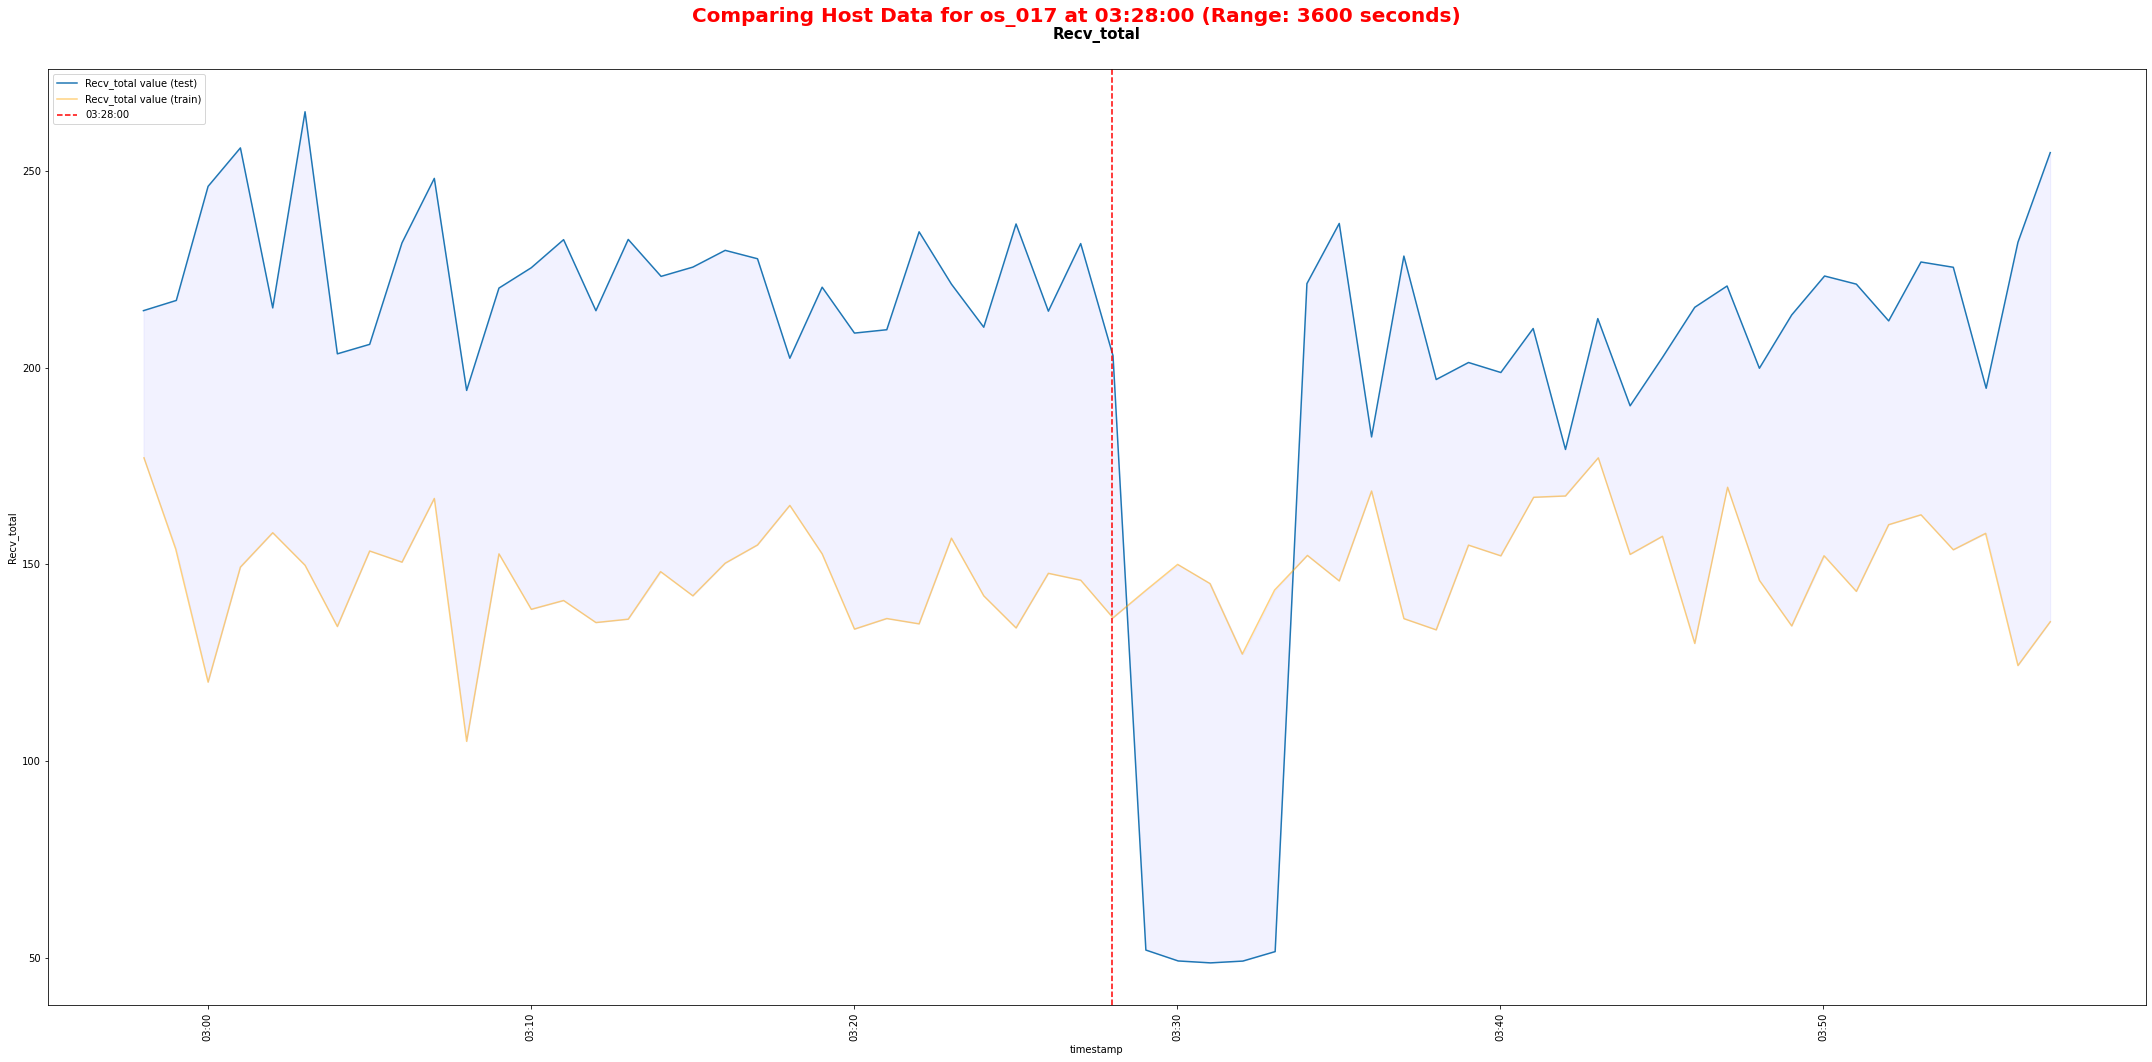

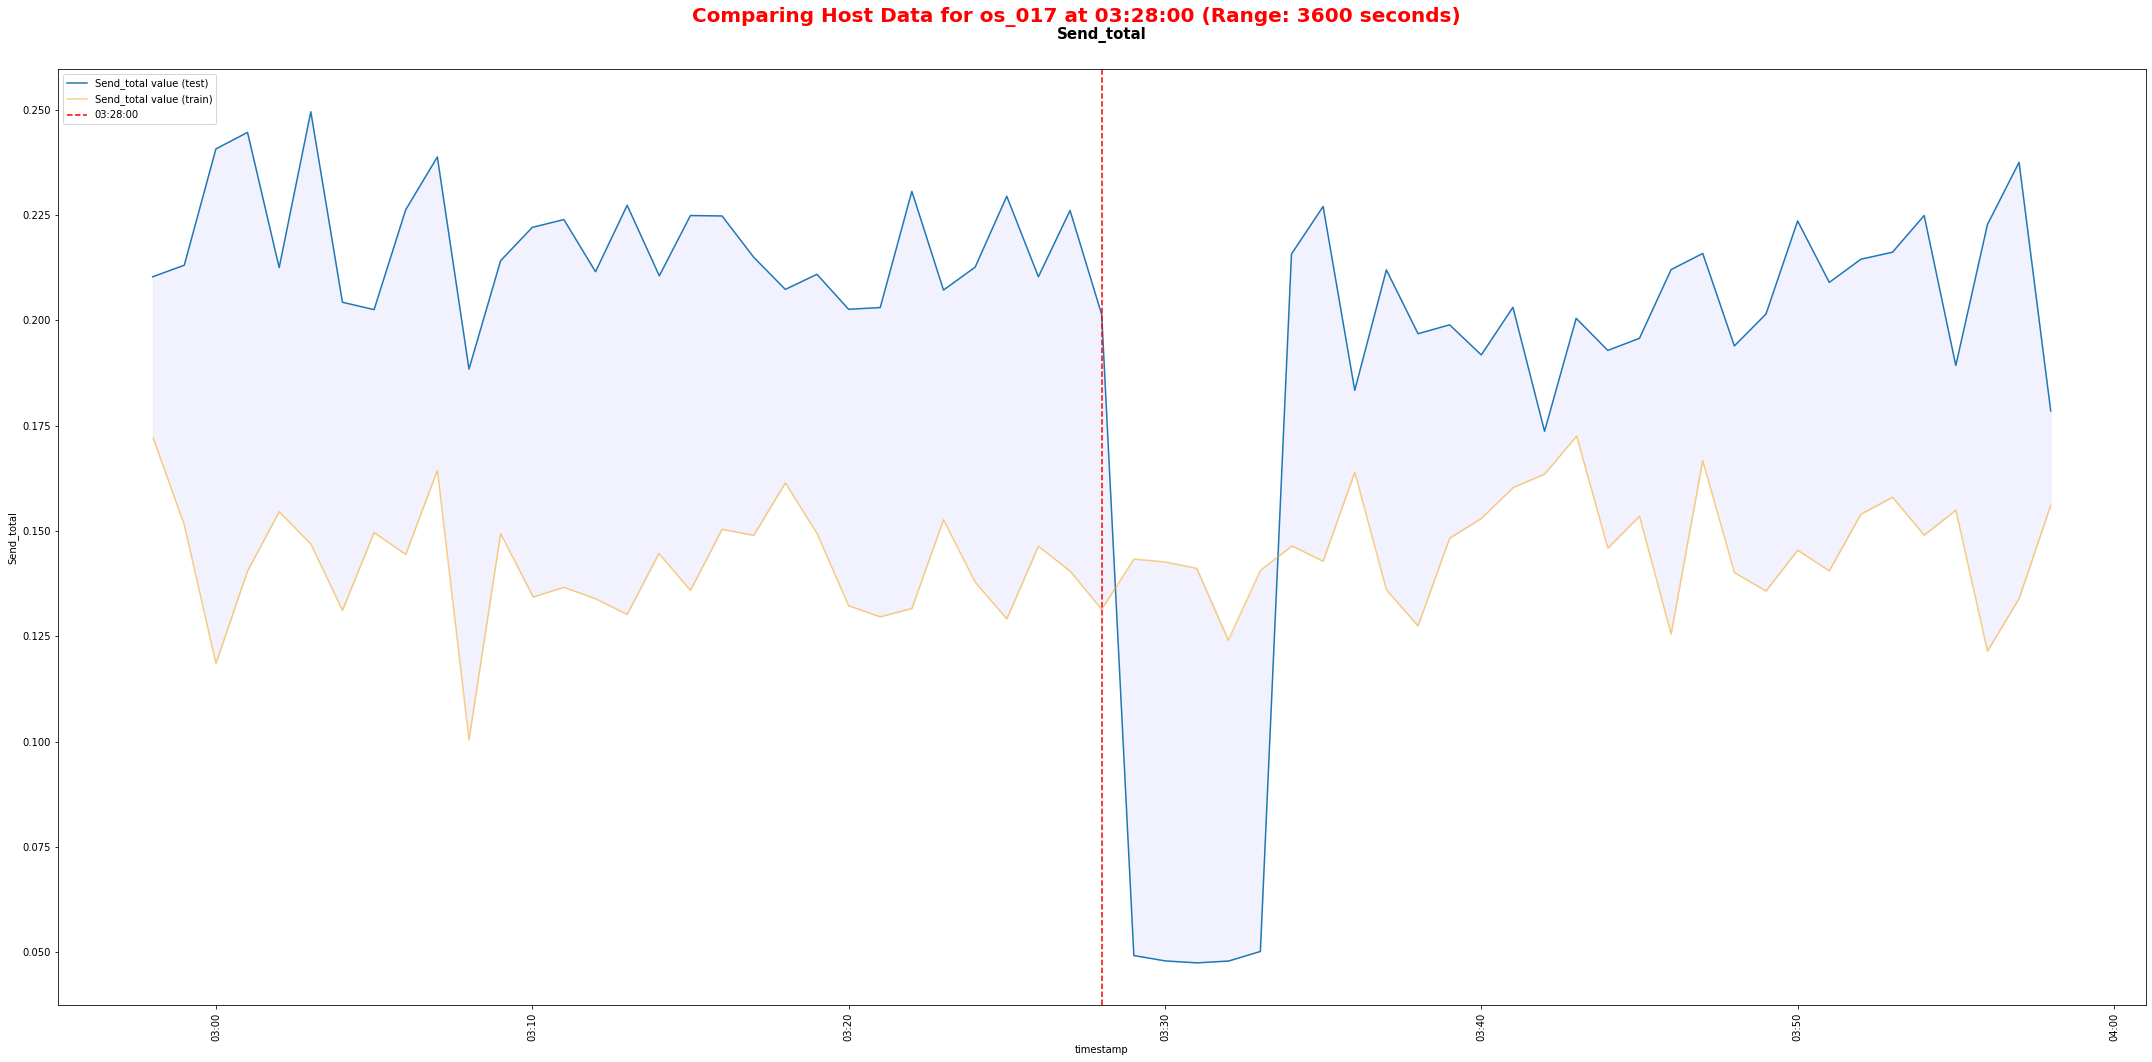

In [37]:
# From data analysis, we know that Recv_total and Send_total for os_017 are recorded in 1 mins interval
# Therefore, we select interval = 60 mins for 60 data points
test_host_compared, train_host_compared = compare_host(test_host=test_host,
                                                        train_host=train_host,
                                                        seconds_past=seconds_past,
                                                        cmdb_id='os_017',
                                                        name='Recv_total',
                                                        interval=60*60)

test_host_compared, train_host_compared = compare_host(test_host=test_host,
                                                        train_host=train_host,
                                                        seconds_past=seconds_past,
                                                        cmdb_id='os_017',
                                                        name='Send_total',
                                                        interval=60*60)

In [38]:
del test_host_compared, train_host_compared
del test_host, train_host
gc.collect()

7537

#### Trace Indicators

<b>Analysis:</b>
Since we know that `os_017` (which hosts `docker_001` and `docker_005`) has a failure and that all traceId begin from a root process that must start from either `os_021` or `os_022` (refer to Data Exploration's Finding #6), we will plot the following graphs - (1) comparing the length of trace data, (2) comparing the elapsed time of the parent processes for `os_021`, (3) comparing the elapsed time of the parent processes for `os_022`

These graphs' time period are carefully chosen to ensure that long-elapse-time functions are shown and there are ample data before & after to ascertain the trend.

From the graphs, we can tell that:
1. Number of trace invocations (trace length) remained roughly the same despite failure
2. `os_021` did not exeperience much change in elapsed time (though it has lower call frequency)
3. `os_022` experienced higher elapsed time persisting for about 5 mins (from 03:28:00 to 03:33:00)

<b>Similar to Failure #2's Trace Indicators Explanation, we will compare specific dockers</b>

`docker_001` is more similar to `docker_002` to `docker_004` while `docker_005` is more similar to `docker_006` to `docker_008`. Therefore, this will shape the logic subsequently, when we compared the docker metrics across to detect anomalies.

Subsequently, we sampled for 100 traceIDs (since 100 is a large sample size for approximation) from both the train and test data to:
1. Calculate actual time taken for each process ID, combining them through a unique identifier (in the format of `cmdb_id:serviceName:dsName`)
2. Find out the average time taken across all 100 traceIDs for their respective 
3. Merge the train and test dataframe to compute their differences (where possible)
4. Filter for `docker_001`, `docker_002` in the `uniquer_identifier` (since they share similar metrics and trace calls)
5. Plot and compare their values to observe for anomalies using a bar chart
6. Filter for `docker_005`, `docker_006`, `docker_007`, `docker_008` in the `uniquer_identifier` (since they share similar metrics and trace calls)
7. Plot and compare their values to observe for anomalies using a line graph

From the output graph of the above step, we notice that:
1. For `docker_001`, `None:db_009` and `csf_001:None` have the largest differences 
2. For `docker_005`, `None:db_003` and csf methods (i.e. from `csf_002:None` to `csf_005:None`) have the largest differences

Therefore, since all the above metrics identified are outer span, we can conclude that the failure of `os_017` can be attributed to the large increase in time to pass control to other microservices.

<b>What this means to the developer:</b>
Code review should be performed on the above metrics to understand the cause for the increase in time taken to call other microservices.

<b>What this means to site reliability engineer / ML engineer:</b>
We can potentially detect the failure of OS that host docker containers (i.e. `os_017` to `os_020`) by observing the the above identified metrics, for large increase in actual time as compared to train data.

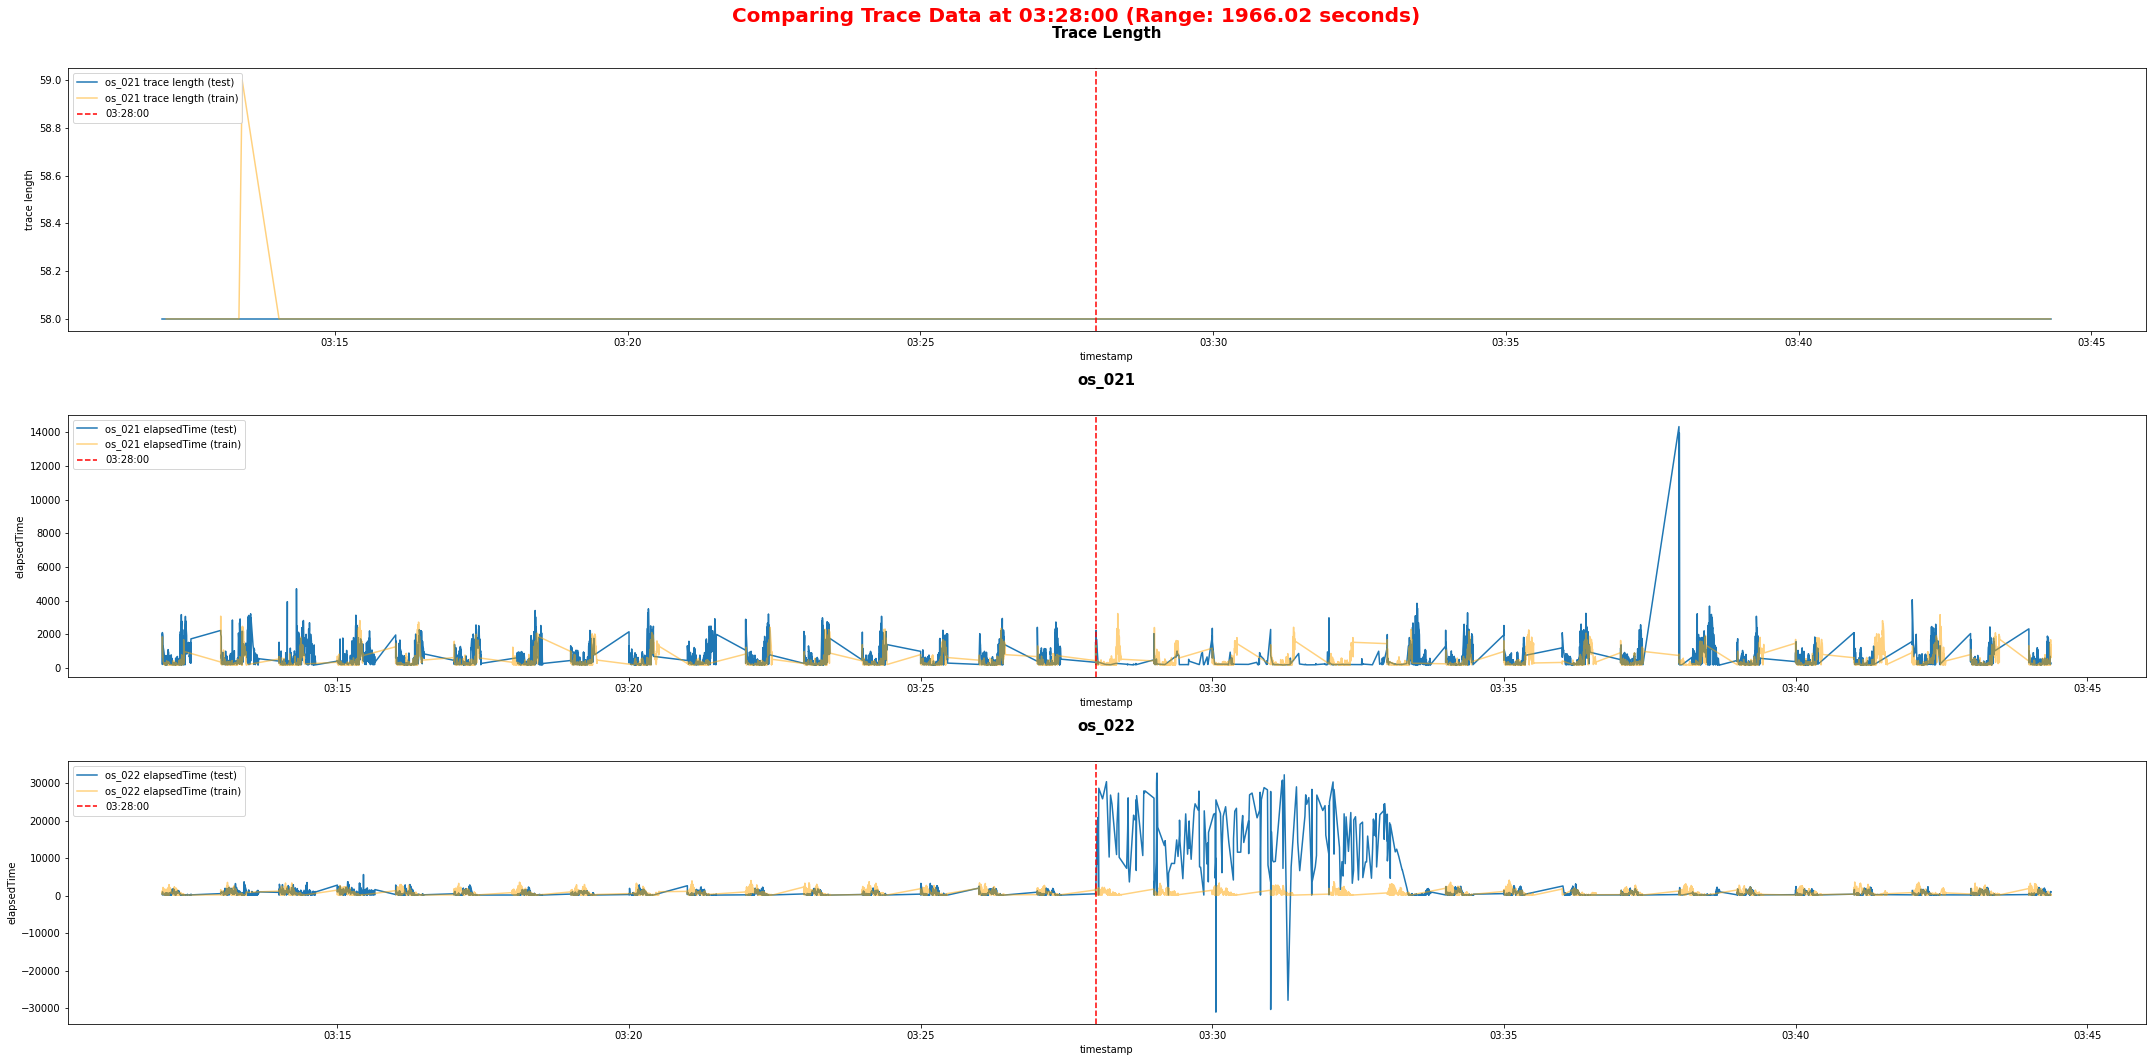

In [39]:
test_trace_filtered, train_trace_filtered, \
test_trace_length_list, train_trace_length_list, \
test_trace_filtered_parent_os_021, train_trace_filtered_parent_os_021, \
test_trace_filtered_parent_os_022, train_trace_filtered_parent_os_022 = \
compare_trace_for_failure(test_trace, train_trace, seconds_past=seconds_past)

<b>Finding the root cause for the slower processing speed</b>

In [40]:
cumulative = compare_trace_childrens_failure2(test_trace_filtered, train_trace_filtered, test_trace_filtered_parent_os_022, train_trace_filtered_parent_os_022)
pd.set_option('display.max_rows', None)
cumulative

unique_identifier  train_actual_time  test_actual_time  \
1               docker_001:None:db_009              10.99           3419.66   
2              docker_001:csf_001:None              27.55           3002.82   
21             docker_002:csf_003:None               5.40            510.93   
0               docker_001:None:db_007               6.69            484.52   
20             docker_002:csf_002:None               8.00            476.02   
22             docker_002:csf_004:None               4.76            375.83   
23             docker_002:csf_005:None               4.81            355.53   
5              docker_001:csf_004:None               4.90            319.84   
3              docker_001:csf_002:None              10.15            316.22   
6              docker_001:csf_005:None               5.73            276.95   
4              docker_001:csf_003:None               5.86            259.73   
7       docker_001:fly_remote_001:None               3.56            255.85   
8   docker_001:local_method_001:db_009               1.28            138.65   
57                 os_022:osb_001:None              13.96            140.98   
19             docker_002:csf_001:None              25.34             33.78   
18              docker_002:None:db_009               7.12             13.74   
26  docker_002:local_method_002:db_009               1.94              4.89   
17              docker_002:None:db_007               4.43              7.03   
13  docker_001:local_method_006:db_009               1.89              2.81   
24      docker_002:fly_remote_001:None               3.75              4.20   
25  docker_002:local_method_001:db_009               1.64              1.92   
27  docker_002:local_method_003:db_009               0.36              0.46   
32  docker_002:local_method_009:db_009               0.54              0.59   
12  docker_001:local_method_005:db_009               0.84              0.83   
14  docker_001:local_method_007:db_009               0.68              0.58   
31  docker_002:local_method_007:db_009               1.49              0.51   
10  docker_001:local_method_003:db_009               1.71              0.63   
9   docker_001:local_method_002:db_009               5.21              3.79   
29  docker_002:local_method_005:db_009               2.14              0.43   
28  docker_002:local_method_004:db_009               5.55              3.71   
33  docker_002:local_method_010:db_007               2.69              0.80   
30  docker_002:local_method_006:db_009               4.34              1.74   
15  docker_001:local_method_009:db_009               3.35              0.68   
16  docker_001:local_method_010:db_007               3.84              1.05   
11  docker_001:local_method_004:db_009               8.14              2.99   
56                 os_022:csf_001:None               9.97           -526.08   
34              docker_007:None:db_003              12.74               NaN   
35             docker_007:csf_002:None              12.69               NaN   
36             docker_007:csf_003:None               8.01               NaN   
37             docker_007:csf_004:None               7.87               NaN   
38             docker_007:csf_005:None               5.76               NaN   
39  docker_007:local_method_011:db_003               1.13               NaN   
40  docker_007:local_method_013:db_003               1.64               NaN   
41  docker_007:local_method_014:db_003               2.02               NaN   
42  docker_007:local_method_015:db_003               2.12               NaN   
43  docker_007:local_method_016:db_003               0.92               NaN   
44  docker_007:local_method_017:db_003               1.44               NaN   
45              docker_008:None:db_003              13.76               NaN   
46             docker_008:csf_002:None              13.98               NaN   
47             docker_008:csf_003:None               7.59              

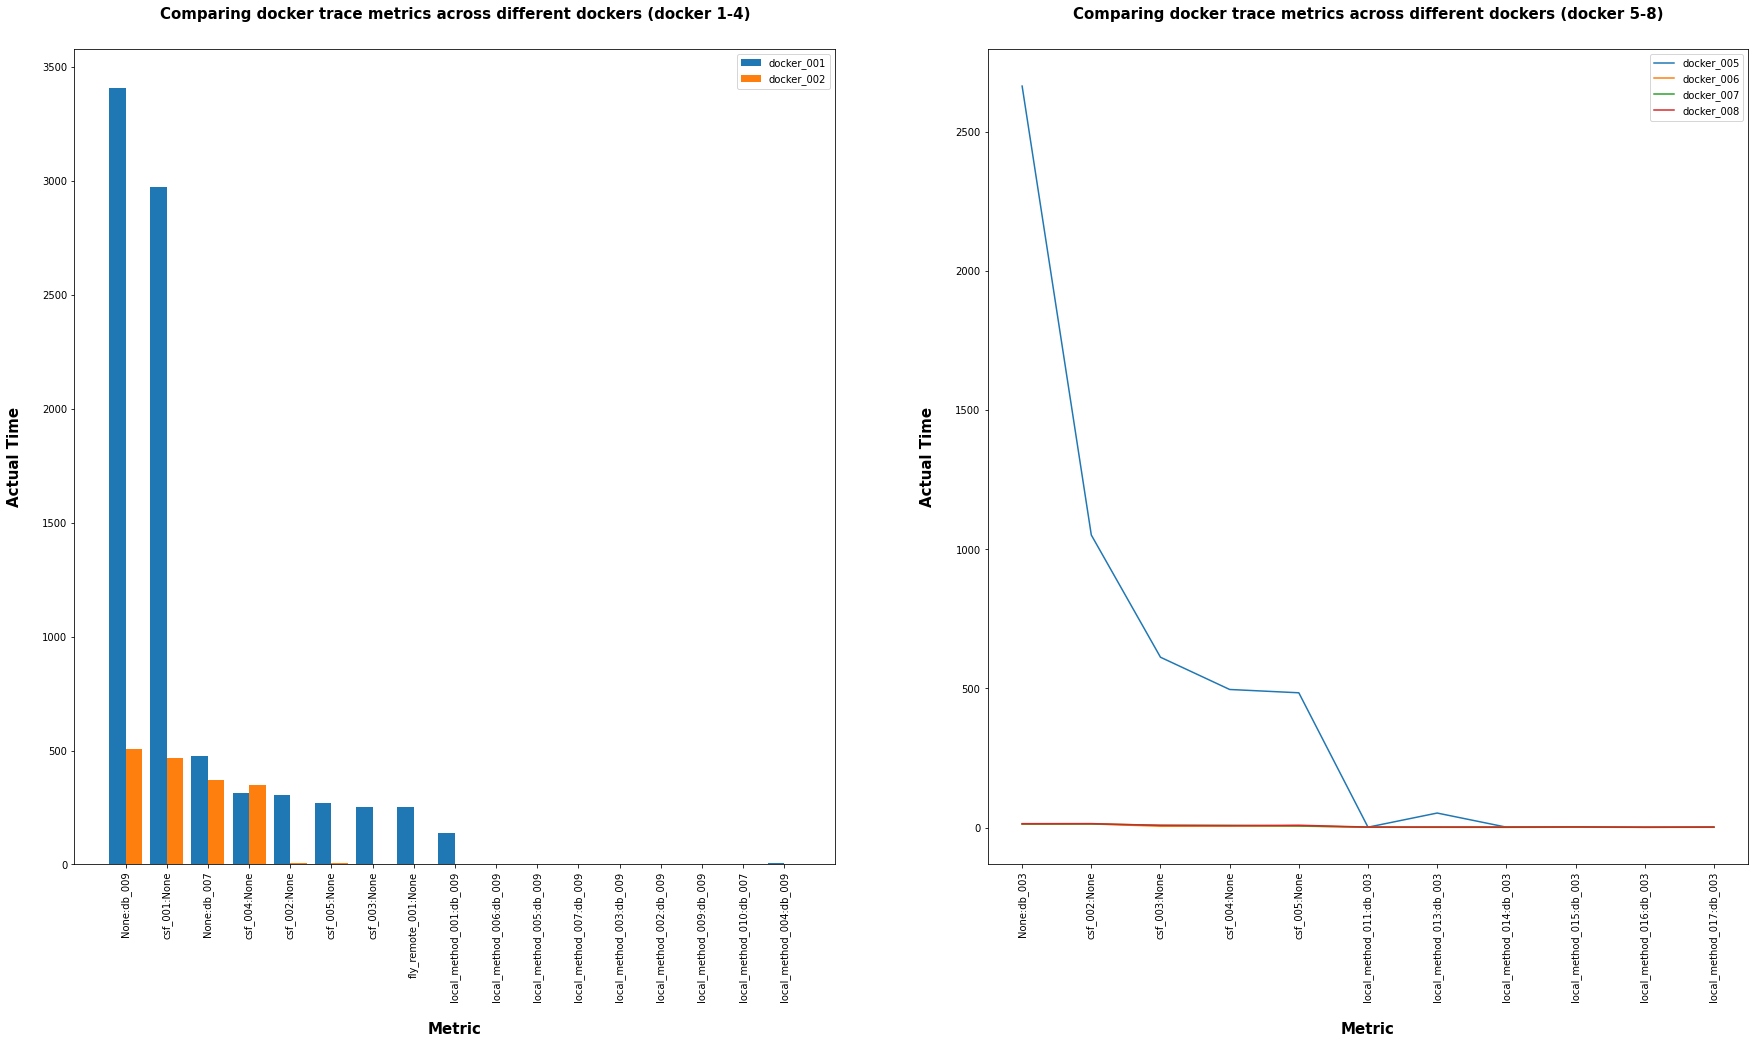

In [41]:
# Compare the metrics with docker_001 against other metrics with docker_002 or docker_008
cumulative_docker_001 = cumulative[cumulative.unique_identifier.str.contains('docker_001')]
cumulative_docker_001.unique_identifier = cumulative_docker_001.unique_identifier.str.replace('docker_001:', '')
cumulative_docker_001.difference = abs(cumulative_docker_001.difference)

cumulative_docker_002 = cumulative[cumulative.unique_identifier.str.contains('docker_002')]
cumulative_docker_002.unique_identifier = cumulative_docker_002.unique_identifier.str.replace('docker_002:', '')
cumulative_docker_002.difference = abs(cumulative_docker_002.difference)

# Compare the metrics with docker_005 against other metrics with docker_006, docker_007, docker_008
cumulative_docker_005 = cumulative[cumulative.unique_identifier.str.contains('docker_005')]
cumulative_docker_005.unique_identifier = cumulative_docker_005.unique_identifier.str.replace('docker_005:', '')

cumulative_docker_006 = cumulative[cumulative.unique_identifier.str.contains('docker_006')]
cumulative_docker_006.unique_identifier = cumulative_docker_006.unique_identifier.str.replace('docker_006:', '')

cumulative_docker_007 = cumulative[cumulative.unique_identifier.str.contains('docker_007')]
cumulative_docker_007.unique_identifier = cumulative_docker_007.unique_identifier.str.replace('docker_007:', '')

cumulative_docker_008 = cumulative[cumulative.unique_identifier.str.contains('docker_008')]
cumulative_docker_008.unique_identifier = cumulative_docker_008.unique_identifier.str.replace('docker_008:', '')

# Plot cumulative_docker_001, cumulative_docker_007, cumulative_docker_008
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15))

# Multi bar Chart
x_axis = np.arange(len(cumulative_docker_001))

ax1.bar(x_axis -0.2, cumulative_docker_001.difference, width=0.4, label = 'docker_001')
ax1.bar(x_axis +0.2, cumulative_docker_002.difference, width=0.4, label = 'docker_002')
ax1.set_xticks(x_axis)
ax1.set_xticklabels(cumulative_docker_001.unique_identifier, rotation=90)

ax1.set_title("Comparing docker trace metrics across different dockers (docker 1-4)", fontsize=15, fontweight='bold', pad=30, color='black', loc='center')
ax1.set_xlabel('Metric', fontsize=15, fontweight='bold', color='black', labelpad=20)
ax1.set_ylabel('Actual Time', fontsize=15, fontweight='bold', color='black', labelpad=20)
ax1.legend(loc='upper right')


ax2.plot(cumulative_docker_005.unique_identifier, cumulative_docker_005.test_actual_time, label='docker_005')
ax2.plot(cumulative_docker_006.unique_identifier, cumulative_docker_006.test_actual_time, label='docker_006')
ax2.plot(cumulative_docker_007.unique_identifier, cumulative_docker_007.train_actual_time, label='docker_007')
ax2.plot(cumulative_docker_008.unique_identifier, cumulative_docker_008.train_actual_time, label='docker_008')

ax2.set_title("Comparing docker trace metrics across different dockers (docker 5-8)", fontsize=15, fontweight='bold', pad=30, color='black', loc='center')
ax2.set_xlabel('Metric', fontsize=15, fontweight='bold', color='black', labelpad=20)
ax2.set_ylabel('Actual Time', fontsize=15, fontweight='bold', color='black', labelpad=20)
ax2.legend(loc='upper right')

plt.setp(ax1.xaxis.get_majorticklabels(), rotation=90)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=90)
plt.show()

In [42]:
pd.reset_option('display.max_rows')

del test_trace_filtered, train_trace_filtered, \
    test_trace_filtered_parent_os_021, train_trace_filtered_parent_os_021, \
    test_trace_filtered_parent_os_022, train_trace_filtered_parent_os_022

del cumulative, cumulative_docker_001, cumulative_docker_002, \
    cumulative_docker_005, cumulative_docker_006, cumulative_docker_007, cumulative_docker_008

gc.collect()

11007

### Breaking Down Failure #4

Failure #4 Details:
```json
[
    16080,
    [
      ["db_003", "On_Off_State"],
      ["db_003", "tnsping_result_time"]
    ]
]
```

#### ESB Indicators

<b>Analysis:</b>
From the 4 line charts, we observe that soon after the failure time (04:28:00) the success rate decreased drastically twice consecutively, with the first occurence taking a longer time to recover than the second. This trend is a result of fewer successful calls (the graph for it shares similar pattern with success rate) as compared to `num`. On the other hand, the average time to process the service requests fluctuated after the failure time, dipping then increasing sharply.

The above patterns repeated itself for once more soon after the system recovered.

From these indicators, we suspect that a fault with 1 of the microservices led to a faster-than-before return of the service request, in the form of a failed request. This is supported by the shorter average time accompanied with lower success rate. On the other hand, the peak in average time can be explained as the "cold start" for connecting to the microservice that could have just recovered. Nonetheless, these are speculations that need to be affirmed through other indicators.

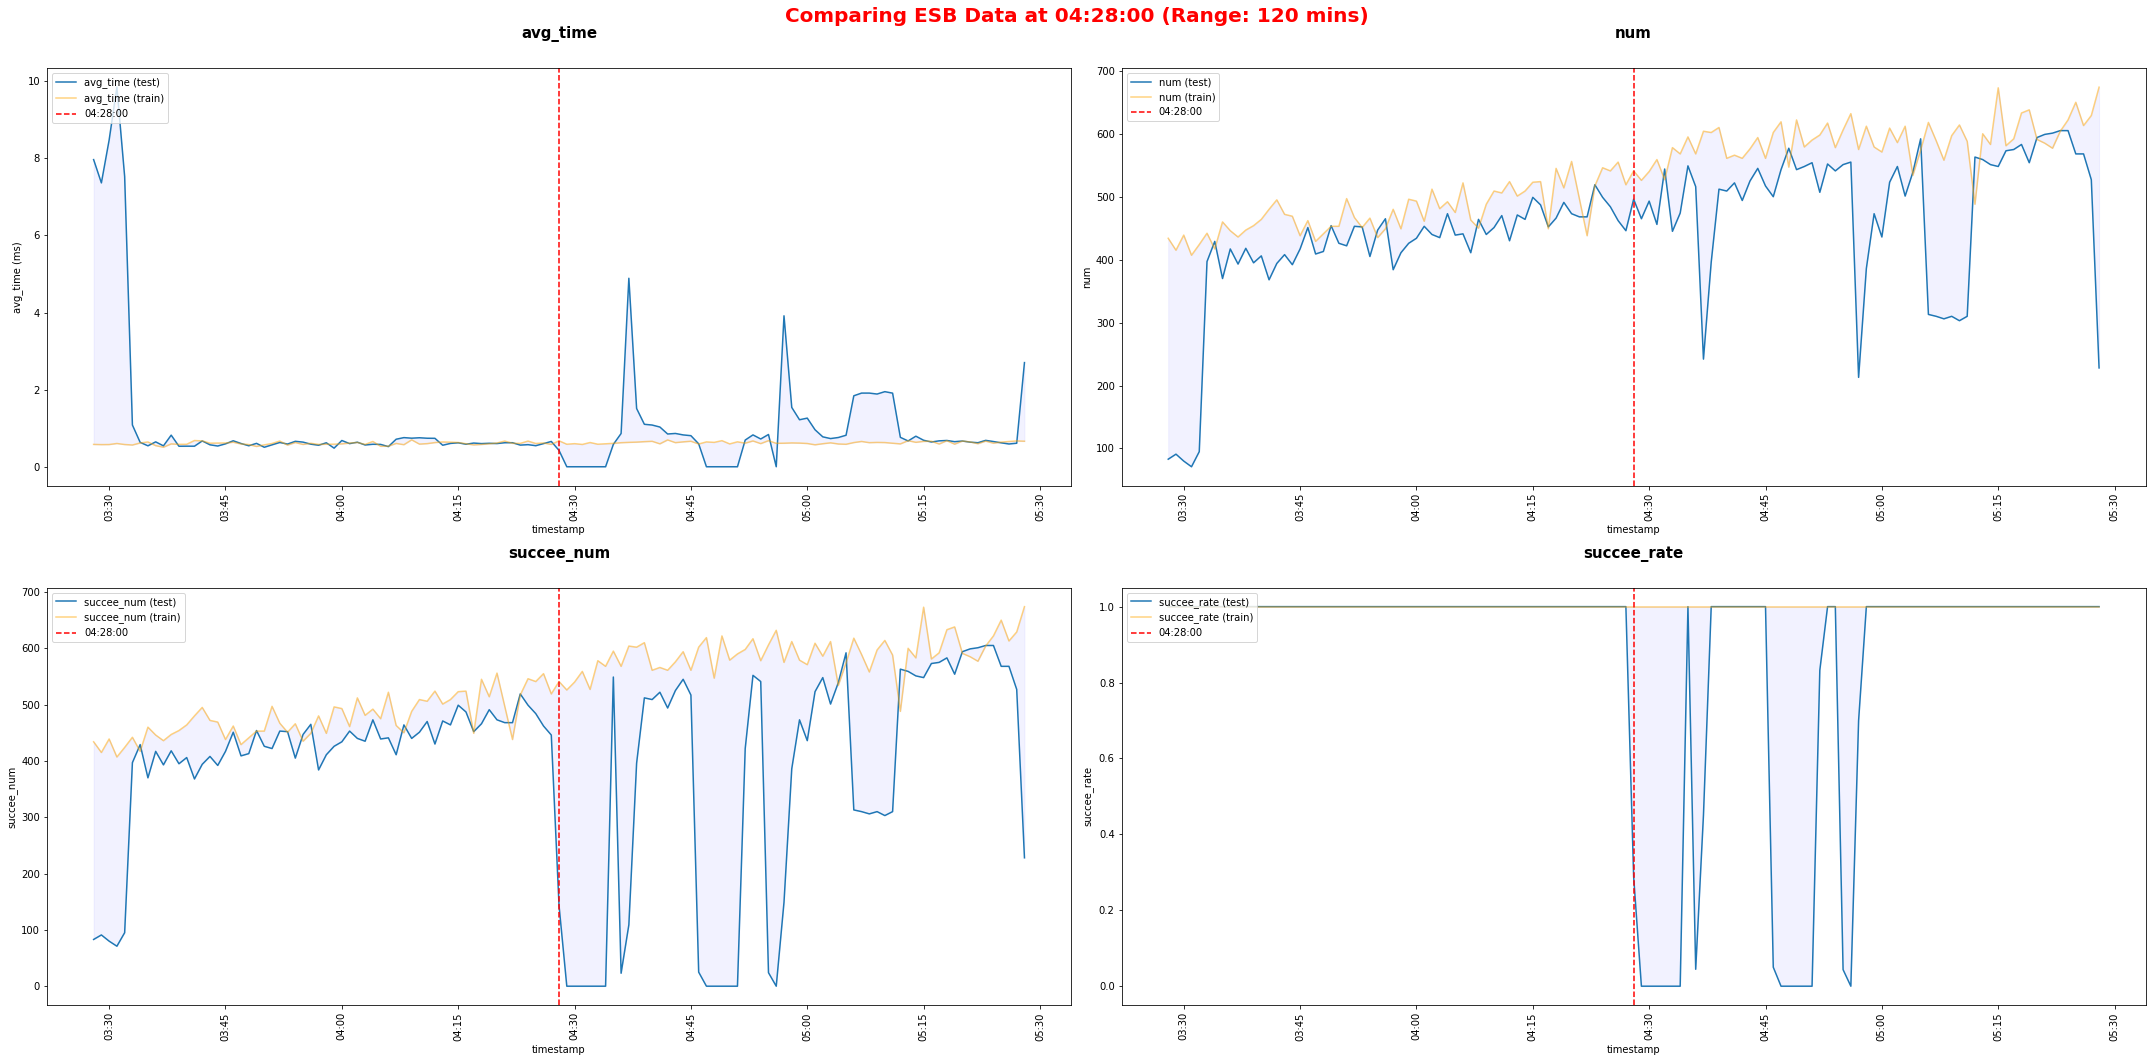

In [43]:
seconds_past = 16080
a, b = compare_esb(seconds_past, interval=120)

In [44]:
del a, b
gc.collect()

15258

#### Host Indicators

<b>Analysis:</b>
Given that `On_Off_State` and `tnsping_result_time` are host KPIs to observe for failure #4, we plot the following graph - comparing `Recv_total` and `Send_total` values across 60 mins (corresponding to 60 data points) and against the train data for the same time period.

We observe that `On_Off_State` was toggled from 1 (indicating "on") to 0 (indicating "off") during the failure time. At the same time, `tnsping_result_time` increased sharply to 9,999 ms (which is likely the timeout duration). These indicate that the database was "switched off" / unavailable during the time of failure and it led to timeout errors when attempting to connect to the affected database.

In conclusion, we note that a possible failure could involve the database that services require. Such failures would affect the service's success rate, and affect its latency while the distributed system attempts to fix the problem (e.g. by rerouting to another database). To identify these problems during production, we can observe for any drastic / abnormal increase in the operating system's `On_Off_State` and `tnsping_result_time` metrics. Specifically, we can observe for the time period when `On_Off_State` == 0 and `tnsping_result_time` == 9999.

In [45]:
test_host = read_host("test_data", "db_oracle_11g", verbose=False)
train_host = read_host("train_data/2020_05_04", "db_oracle_11g", verbose=False)

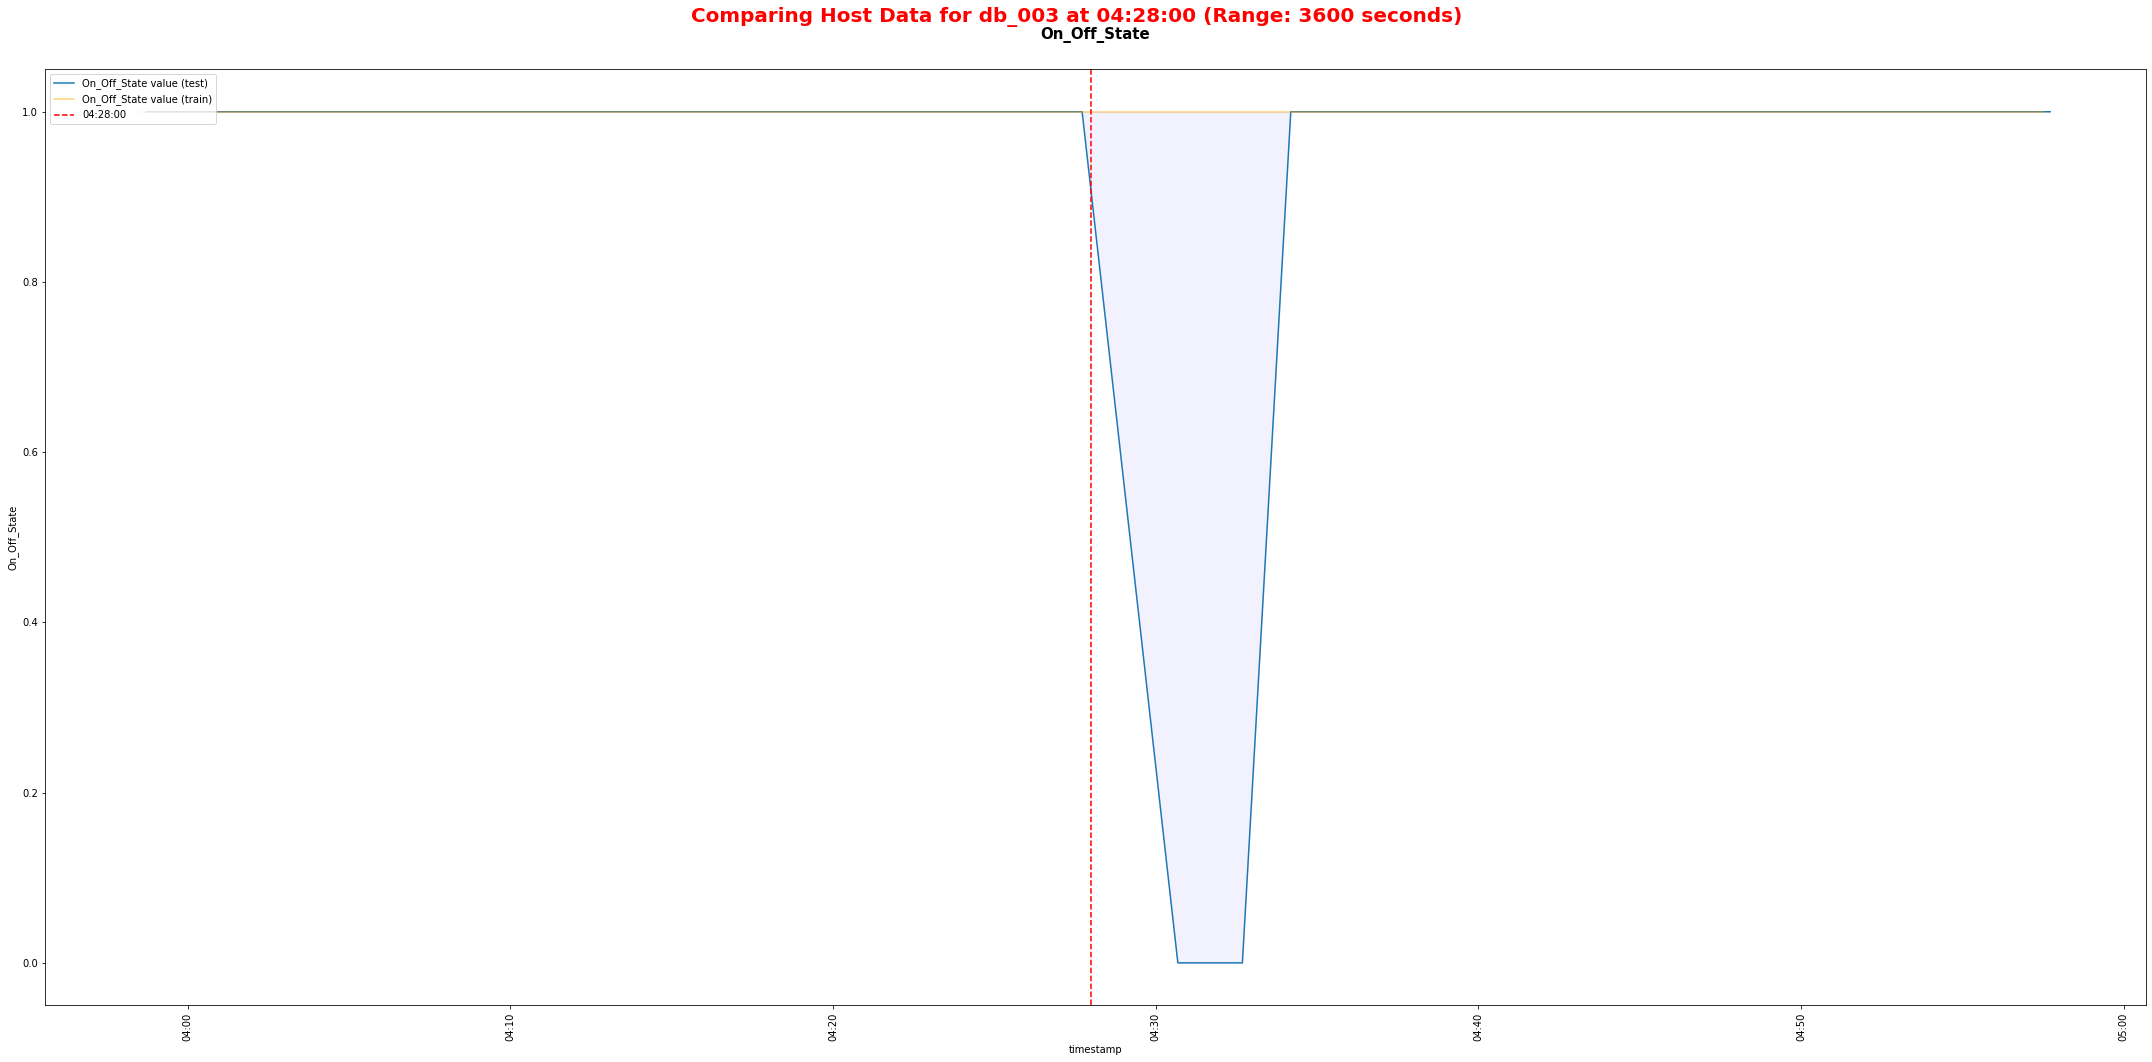

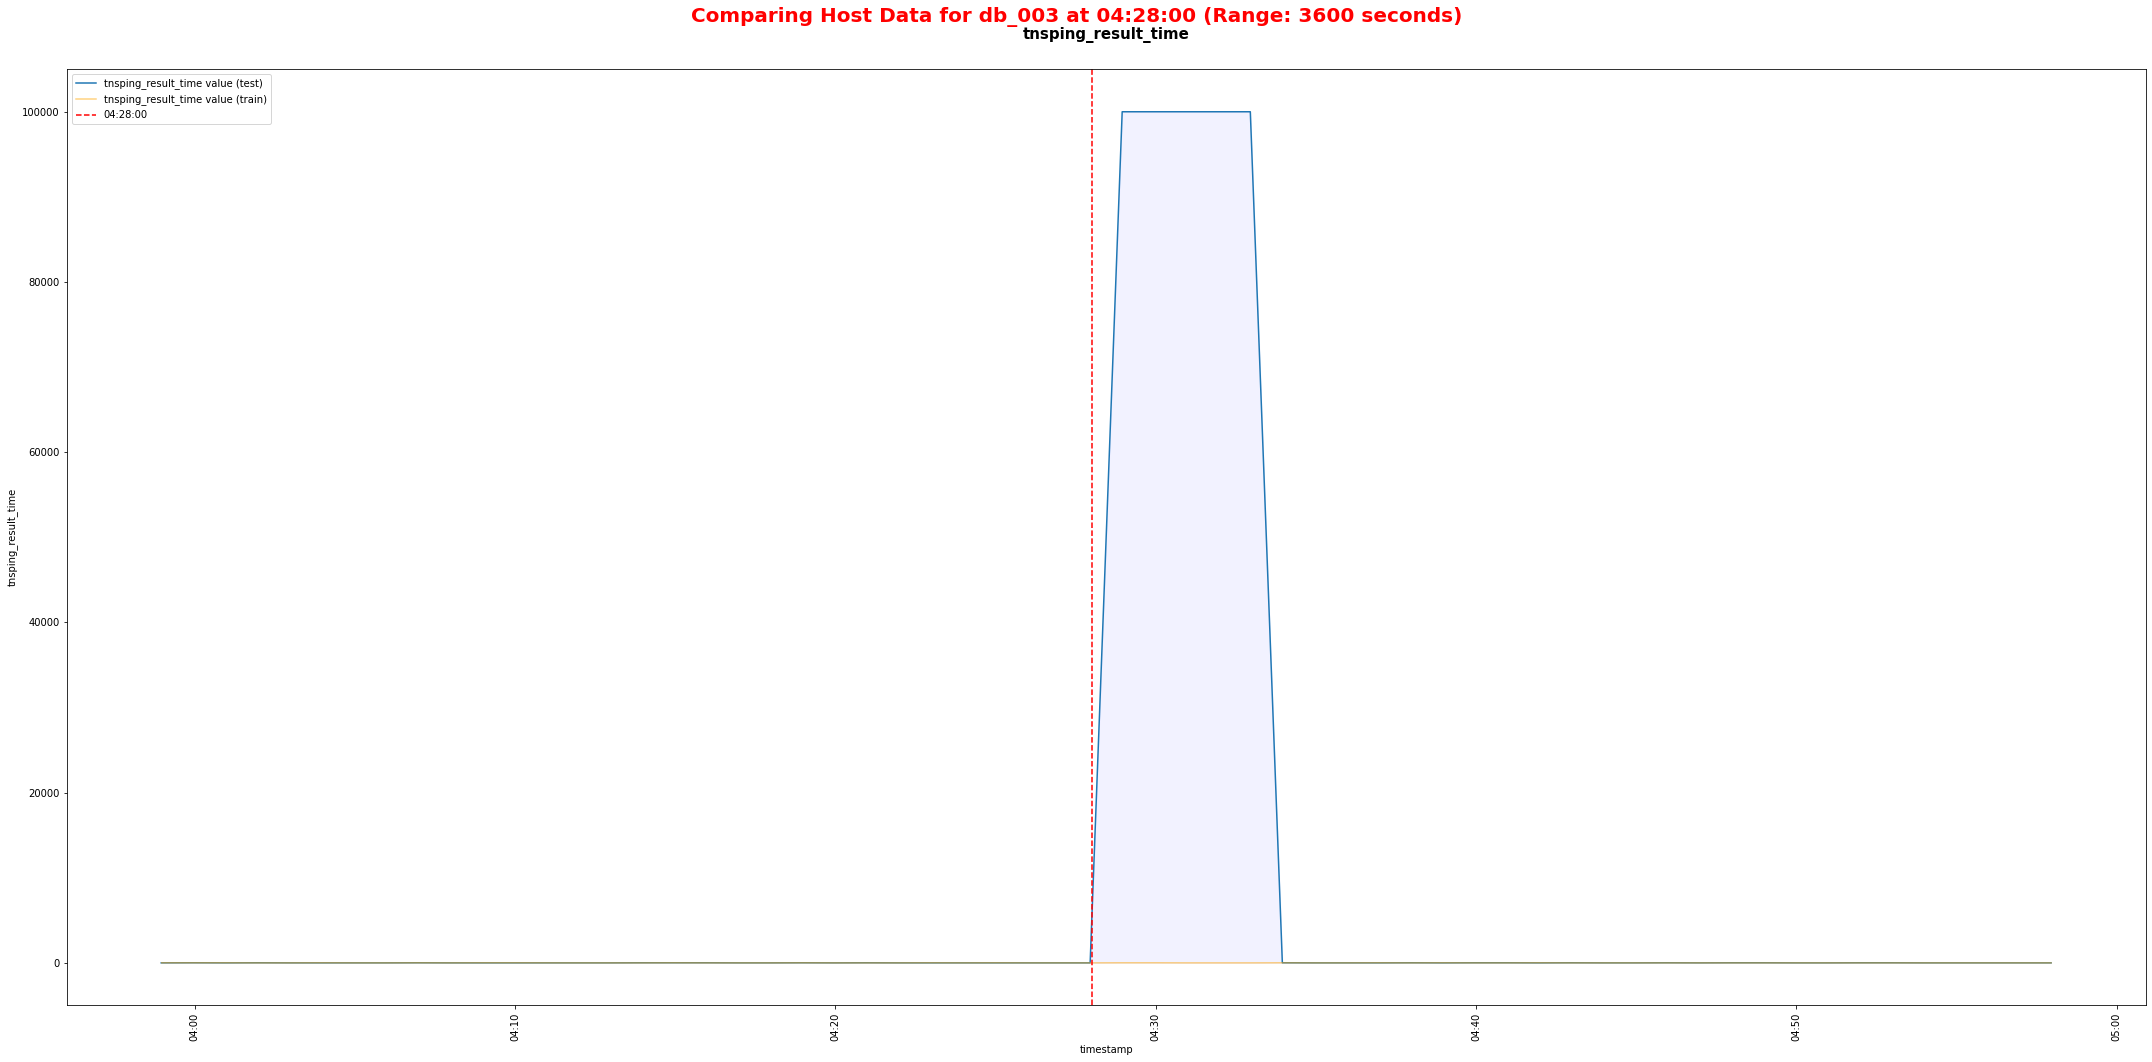

In [46]:
# From data analysis, we know that On_Off_State and tnsping_result_time for db_003 are recorded in 1 mins interval
# Therefore, we select interval = 60 mins for 60 data points
test_host_compared, train_host_compared = compare_host(test_host=test_host,
                                                        train_host=train_host,
                                                        seconds_past=seconds_past,
                                                        cmdb_id='db_003',
                                                        name='On_Off_State',
                                                        interval=60*60)

test_host_compared, train_host_compared = compare_host(test_host=test_host,
                                                        train_host=train_host,
                                                        seconds_past=seconds_past,
                                                        cmdb_id='db_003',
                                                        name='tnsping_result_time',
                                                        interval=60*60)

In [47]:
del test_host_compared, train_host_compared
del test_host, train_host
gc.collect()

7460

#### Trace Indicators

<b>Analysis:</b>
Since we know that `db_003` has a failure and that all traceId begin from a root process that must start from either `os_021` or `os_022` (refer to Data Exploration's Finding #6), we will plot the following graphs - (1) comparing the length of trace data, (2) comparing the elapsed time of the parent processes for `os_021`, (3) comparing the elapsed time of the parent processes for `os_022`

These graphs' time period are carefully chosen to ensure that long-elapse-time functions are shown and there are ample data before & after to ascertain the trend.

From the graphs, we can tell that:
1. Number of trace invocations (trace length) experienced sharp decreases from 04:28:00 to 04:36:00
2. `os_021` experienced (1) lower elapsed time from 04:28:00 to 04:37:00, (2) higher elapsed time from 04:37:00 and 04:45:00
3. `os_022` experienced (1) lower elapsed time from 04:28:00 to 04:37:00, (2) a spike in elapsed time around 04:29:00 to 04:30:00, (3) higher elapsed time around 04:37:00 and 04:45:00

Observation 1 corresponds very much with the `os_021` graph, with the fluctuations matching closely.

<b>Similar to Failure #2's Trace Indicators Explanation, we will try to compare specific databases</b>

`db_003` appears to be mapped with `local_method_011` to `local_method_017` (excluding `local_method_012`), therefore mapped with `docker_005` to `docker_008`. `db_009` appears to be mapped with `local_method_001` to `local_method_010` (excluding `local_method_008`), therefore mapped with `docker_001` to `docker_004`.

Therefore, this will shape the logic subsequently, when we compared the docker metrics across to detect anomalies.


Subsequently, we sampled for 100 traceIDs (since 100 is a large sample size for approximation) from both the train and test data to:
1. Calculate actual time taken for each process ID, combining them through a unique identifier (in the format of `cmdb_id:serviceName:dsName`)
2. Find out the average time taken across all 100 traceIDs for their respective 
3. Merge the train and test dataframe to compute their differences (where possible)
4. Filter for `docker_006`, `docker_007`, `docker_008` in the `uniquer_identifier` (since they share similar metrics and trace calls)
5. Plot and compare their values to observe for anomalies

Note that `docker_006` is from train data, therefore it is faultless, while `docker_007` and `docker_008` are from test data.

From the output graph of the above step, we notice that:
1. If `db_003` has fault, then the invocation trace length will be shorter (2 instead of 11). This means that the invocation stopped and possibly an error message is returned.
2. If `db_003` has fault, then there would be a large difference in actual time for `None:db_003`. This can be understood as the time to query the database is longer than the timeout duration.

<b>What this means to the developer:</b>
Code review should be performed to understand the cause for the database failure and if the aftermath effects are intended and errors are properly handled.

<b>What this means to site reliability engineer / ML engineer:</b>
We can potentially detect database failure by observing the `None:db_003` metrics, for shorter actual time. Additionally, we can use the trace invocation length as another indicator for failures.

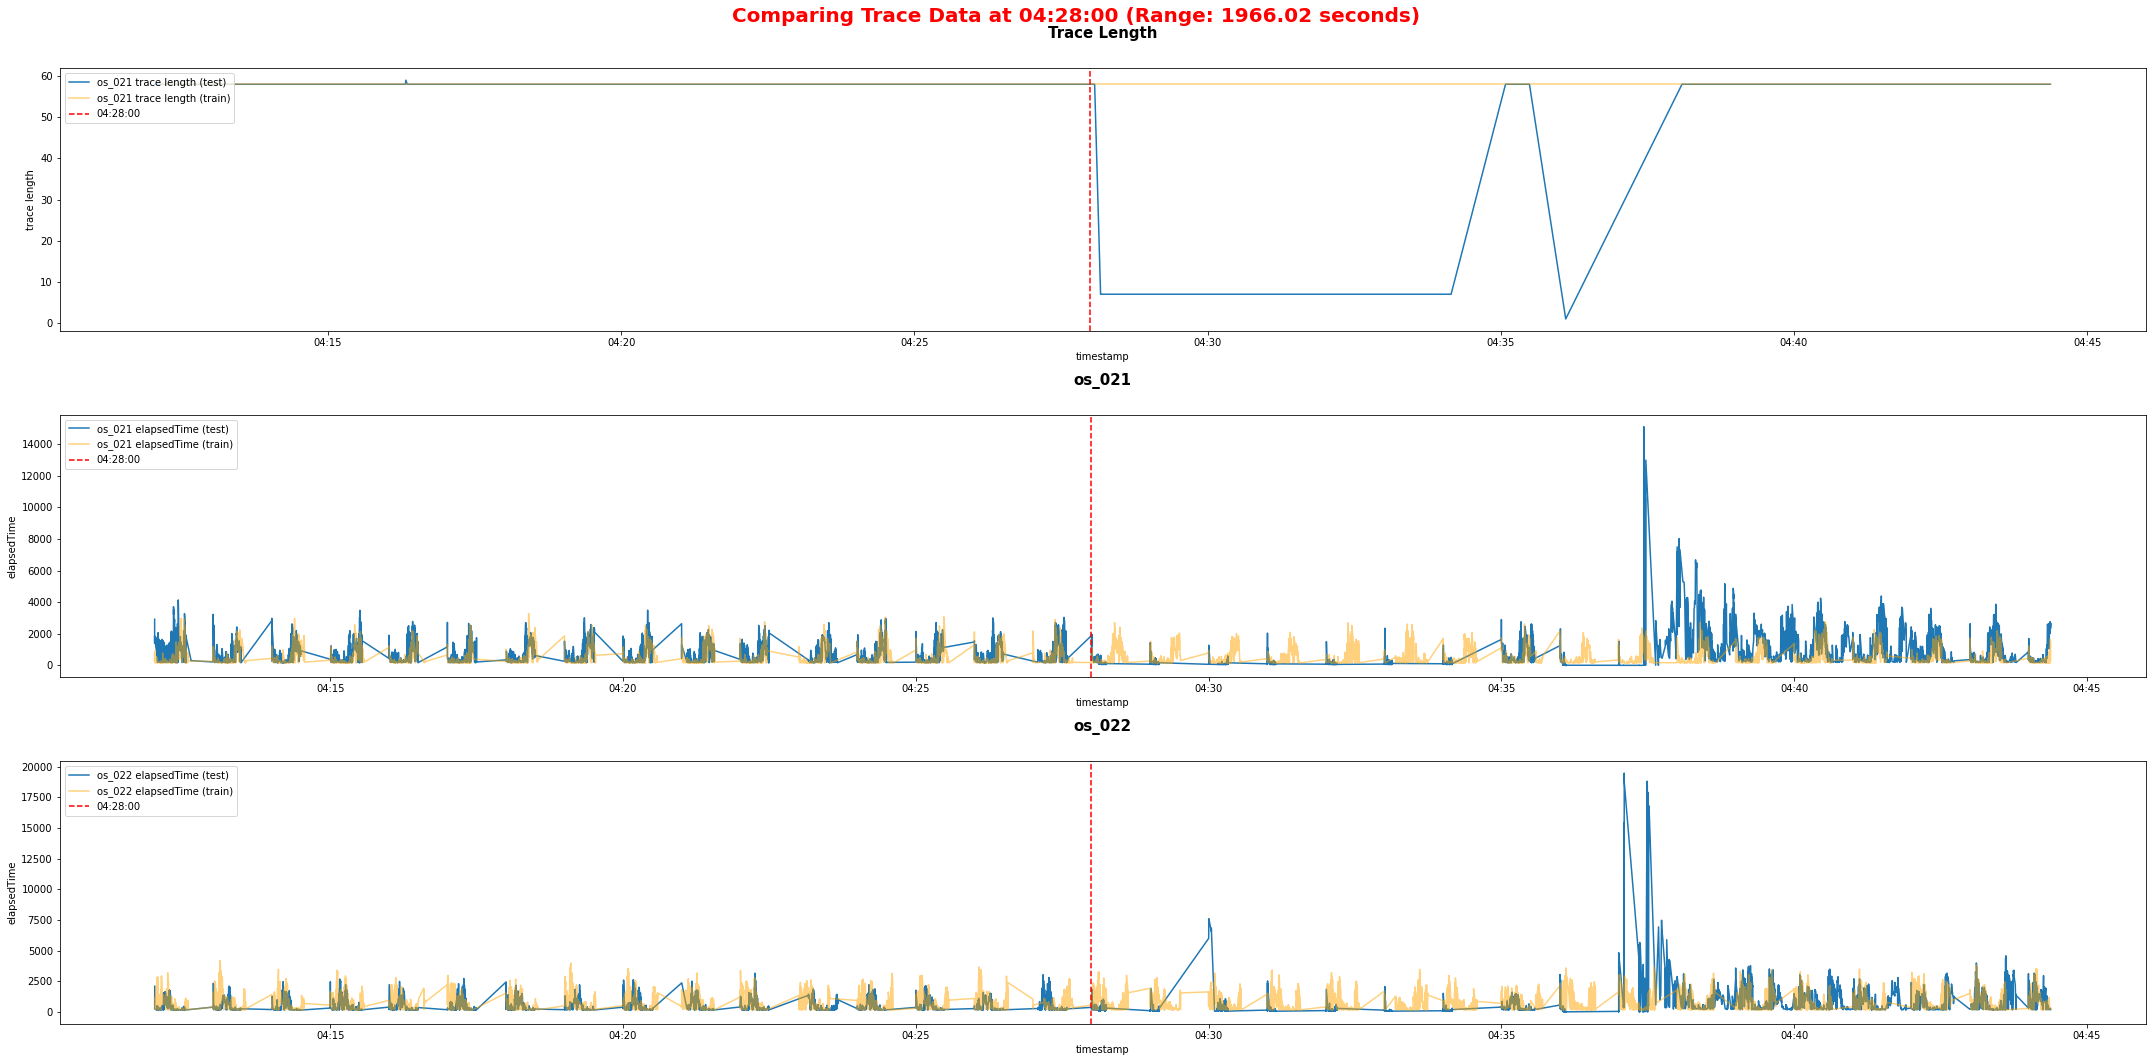

In [64]:
test_trace_filtered, train_trace_filtered, \
test_trace_length_list, train_trace_length_list, \
test_trace_filtered_parent_os_021, train_trace_filtered_parent_os_021, \
test_trace_filtered_parent_os_022, train_trace_filtered_parent_os_022 = \
compare_trace_for_failure(test_trace, train_trace, seconds_past=seconds_past)

<b>Finding the root cause for the slower processing speed</b>

In [65]:
cumulative = compare_trace_childrens_failure4(test_trace_filtered, train_trace_filtered, test_trace_filtered_parent_os_021, train_trace_filtered_parent_os_021)
pd.set_option('display.max_rows', None)
cumulative

unique_identifier  train_actual_time  test_actual_time  \
46                 os_021:osb_001:None              15.36             16.44   
7       docker_003:fly_remote_001:None               2.19              2.26   
24      docker_004:fly_remote_001:None               2.87              2.74   
20             docker_004:csf_002:None               4.93              4.64   
3              docker_003:csf_002:None               4.70              4.28   
45                 os_021:csf_001:None               5.02              2.68   
19             docker_004:csf_001:None              16.86              9.44   
2              docker_003:csf_001:None              15.65              6.99   
0               docker_003:None:db_007               3.52               NaN   
1               docker_003:None:db_009               5.27               NaN   
4              docker_003:csf_003:None               2.62               NaN   
5              docker_003:csf_004:None               3.65               NaN   
6              docker_003:csf_005:None               3.90               NaN   
8   docker_003:local_method_001:db_009               0.33               NaN   
9   docker_003:local_method_002:db_009               3.02               NaN   
10  docker_003:local_method_003:db_009               0.55               NaN   
11  docker_003:local_method_004:db_009               4.81               NaN   
12  docker_003:local_method_005:db_009               0.63               NaN   
13  docker_003:local_method_006:db_009               2.59               NaN   
14  docker_003:local_method_007:db_009               0.37               NaN   
15  docker_003:local_method_009:db_009               1.47               NaN   
16  docker_003:local_method_010:db_007               2.55               NaN   
17              docker_004:None:db_007               5.15               NaN   
18              docker_004:None:db_009               9.08               NaN   
21             docker_004:csf_003:None               2.94               NaN   
22             docker_004:csf_004:None               4.10               NaN   
23             docker_004:csf_005:None               3.22               NaN   
25  docker_004:local_method_001:db_009               1.13               NaN   
26  docker_004:local_method_002:db_009               2.74               NaN   
27  docker_004:local_method_003:db_009               1.22               NaN   
28  docker_004:local_method_004:db_009               5.73               NaN   
29  docker_004:local_method_005:db_009               1.89               NaN   
30  docker_004:local_method_006:db_009               1.98               NaN   
31  docker_004:local_method_007:db_009               0.63               NaN   
32  docker_004:local_method_009:db_009               0.74               NaN   
33  docker_004:local_method_010:db_007               2.97               NaN   
34              docker_006:None:db_003              25.33               NaN   
35             docker_006:csf_002:None              26.69               NaN   
36             docker_006:csf_003:None              14.77               NaN   
37             docker_006:csf_004:None              12.76               NaN   
38             docker_006:csf_005:None              13.28               NaN   
39  docker_006:local_method_011:db_003               2.86               NaN   
40  docker_006:local_method_013:db_003               3.23               NaN   
41  docker_006:local_method_014:db_003               2.01               NaN   
42  docker_006:local_method_015:db_003               2.98               NaN   
43  docker_006:local_method_016:db_003               1.66               NaN   
44  docker_006:local_method_017:db_003               2.84               NaN   
47             docker_007:csf_002:None                NaN             12.01   
48  docker_007:local_method_011:db_003                NaN              2.59   
49             docker_008:csf_002:None                NaN             1

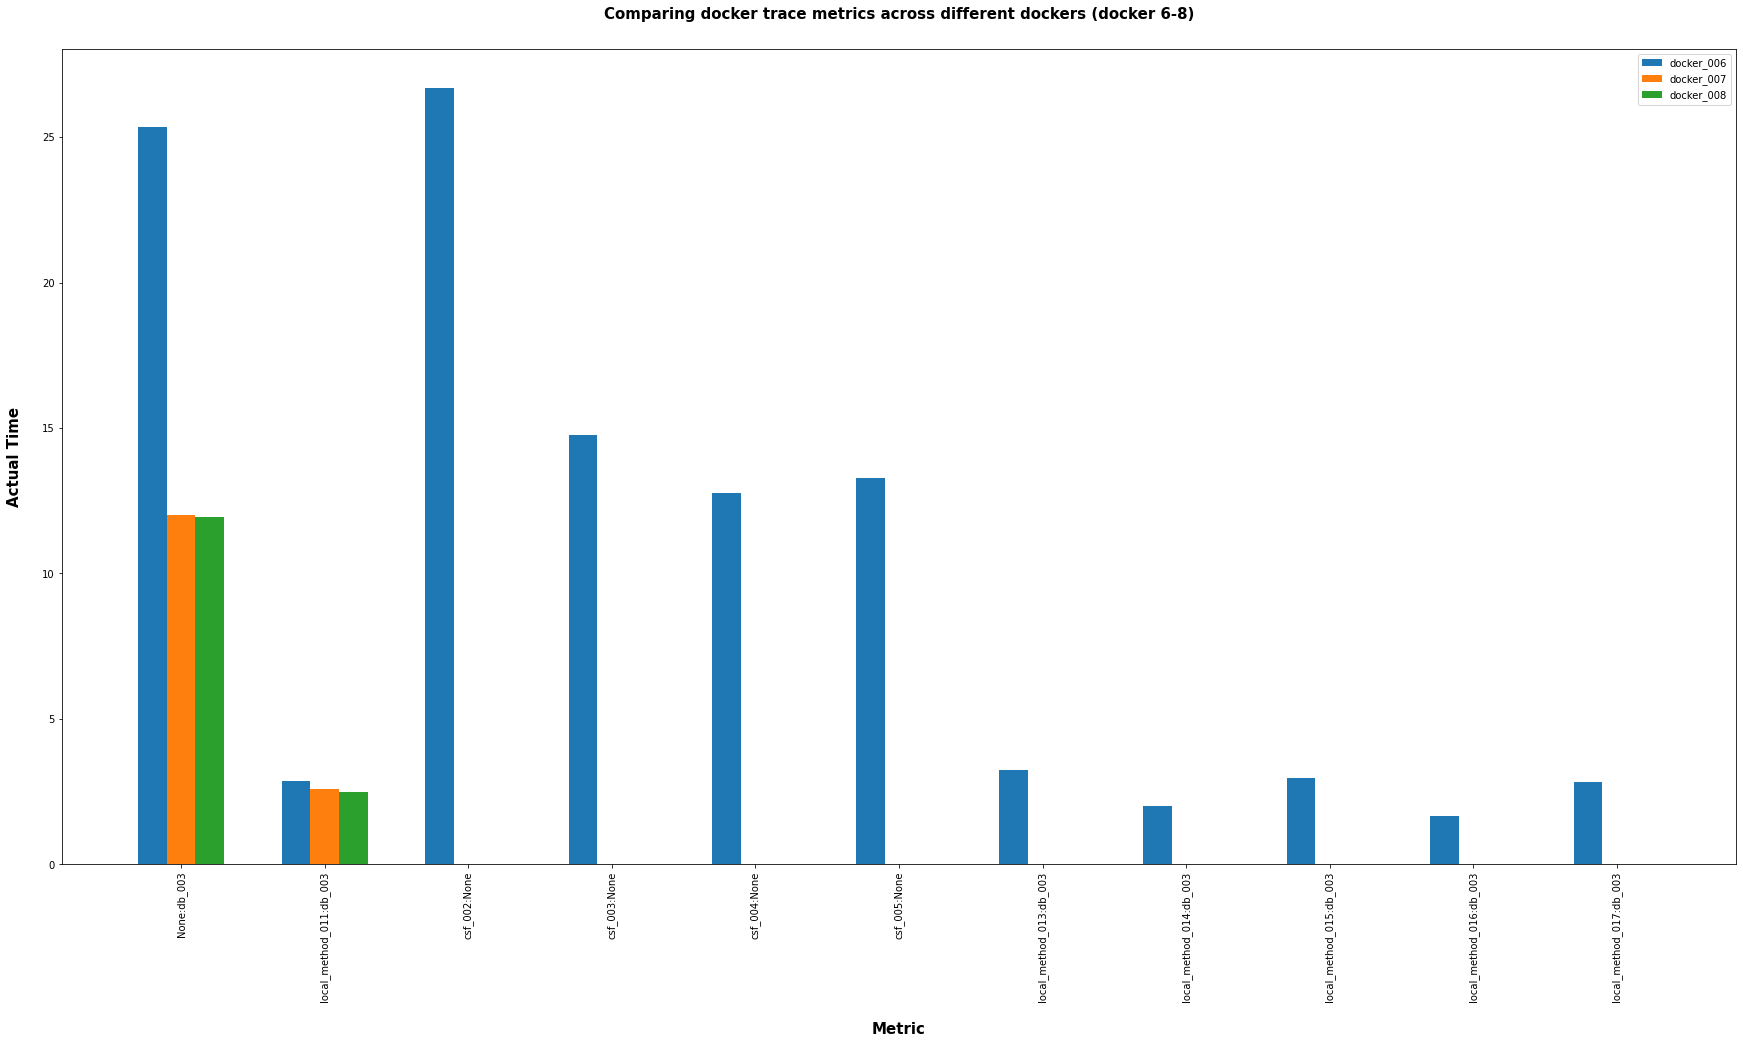

In [125]:
# Compare the metrics with docker_006 against other metrics with docker_002 or docker_008
cumulative_docker_006 = cumulative[cumulative.unique_identifier.str.contains('docker_006')]
cumulative_docker_006.unique_identifier = cumulative_docker_006.unique_identifier.str.replace('docker_006:', '')

temp = cumulative_docker_006
cumulative_docker_006 = pd.DataFrame(columns=['unique_identifier', 'train_actual_time', 'test_actual_time', 'difference'])
cumulative_docker_006 = cumulative_docker_006.append(temp.iloc[0], ignore_index=True)
cumulative_docker_006 = cumulative_docker_006.append(temp.iloc[5], ignore_index=True)
cumulative_docker_006 = cumulative_docker_006.append(temp.iloc[1:5], ignore_index=True)
cumulative_docker_006 = cumulative_docker_006.append(temp.iloc[6:], ignore_index=True)


cumulative_docker_007 = cumulative[cumulative.unique_identifier.str.contains('docker_007')]
cumulative_docker_007.unique_identifier = cumulative_docker_007.unique_identifier.str.replace('docker_007:', '')
# Append empty rows to cumulative_docker_007 to match the length of cumulative_docker_006
cumulative_docker_007 = cumulative_docker_007.append(
    [pd.DataFrame(np.zeros((1, 3)), columns=['unique_identifier', 'difference', 'test_actual_time'])] * 9 , ignore_index=True)


cumulative_docker_008 = cumulative[cumulative.unique_identifier.str.contains('docker_008')]
cumulative_docker_008.unique_identifier = cumulative_docker_008.unique_identifier.str.replace('docker_008:', '')
# Append empty rows to cumulative_docker_008 to match the length of cumulative_docker_006
cumulative_docker_008 = cumulative_docker_008.append(
    [pd.DataFrame(np.zeros((1, 3)), columns=['unique_identifier', 'difference', 'test_actual_time'])] * 9 , ignore_index=True)


# Plot cumulative_docker_006, cumulative_docker_007, cumulative_docker_008
fig, ax1 = plt.subplots(1, 1, figsize=(30, 15))

# Multi bar Chart
x_axis = np.arange(len(cumulative_docker_006))

ax1.bar(x_axis -0.2, cumulative_docker_006.train_actual_time, width=0.2, label = 'docker_006')
ax1.bar(x_axis, cumulative_docker_007.test_actual_time, width=0.2, label = 'docker_007')
ax1.bar(x_axis +0.2, cumulative_docker_008.test_actual_time, width=0.2, label = 'docker_008')
ax1.set_xticks(x_axis)
ax1.set_xticklabels(cumulative_docker_006.unique_identifier, rotation=90)

ax1.set_title("Comparing docker trace metrics across different dockers (docker 6-8)", fontsize=15, fontweight='bold', pad=30, color='black', loc='center')
ax1.set_xlabel('Metric', fontsize=15, fontweight='bold', color='black', labelpad=20)
ax1.set_ylabel('Actual Time', fontsize=15, fontweight='bold', color='black', labelpad=20)
ax1.legend(loc='upper right')

plt.setp(ax1.xaxis.get_majorticklabels(), rotation=90)
plt.show()

In [126]:
pd.reset_option('display.max_rows')

del test_trace_filtered, train_trace_filtered, \
    test_trace_filtered_parent_os_021, train_trace_filtered_parent_os_021, \
    test_trace_filtered_parent_os_022, train_trace_filtered_parent_os_022

del cumulative

gc.collect()

35568

### Breaking Down Failure #5

Failure #5 Details:
```json
[
    28800, 
    [[
        "docker_005", 
        null
    ]]
]
```

#### ESB Indicators

<b>Analysis:</b>
From the 4 line charts, we observe that although the success rate did not change (subplot #4 remained constant at 1), the average time taken to process each service call increased sharply and the number of services requests handled decreased around the failure time period. This unusual behaviour can be noted by comparing against itself across 1 hour, as well as comparing against the train data (normal data with no failures) across the same time period. This indicates that failure #1 does not result in a failure of a service call, but could lead to other side effects such as longer call times and fewer services requests handled. This phenomenon could potentially be due to the app's error handling or simply due to poorer load balancing effects.

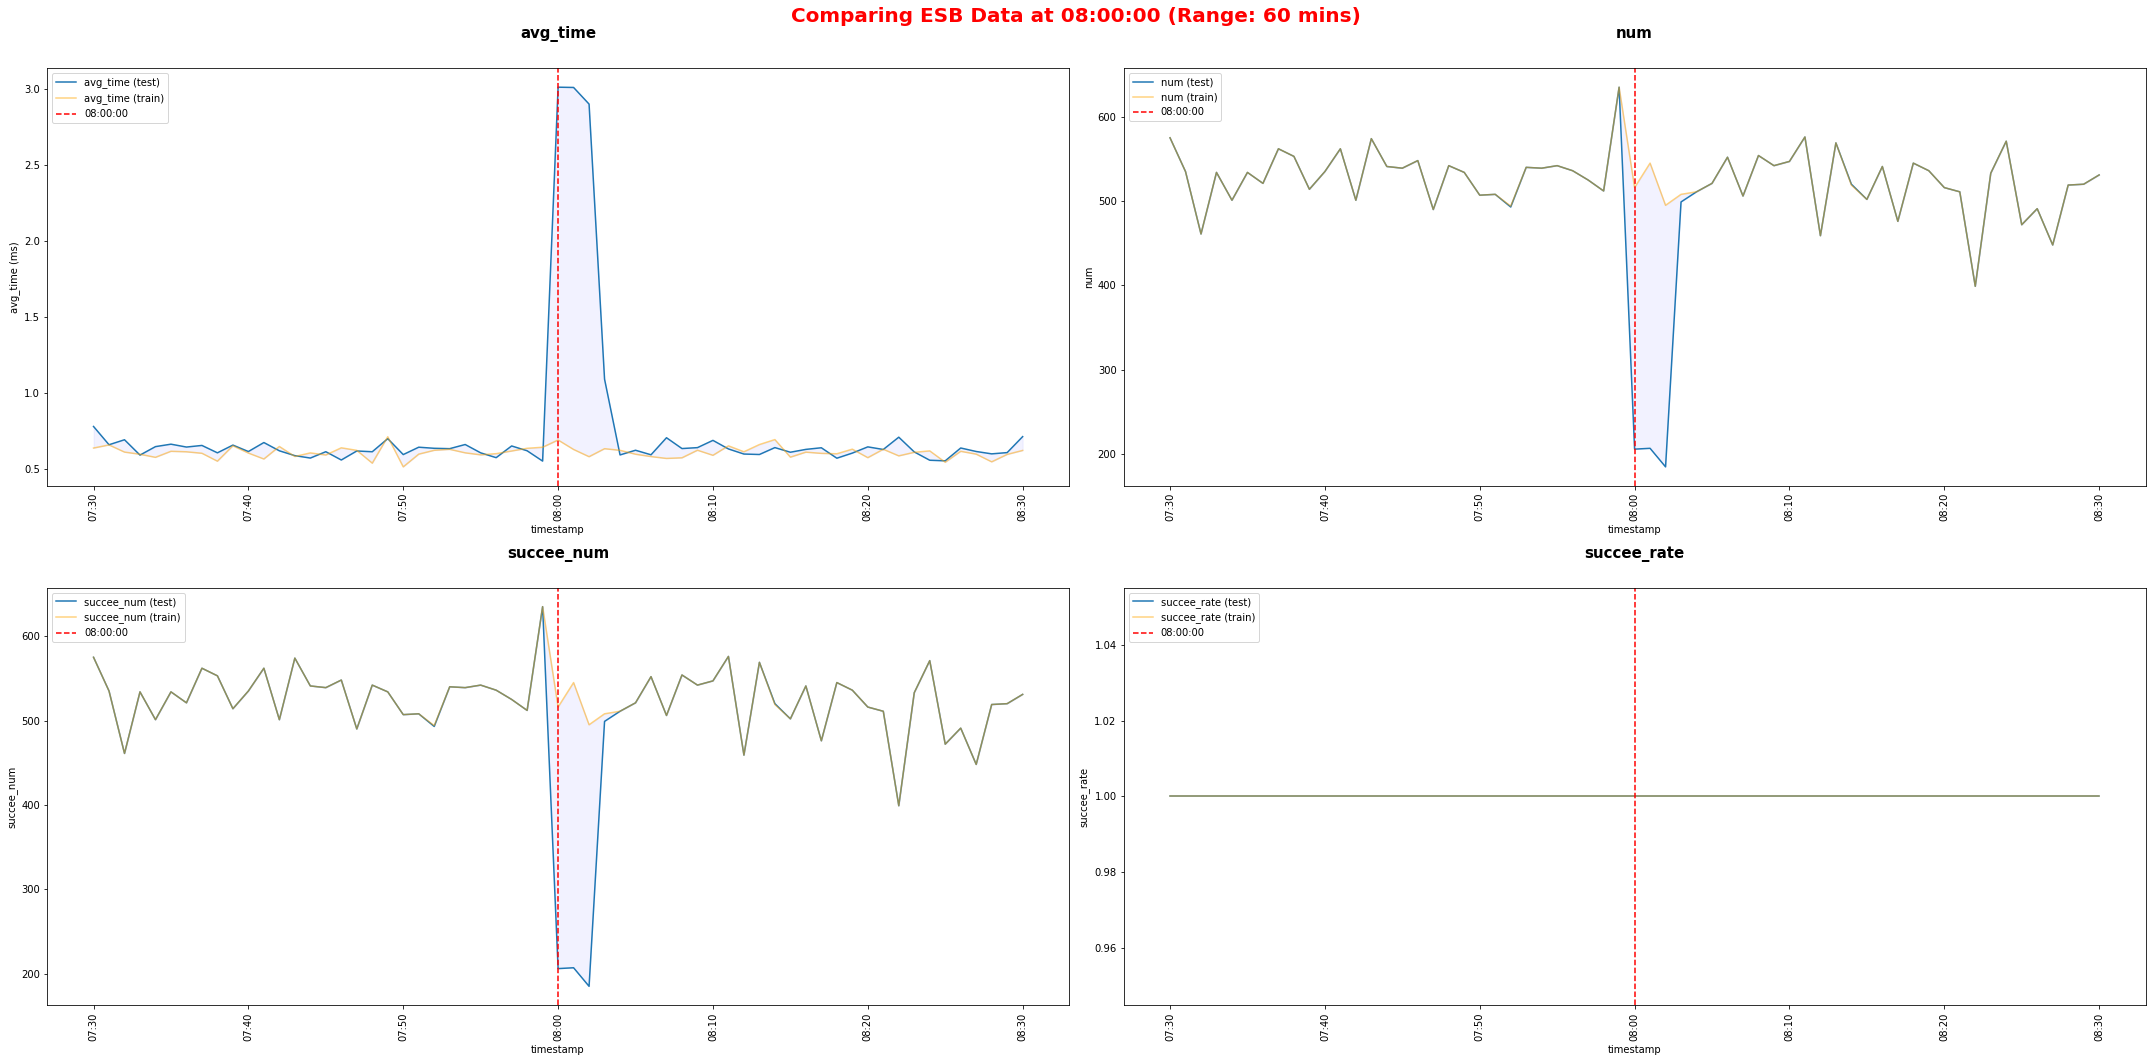

In [127]:
seconds_past = 28800
a, b = compare_esb(seconds_past, interval=60)

In [128]:
del a, b
gc.collect()

14180

#### Host Indicators

FYI: From `cmdb.xlsx`, `docker_005` is also mapped to `os_017`. However, we will only check the host data in `dcos_docker.csv`

<b>Analysis:</b>
Trying out all possible `name` for `docker_005`, we note the following observations:
1. `container_cpu_used` -> Although there are fluctuations compared to train data, they do not appear anomalous when compared other dockers (i.e. `docker_007`) in test data
2. `container_mem_used` -> Although there are fluctuations compared to train data, they do not appear anomalous when compared other dockers (i.e. `docker_007`) in test data
3. `container_fgc` -> All values are 0
4. `container_fgct` -> All values are 0
5. `container_session_used` -> All values are 0
6. `container_thread_idle` -> All values are 0
7. `container_thread_running` -> All values are 0
8. `container_thread_total` -> All values are 0
9. `container_thread_used_pct` -> All values are 0

In [134]:
test_host = read_host("test_data", "dcos_docker", verbose=False)
train_host = read_host("train_data/2020_05_04", "dcos_docker", verbose=False)

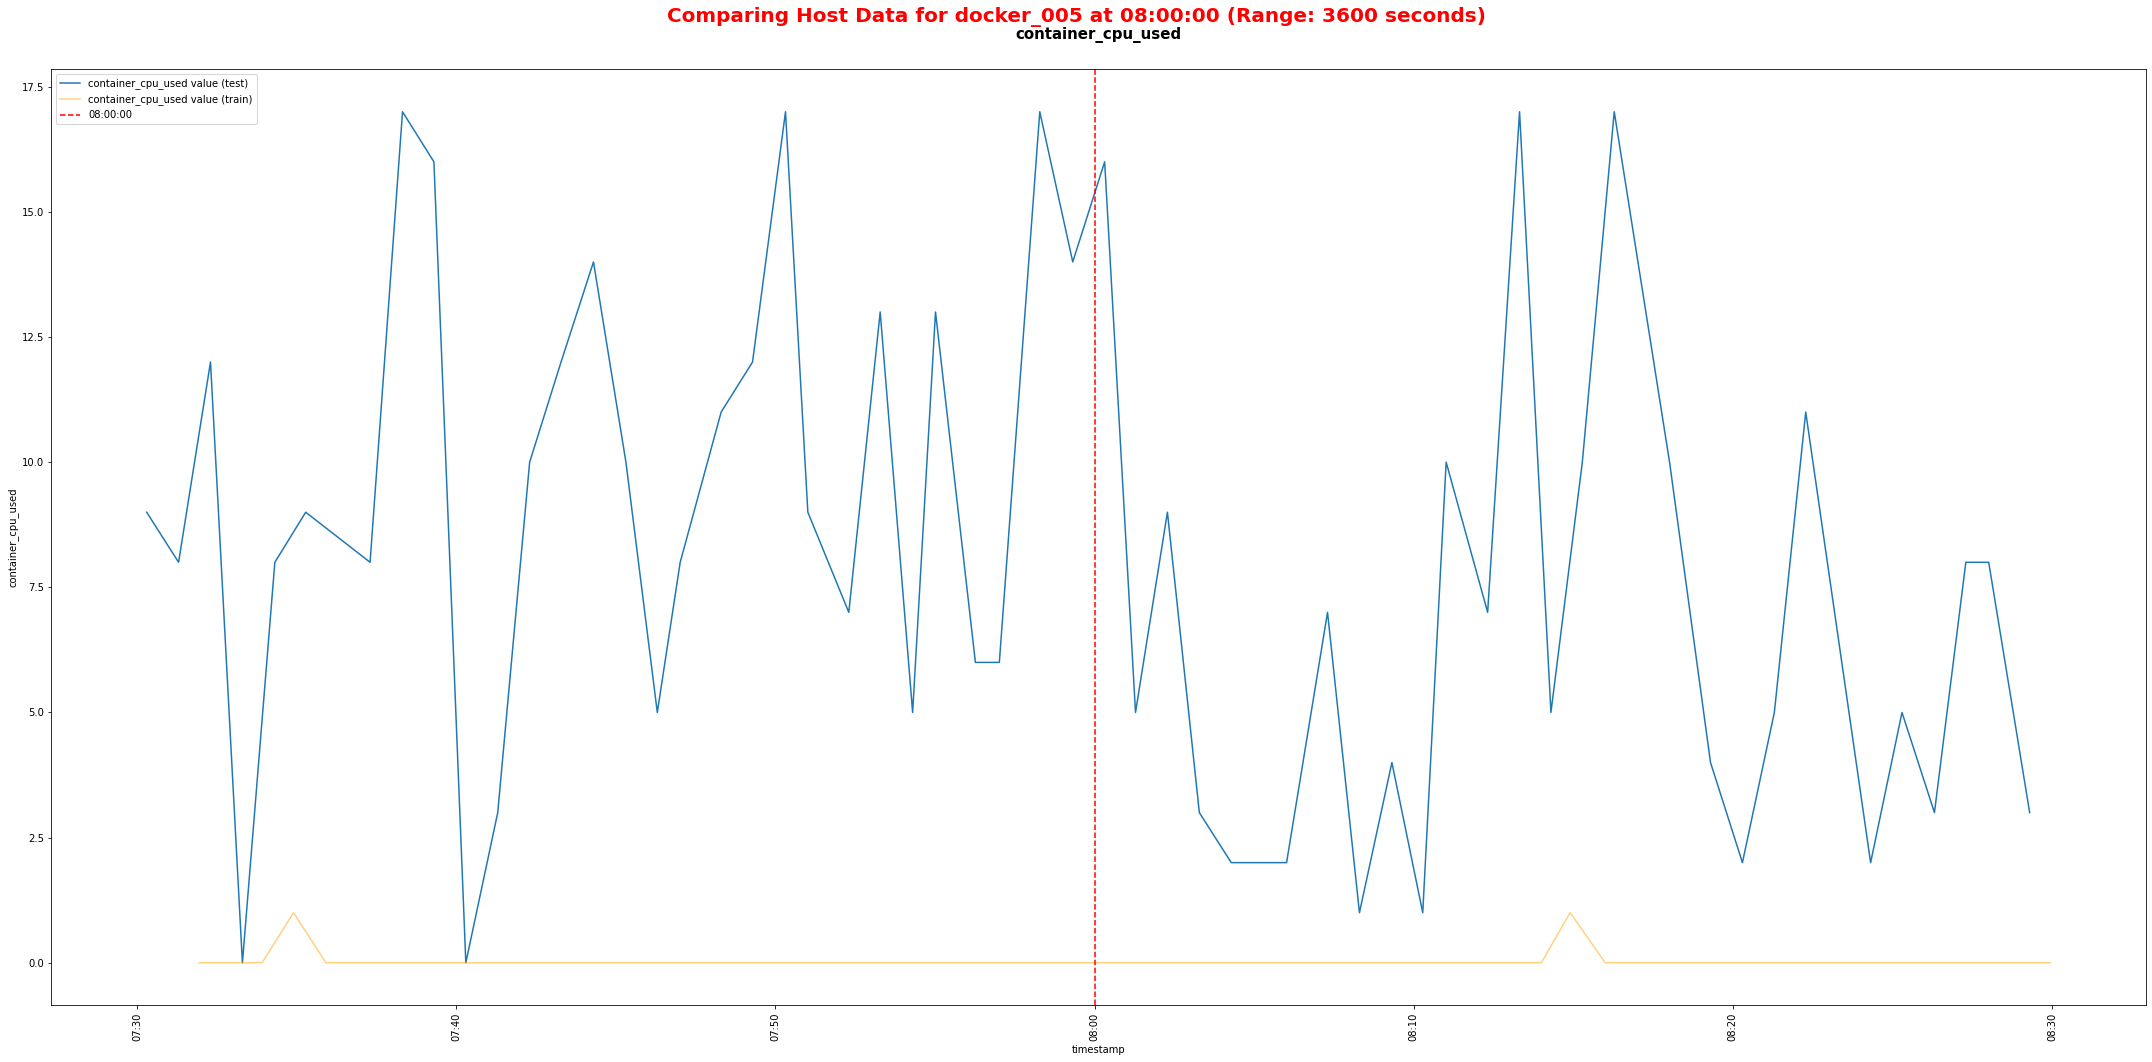

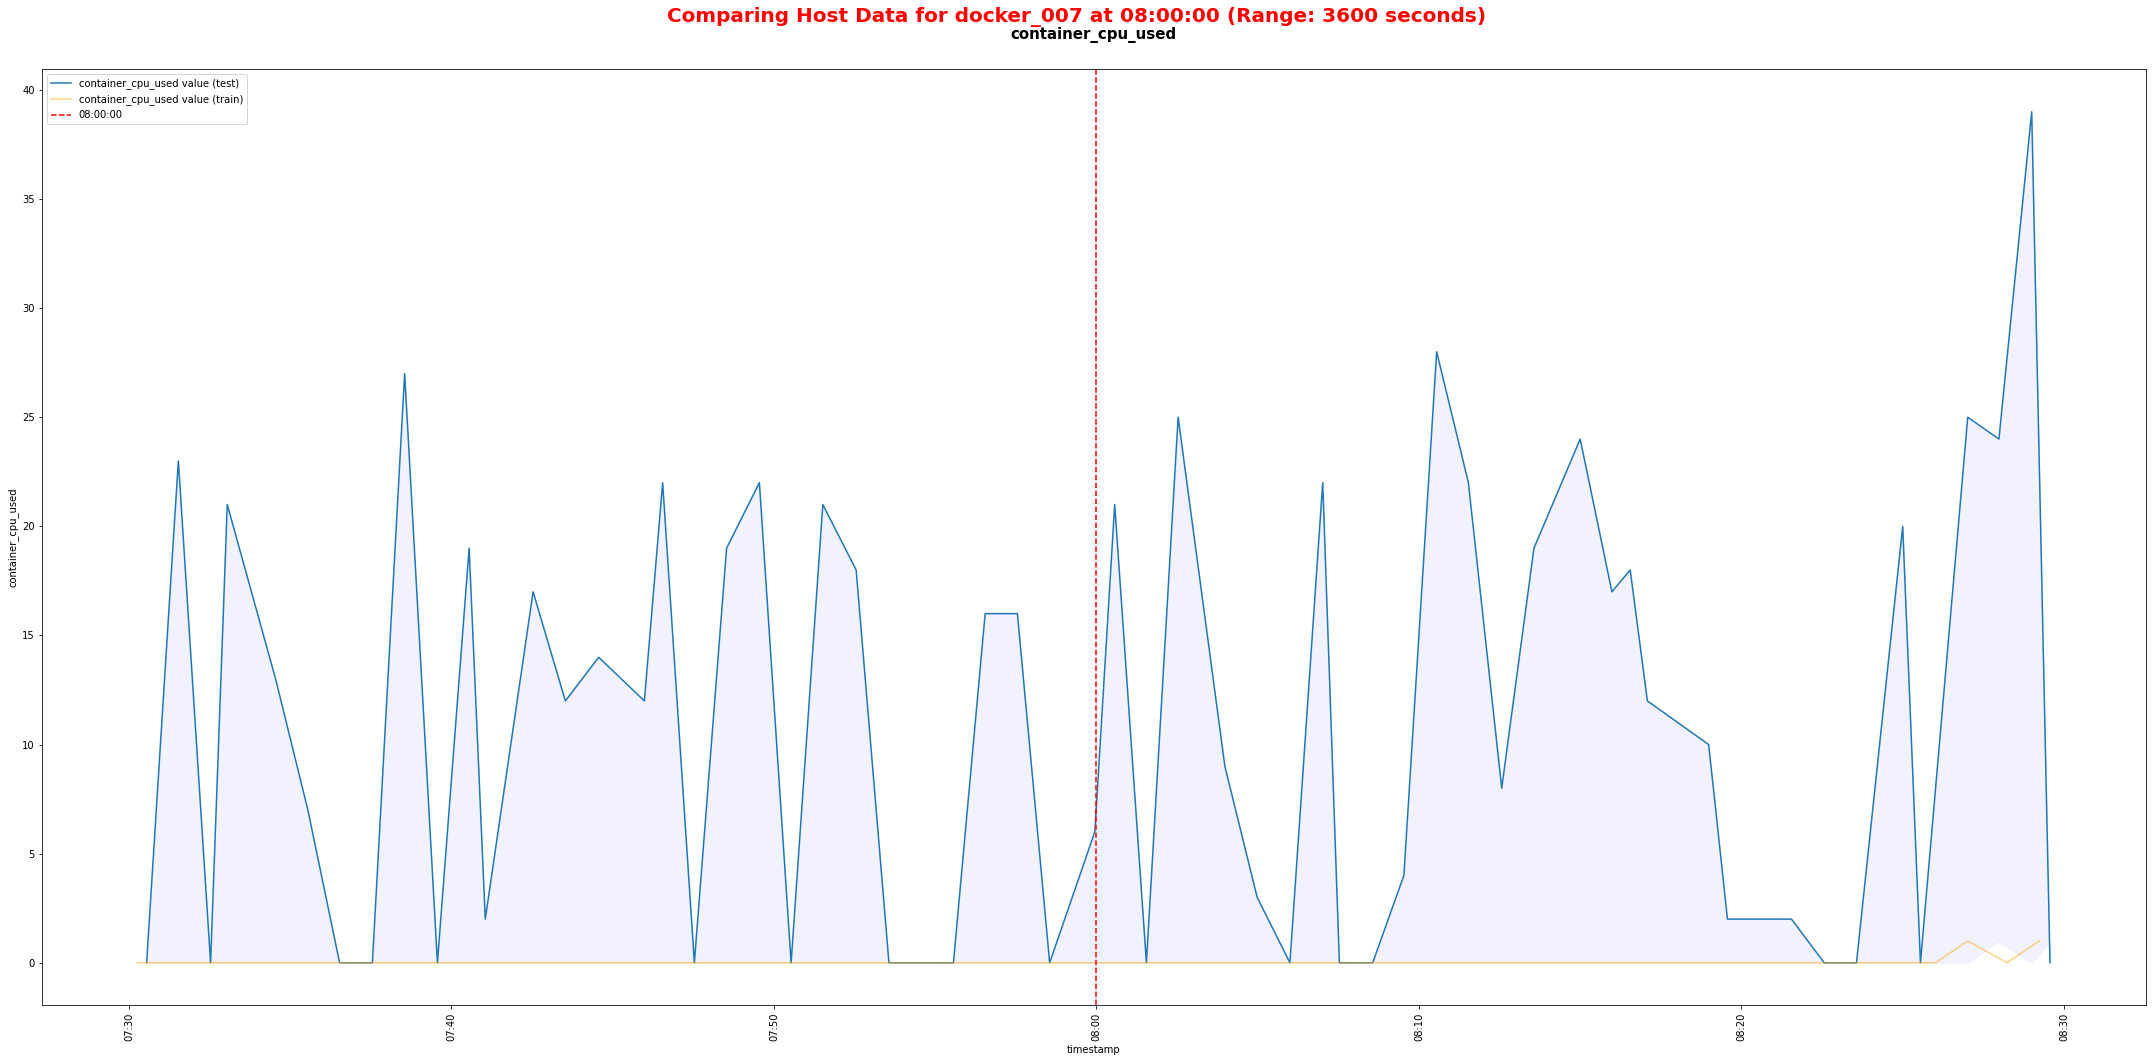

In [138]:
# In the ESB Indicator, we used 1 hour as the range. Therefore, we will use 1 hour as the interval for this case
# This allows us to visually overlap the graphs to identify any patterns

# Plot for docker_005 and docker_007
test_host_compared, train_host_compared = compare_host(test_host=test_host,
                                                        train_host=train_host,
                                                        seconds_past=seconds_past,
                                                        cmdb_id='docker_005',
                                                        name='container_cpu_used',
                                                        interval=60*60)

test_host_compared, train_host_compared = compare_host(test_host=test_host,
                                                        train_host=train_host,
                                                        seconds_past=seconds_past,
                                                        cmdb_id='docker_007',
                                                        name='container_cpu_used',
                                                        interval=60*60)

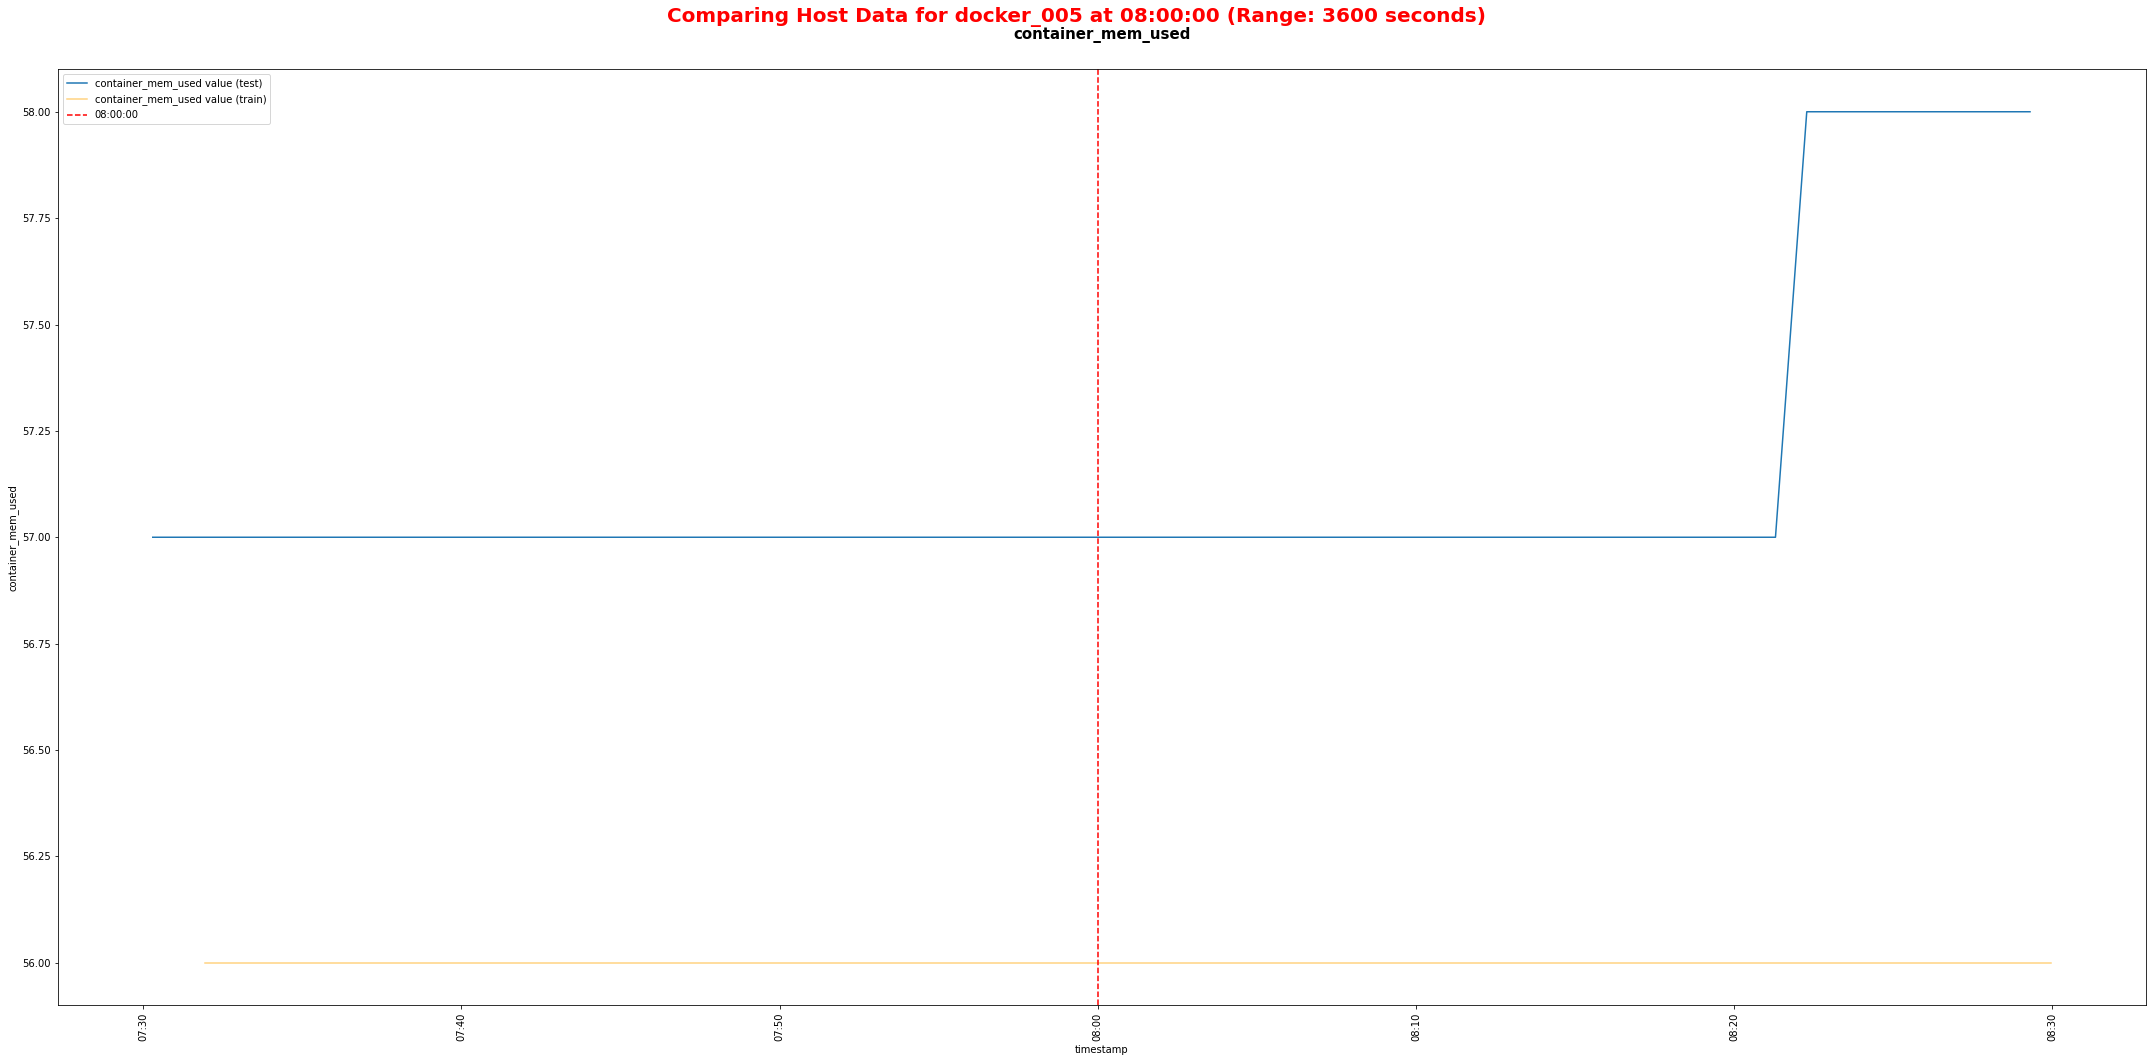

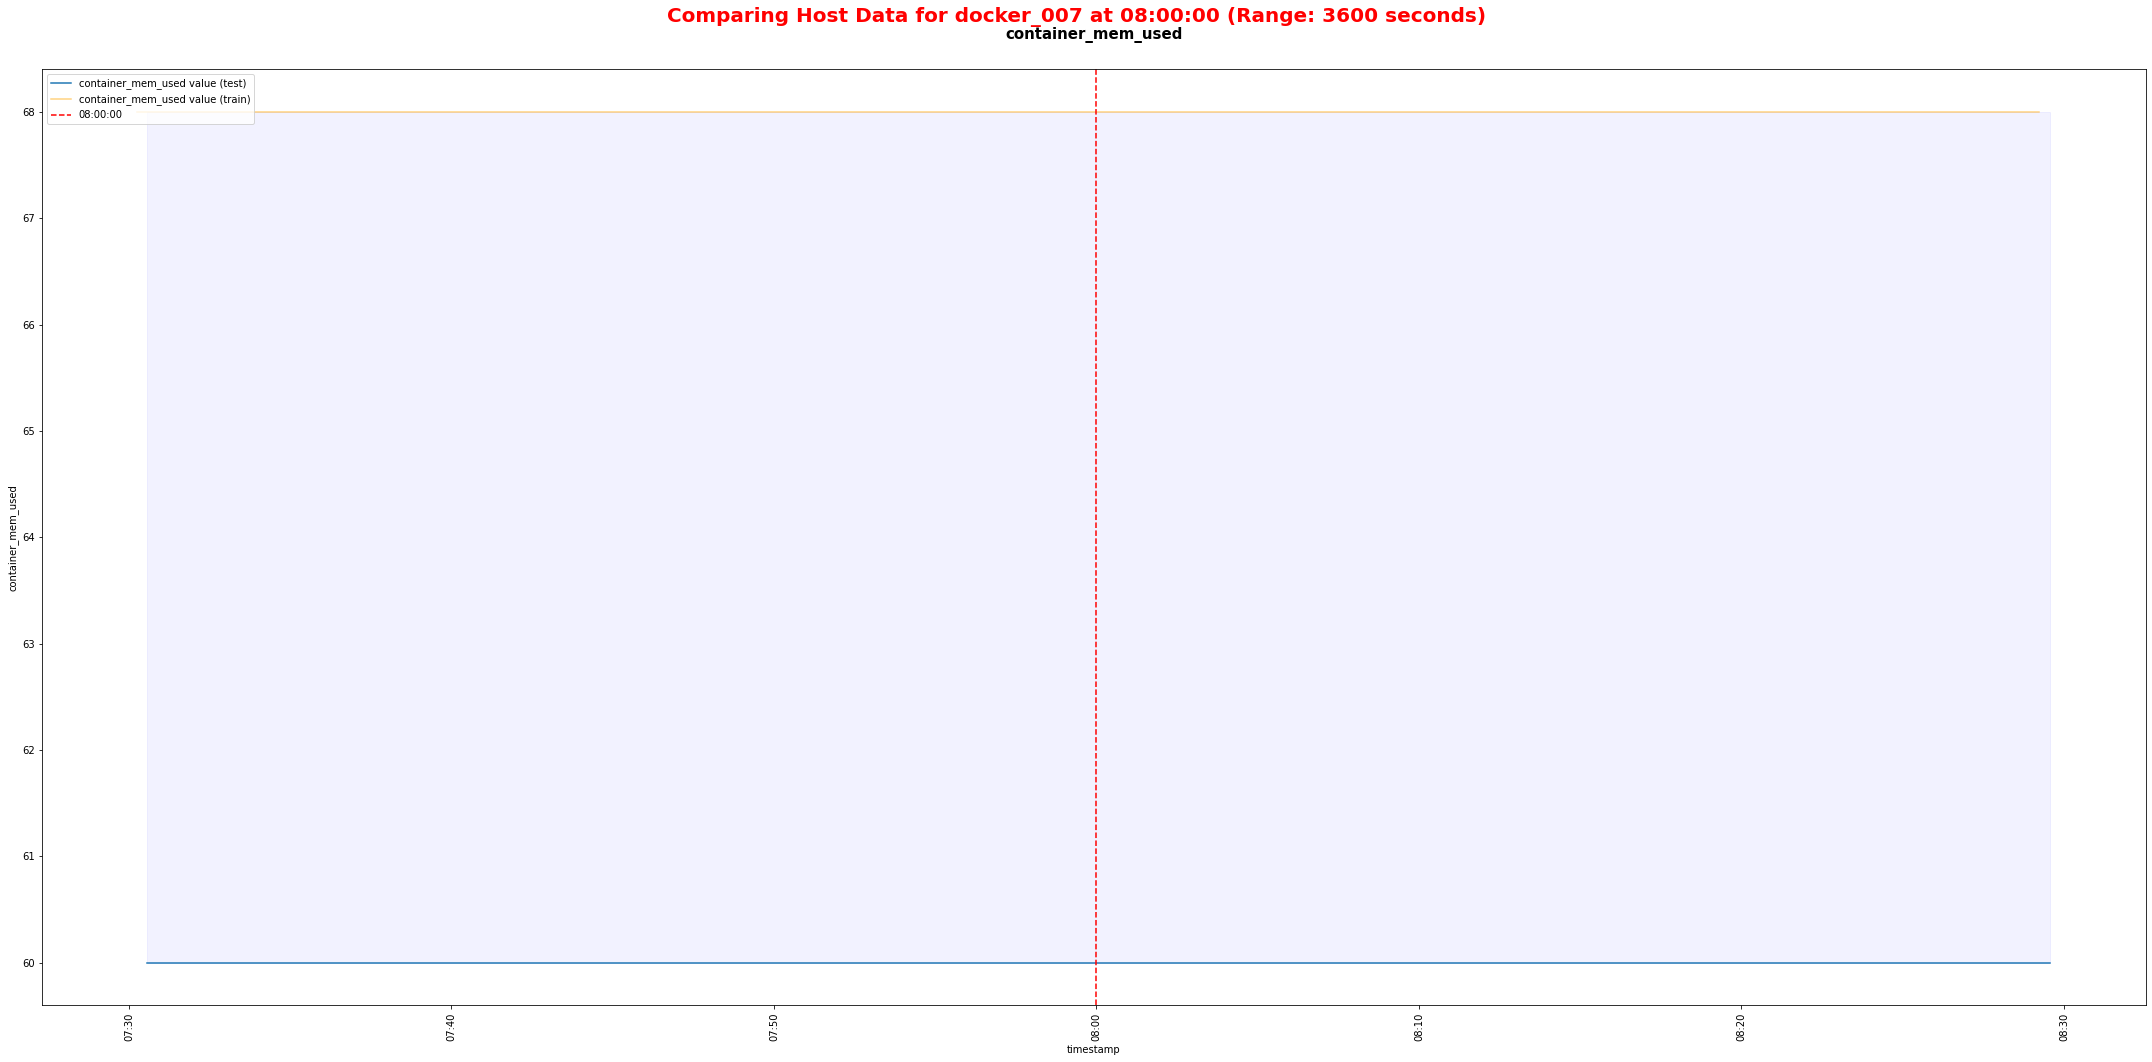

In [142]:
# In the ESB Indicator, we used 1 hour as the range. Therefore, we will use 1 hour as the interval for this case
# This allows us to visually overlap the graphs to identify any patterns

# Plot for docker_005 and docker_007
test_host_compared, train_host_compared = compare_host(test_host=test_host,
                                                        train_host=train_host,
                                                        seconds_past=seconds_past,
                                                        cmdb_id='docker_005',
                                                        name='container_mem_used',
                                                        interval=60*60)

test_host_compared, train_host_compared = compare_host(test_host=test_host,
                                                        train_host=train_host,
                                                        seconds_past=seconds_past,
                                                        cmdb_id='docker_007',
                                                        name='container_mem_used',
                                                        interval=60*60)

In [143]:
del test_host_compared, train_host_compared
del test_host, train_host
gc.collect()

19227

#### Trace Indicators

<b>Analysis:</b>
Since we know that `docker_005` has a failure and that all traceId begin from a root process that must start from either `os_021` or `os_022` (refer to Data Exploration's Finding #6), we will plot the following graphs - (1) comparing the length of trace data, (2) comparing the elapsed time of the parent processes for `os_021`, (3) comparing the elapsed time of the parent processes for `os_022`

These graphs' time period are carefully chosen to ensure that long-elapse-time functions are shown and there are ample data before & after to ascertain the trend.

From the graphs, we can tell that:
1. Number of trace invocations (trace length) remained roughly the same despite failure
2. `os_021` experienced (1) reduction in service call frequency, (2) lower elapsed time
3. `os_022` experienced significantly higher elapsed time

<b>Similar to Failure #2's Trace Indicators Explanation, we will compare specific dockers</b>

`docker_005` is more similar to `docker_006` to `docker_008`. Therefore, this will shape the logic subsequently, when we compared the docker metrics across to detect anomalies.

Subsequently, we sampled for 100 traceIDs (since 100 is a large sample size for approximation) from both the train and test data to:
1. Calculate actual time taken for each process ID, combining them through a unique identifier (in the format of `cmdb_id:serviceName:dsName`)
2. Find out the average time taken across all 100 traceIDs for their respective 
3. Merge the train and test dataframe to compute their differences (where possible)
4. Filter for `docker_005`, `docker_006` (`docker_007` and `docker_008` are not as relevant as `docker_006` which is the non-faulty docker in similar circumstances / system) in the `uniquer_identifier` (since they share similar metrics and trace calls)
5. Plot and compare their values to observe for anomalies

From the output graph of the above step, we notice that:
1. `None:db_003` and `csf_002:None` has the largest difference between `docker_005`, `docker_006`

Therefore, since `db_003` and `csf_002` are outer spans, we can conclude that the failure of `docker_005` can be attributed to the large increase in time to pass control to other microservices called by `csf_002` and the database.

<b>What this means to the developer:</b>
Code review should be performed on `docker_005:csf_002:None` to understand the cause for the increase in time taken to call other microservices.

<b>What this means to site reliability engineer / ML engineer:</b>
We can potentially detect docker failure (for `docker_005` to `docker_008`) by observing the `db_003` and `csf_002:None` metrics, for large increase in actual time.

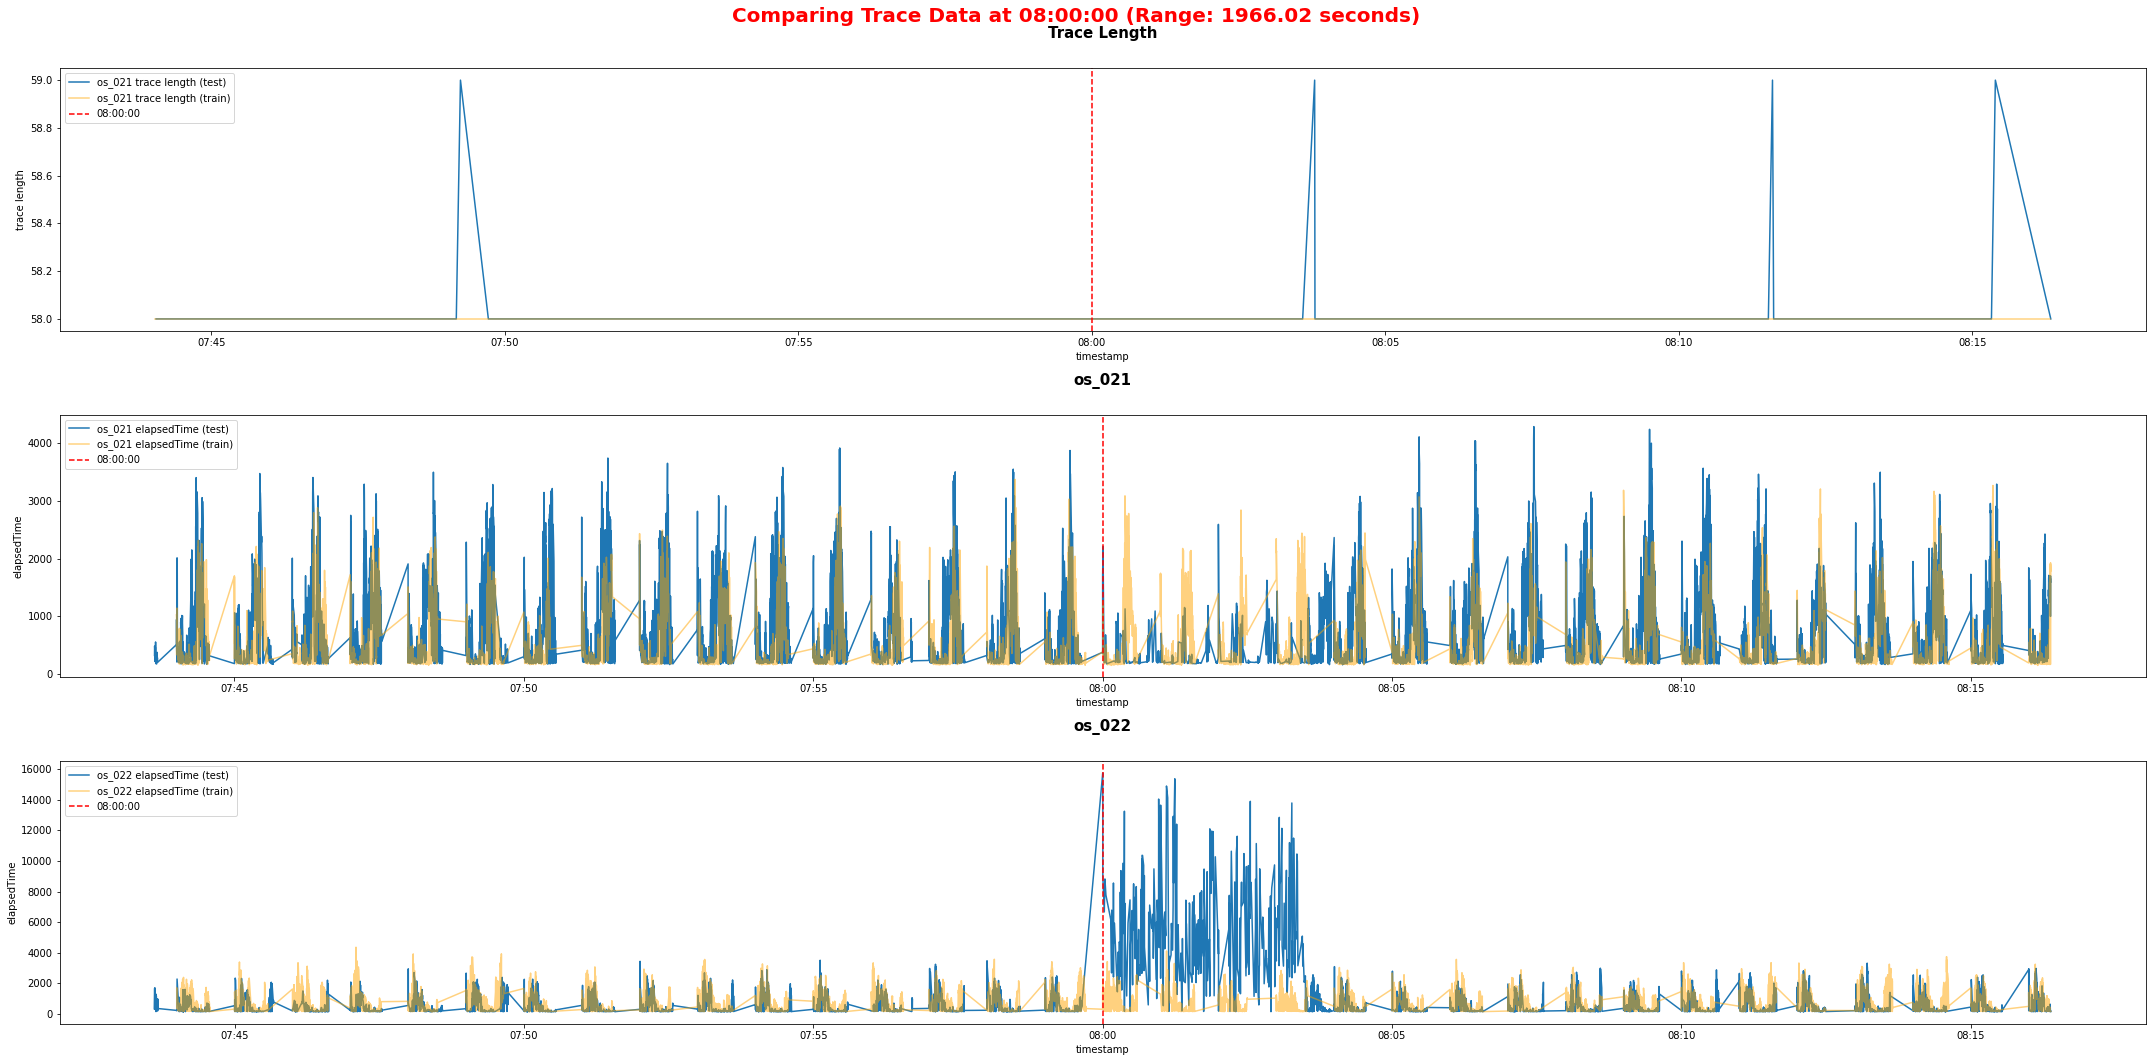

In [156]:
test_trace_filtered, train_trace_filtered, \
test_trace_length_list, train_trace_length_list, \
test_trace_filtered_parent_os_021, train_trace_filtered_parent_os_021, \
test_trace_filtered_parent_os_022, train_trace_filtered_parent_os_022 = \
compare_trace_for_failure(test_trace, train_trace, seconds_past=seconds_past)

<b>Finding the root cause for the slower processing speed</b>

In [157]:
cumulative = compare_trace_childrens_failure2(test_trace_filtered, train_trace_filtered, test_trace_filtered_parent_os_022, train_trace_filtered_parent_os_022)
pd.set_option('display.max_rows', None)
cumulative

unique_identifier  train_actual_time  test_actual_time  \
6              docker_001:csf_005:None               2.75            912.96   
4              docker_001:csf_003:None               5.03            788.64   
23             docker_002:csf_005:None               5.92            692.19   
5              docker_001:csf_004:None               5.22            691.26   
22             docker_002:csf_004:None               6.60            666.15   
20             docker_002:csf_002:None               9.98            661.45   
3              docker_001:csf_002:None               7.73            632.97   
21             docker_002:csf_003:None               7.30            616.21   
2              docker_001:csf_001:None              22.22            608.56   
19             docker_002:csf_001:None              30.51            476.24   
57                 os_022:osb_001:None              13.51            435.44   
56                 os_022:csf_001:None              10.42            138.29   
1               docker_001:None:db_009               9.31             11.82   
7       docker_001:fly_remote_001:None               2.36              4.34   
14  docker_001:local_method_007:db_009               0.59              2.09   
24      docker_002:fly_remote_001:None               3.27              4.16   
25  docker_002:local_method_001:db_009               0.55              1.13   
26  docker_002:local_method_002:db_009               2.81              3.30   
32  docker_002:local_method_009:db_009               1.77              2.11   
30  docker_002:local_method_006:db_009               2.40              2.62   
8   docker_001:local_method_001:db_009               0.50              0.43   
12  docker_001:local_method_005:db_009               1.78              1.57   
13  docker_001:local_method_006:db_009               3.17              2.59   
10  docker_001:local_method_003:db_009               1.18              0.56   
11  docker_001:local_method_004:db_009               5.01              4.38   
31  docker_002:local_method_007:db_009               1.12              0.44   
29  docker_002:local_method_005:db_009               2.19              1.38   
27  docker_002:local_method_003:db_009               2.28              1.45   
17              docker_002:None:db_007               5.73              4.86   
15  docker_001:local_method_009:db_009               1.78              0.85   
18              docker_002:None:db_009              14.27             12.58   
33  docker_002:local_method_010:db_007               3.97              1.59   
9   docker_001:local_method_002:db_009               4.08              1.66   
16  docker_001:local_method_010:db_007               3.38              0.94   
0               docker_001:None:db_007               7.38              4.16   
28  docker_002:local_method_004:db_009               9.26              4.48   
34              docker_007:None:db_003              12.55               NaN   
35             docker_007:csf_002:None              14.74               NaN   
36             docker_007:csf_003:None               5.14               NaN   
37             docker_007:csf_004:None               8.16               NaN   
38             docker_007:csf_005:None               6.24               NaN   
39  docker_007:local_method_011:db_003               1.27               NaN   
40  docker_007:local_method_013:db_003               1.02               NaN   
41  docker_007:local_method_014:db_003               0.94               NaN   
42  docker_007:local_method_015:db_003               1.23               NaN   
43  docker_007:local_method_016:db_003               0.67               NaN   
44  docker_007:local_method_017:db_003               1.14               NaN   
45              docker_008:None:db_003              13.44               NaN   
46             docker_008:csf_002:None              12.75               NaN   
47             docker_008:csf_003:None               7.94              

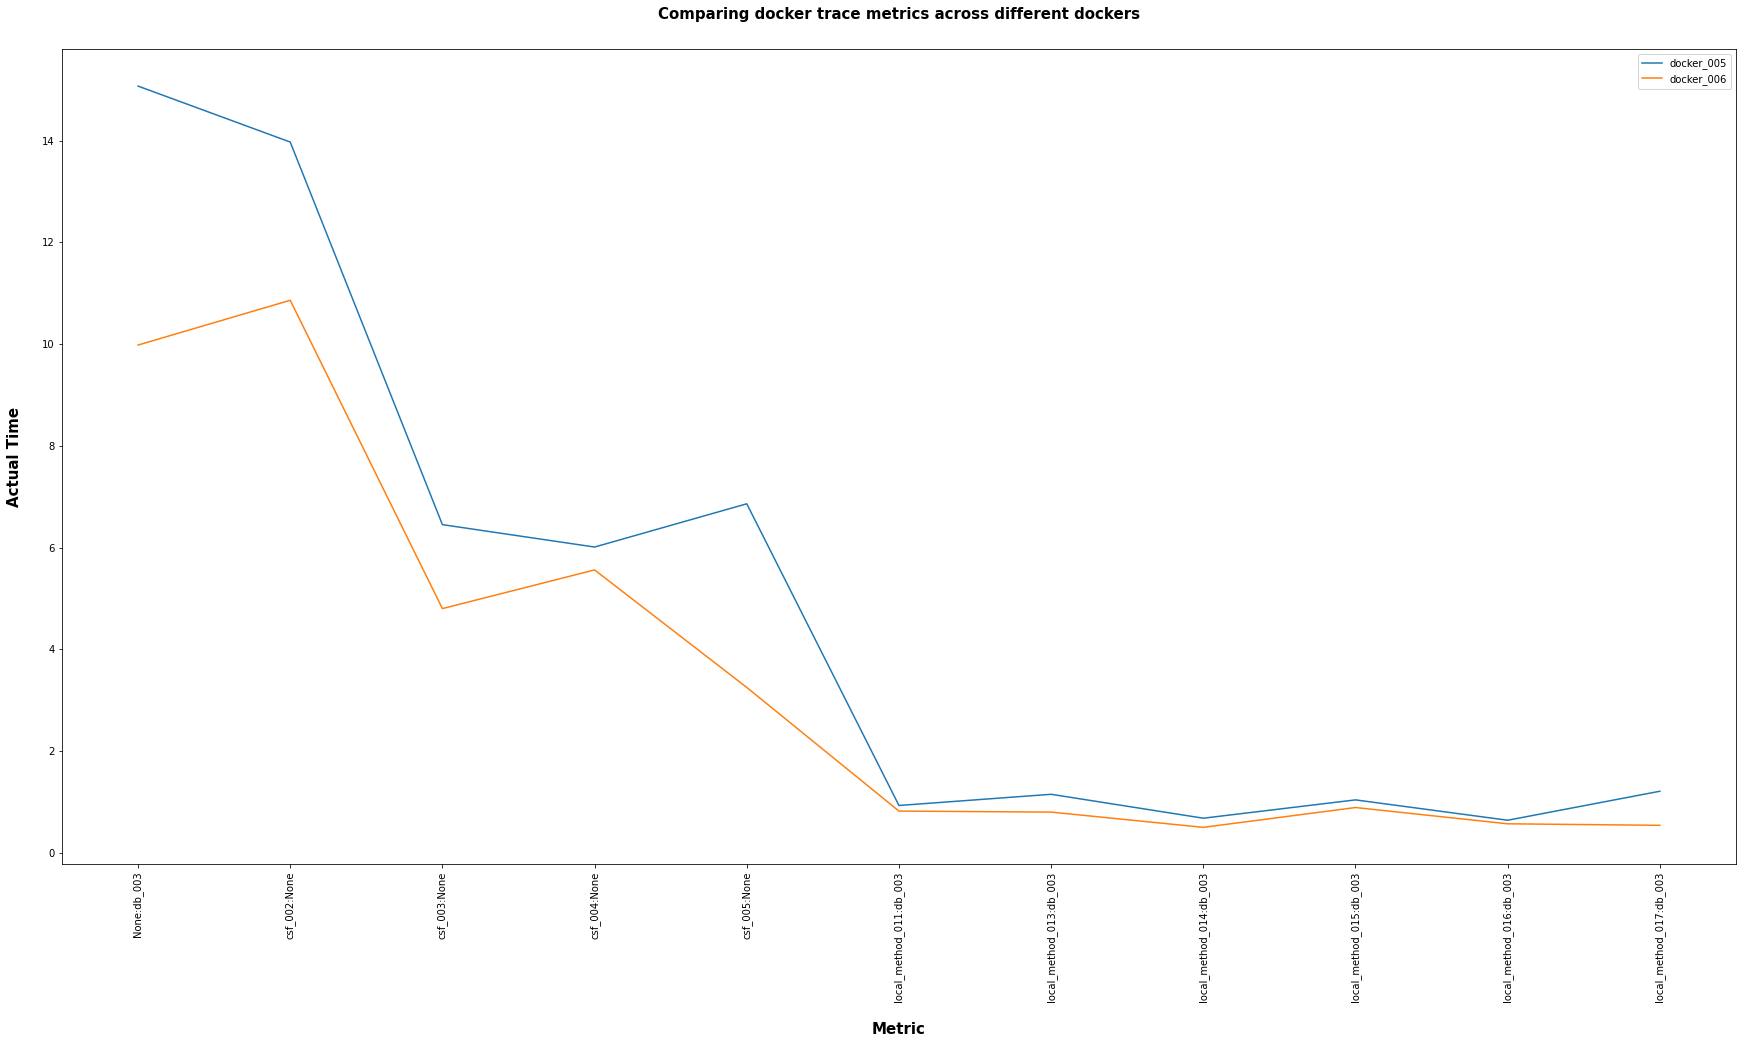

In [158]:
# Compare the metrics with docker_007 against other metrics with docker_006 or docker_008
cumulative_docker_005 = cumulative[cumulative.unique_identifier.str.contains('docker_005')]
cumulative_docker_005.unique_identifier = cumulative_docker_005.unique_identifier.str.replace('docker_005:', '')

cumulative_docker_006 = cumulative[cumulative.unique_identifier.str.contains('docker_006')]
cumulative_docker_006.unique_identifier = cumulative_docker_006.unique_identifier.str.replace('docker_006:', '')

# Plot cumulative_docker_006, cumulative_docker_007, cumulative_docker_008
fig, ax = plt.subplots(1, 1, figsize=(30, 15))

ax.plot(cumulative_docker_005.unique_identifier, cumulative_docker_005.test_actual_time, label='docker_005')
ax.plot(cumulative_docker_006.unique_identifier, cumulative_docker_006.test_actual_time, label='docker_006')

plt.xticks(rotation=90)
ax.set_title("Comparing docker trace metrics across different dockers", fontsize=15, fontweight='bold', pad=30, color='black', loc='center')
ax.set_xlabel('Metric', fontsize=15, fontweight='bold', color='black', labelpad=20)
ax.set_ylabel('Actual Time', fontsize=15, fontweight='bold', color='black', labelpad=20)
plt.legend()
plt.show()

In [159]:
pd.reset_option('display.max_rows')

del test_trace_filtered, train_trace_filtered, \
    test_trace_filtered_parent_os_021, train_trace_filtered_parent_os_021, \
    test_trace_filtered_parent_os_022, train_trace_filtered_parent_os_022

del cumulative

gc.collect()

15265